**Goal**: To predict the success of a Telemarketing campaign of a Bank based on whether a customer will subscribe for a term deposit or not. Further, find out the most influencing factors that affect the success of this campaign.

**Steps** - 
1. Feature Engineering and Data Transformation
2. Modeling Plan
   - Split the dataset into predictors and response variables
   - Split the dataset into training and test set
   - Create Model
   - Fine tune Hyper-parameters 
   - Test Performance
   - Report Final Results
3. Identify most important factors based on socioeconomic characteristics of the customers

**Import Libraries**

In [128]:
import pandas as pd

In [129]:
import numpy as np

In [130]:
import seaborn as sns

In [131]:
import matplotlib.pyplot as plt

**Set Seed**

In [132]:
seed = 42
np.random.seed(seed)

**Upload DataSet**

In [133]:
df = pd.read_csv('bank-additional-full.csv',sep=';')

In [134]:
# Take a look at the data
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


**Tranformation Steps for Categorical Variables**
1. Drop rows with missing data values in columns - job and marital
2. Check if rows can be dropped for columns - housing and loan. Rows can be dropped if the loss of information is minimal.
3. One-hot encode the rest of the categorical columns

In [135]:
# Drop rows with values that are 'unknown' in columns job and marital
df.drop(df[df.job == 'unknown'].index, inplace=True)
df.drop(df[df.marital == 'unknown'].index, inplace=True)

In [136]:
len(df)

40787

The number of rows lost are 401 which is roughly 1% of dataset.

In [137]:
# Drop rows with values that are 'unknown' in cloumns housing and loan
# Check the number of records lost
len(df.drop(df[df.housing == 'unknown'].index))

39803

The number of records lost are 984 which is roughly 2.4% of the dataset.

In [138]:
len(df.drop(df[df.loan == 'unknown'].index))

39803

We do not lose any more records which indicates that records with unknowns in housing column also had unknowns in the personal loan column.Therefore, total loss would be only 2.4% if we decide to drop unknowns in both of these columns.

In [139]:
# Drop rows with values that are 'unknown' in columns housing and loan 
df.drop(df[df.housing == 'unknown'].index, inplace=True)
df.drop(df[df.loan == 'unknown'].index, inplace=True)

In [140]:
# One-hot encode categorical variables
categorical_cols = ['job','housing','loan','marital','education','default','contact','month','day_of_week','poutcome']
df = pd.get_dummies(df, columns=categorical_cols)

**Transformation Steps for Numeric Variables**
1. Drop the columns euribor3m and emp.var.rate
2. Create buckets for pdays column and drop the numeric column. The buckets are - pdays <= 10, 10 < pdays <= 20, 20 < pdays <= 30, pdays = 999

In [141]:
# Drop the columns
df = df.drop(columns=['euribor3m','emp.var.rate'])

In [142]:
df['pdays_cat'] = pd.cut(df['pdays'], bins=[-1, 10, 20, 30, float('Inf')], labels=['less_than_10','between_10_and_20', 'between_20_and_30','Not_contacted_previously'])

In [143]:
# Drop pdays column and one-hot encode the pdays_cat column
df = df.drop(columns=['pdays'])
df = pd.get_dummies(df, columns=['pdays_cat'])

In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39803 entries, 0 to 41187
Data columns (total 61 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   age                                 39803 non-null  int64  
 1   duration                            39803 non-null  int64  
 2   campaign                            39803 non-null  int64  
 3   previous                            39803 non-null  int64  
 4   cons.price.idx                      39803 non-null  float64
 5   cons.conf.idx                       39803 non-null  float64
 6   nr.employed                         39803 non-null  float64
 7   y                                   39803 non-null  object 
 8   job_admin.                          39803 non-null  uint8  
 9   job_blue-collar                     39803 non-null  uint8  
 10  job_entrepreneur                    39803 non-null  uint8  
 11  job_housemaid                       39803

**Transform the Target Variable**

In [145]:
# Transform the target variable using binary encoder
df["y"] = np.where(df["y"].str.contains("yes"), 1, 0)

Traget Variable: y = {'yes' = 1, 'no' = 0}

In [146]:
df.head()

,age,duration,campaign,previous,cons.price.idx,cons.conf.idx,nr.employed,y,job_admin.,job_blue-collar,...,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,pdays_cat_less_than_10,pdays_cat_between_10_and_20,pdays_cat_between_20_and_30,pdays_cat_Not_contacted_previously
0,56,261,1,0,93.994,-36.4,5191.0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,57,149,1,0,93.994,-36.4,5191.0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,37,226,1,0,93.994,-36.4,5191.0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,40,151,1,0,93.994,-36.4,5191.0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
4,56,307,1,0,93.994,-36.4,5191.0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


Finally, since we don't know whether the distribution of numeric continuous variables is gaussian or not, we normalize those columns using a min-max scalar.

In [147]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
df[['age','duration','campaign','previous','cons.price.idx','cons.conf.idx','nr.employed']] = scaler.fit_transform(df[['age','duration','campaign','previous','cons.price.idx','cons.conf.idx','nr.employed']])
df.head()

,age,duration,campaign,previous,cons.price.idx,cons.conf.idx,nr.employed,y,job_admin.,job_blue-collar,...,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,pdays_cat_less_than_10,pdays_cat_between_10_and_20,pdays_cat_between_20_and_30,pdays_cat_Not_contacted_previously
0,0.481481,0.053070,0.0,0.0,0.698753,0.60251,0.859735,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,0.493827,0.030297,0.0,0.0,0.698753,0.60251,0.859735,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0.246914,0.045954,0.0,0.0,0.698753,0.60251,0.859735,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0.283951,0.030704,0.0,0.0,0.698753,0.60251,0.859735,0,1,0,...,0,0,0,0,1,0,0,0,0,1
4,0.481481,0.062424,0.0,0.0,0.698753,0.60251,0.859735,0,0,0,...,0,0,0,0,1,0,0,0,0,1


**Modeling Plan**
1. Split the dataset into predictors and response variables
2. Split the dataset into training and test set
3. Create Model
4. Fine tune Hyper-parameters 
5. Test Performance 
6. Report Final Results

In [148]:
# Separating X and y
X = df.drop('y',axis=1)
y = df[['y']]

In [149]:
!pip install fast_ml

In [150]:
# Splitting the training set into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=1)

print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(y_test.shape)

(29852, 60)
(29852, 1)
(9951, 60)
(9951, 1)


(None, None)

In [151]:
!pip install scikeras

In [152]:
!pip install keras

In [153]:
!pip install tensorflow

In [154]:
# Import libraries
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

In [155]:
# Create model
def get_model(neurons):
  # define the keras model
  model = Sequential()
  model.add(Dense(neurons, input_dim=60, kernel_initializer='uniform', activation='relu'))
  model.add(Dense(60, activation='relu'))
  model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
  #compile the keras model
  model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
  return model

In [156]:
# Tuning our Model
model = KerasClassifier(model=get_model, epochs=100, batch_size=1000, verbose=2)

# Hyperparameters
neurons = np.arange(1, 61, 30)
learning_rate = [0.1, 0.01]
batch_size = [1024, 2048]
optimizer =  ['rmsprop', 'adam']
epochs = np.arange(50, 101, 25)

param_grid = dict(model__neurons=neurons, optimizer__learning_rate=learning_rate, batch_size=batch_size, epochs=epochs, optimizer=optimizer)

grid = GridSearchCV(estimator=model, param_grid=param_grid)

In [157]:
grid_result = grid.fit(X_train, y_train)

Epoch 1/50
24/24 - 5s - loss: 0.6655 - accuracy: 0.8866 - 5s/epoch - 195ms/step
Epoch 2/50
24/24 - 0s - loss: 0.5814 - accuracy: 0.8866 - 203ms/epoch - 8ms/step
Epoch 3/50
24/24 - 0s - loss: 0.4797 - accuracy: 0.8866 - 157ms/epoch - 7ms/step
Epoch 4/50
24/24 - 0s - loss: 0.3945 - accuracy: 0.8866 - 185ms/epoch - 8ms/step
Epoch 5/50
24/24 - 0s - loss: 0.3479 - accuracy: 0.8866 - 160ms/epoch - 7ms/step
Epoch 6/50
24/24 - 0s - loss: 0.3341 - accuracy: 0.8866 - 185ms/epoch - 8ms/step
Epoch 7/50
24/24 - 1s - loss: 0.3285 - accuracy: 0.8866 - 962ms/epoch - 40ms/step
Epoch 8/50
24/24 - 2s - loss: 0.3227 - accuracy: 0.8866 - 2s/epoch - 63ms/step
Epoch 9/50
24/24 - 0s - loss: 0.3167 - accuracy: 0.8866 - 223ms/epoch - 9ms/step
Epoch 10/50
24/24 - 0s - loss: 0.3109 - accuracy: 0.8866 - 149ms/epoch - 6ms/step
Epoch 11/50
24/24 - 0s - loss: 0.3053 - accuracy: 0.8866 - 200ms/epoch - 8ms/step
Epoch 12/50
24/24 - 0s - loss: 0.3009 - accuracy: 0.8866 - 217ms/epoch - 9ms/step
Epoch 13/50
24/24 - 0s - lo

6/6 - 0s - 161ms/epoch - 27ms/step
Epoch 1/50
24/24 - 2s - loss: 0.6543 - accuracy: 0.8866 - 2s/epoch - 77ms/step
Epoch 2/50
24/24 - 0s - loss: 0.5428 - accuracy: 0.8866 - 118ms/epoch - 5ms/step
Epoch 3/50
24/24 - 0s - loss: 0.4291 - accuracy: 0.8866 - 152ms/epoch - 6ms/step
Epoch 4/50
24/24 - 0s - loss: 0.3587 - accuracy: 0.8866 - 133ms/epoch - 6ms/step
Epoch 5/50
24/24 - 0s - loss: 0.3362 - accuracy: 0.8866 - 129ms/epoch - 5ms/step
Epoch 6/50
24/24 - 0s - loss: 0.3292 - accuracy: 0.8866 - 130ms/epoch - 5ms/step
Epoch 7/50
24/24 - 0s - loss: 0.3225 - accuracy: 0.8866 - 133ms/epoch - 6ms/step
Epoch 8/50
24/24 - 0s - loss: 0.3156 - accuracy: 0.8866 - 130ms/epoch - 5ms/step
Epoch 9/50
24/24 - 0s - loss: 0.3093 - accuracy: 0.8866 - 138ms/epoch - 6ms/step
Epoch 10/50
24/24 - 0s - loss: 0.3038 - accuracy: 0.8866 - 164ms/epoch - 7ms/step
Epoch 11/50
24/24 - 0s - loss: 0.2990 - accuracy: 0.8866 - 129ms/epoch - 5ms/step
Epoch 12/50
24/24 - 0s - loss: 0.2955 - accuracy: 0.8866 - 124ms/epoch - 5

6/6 - 0s - 178ms/epoch - 30ms/step
Epoch 1/50
24/24 - 3s - loss: 0.6716 - accuracy: 0.8820 - 3s/epoch - 142ms/step
Epoch 2/50
24/24 - 0s - loss: 0.5873 - accuracy: 0.8866 - 229ms/epoch - 10ms/step
Epoch 3/50
24/24 - 0s - loss: 0.4767 - accuracy: 0.8866 - 251ms/epoch - 10ms/step
Epoch 4/50
24/24 - 1s - loss: 0.3860 - accuracy: 0.8866 - 1s/epoch - 46ms/step
Epoch 5/50
24/24 - 0s - loss: 0.3436 - accuracy: 0.8866 - 475ms/epoch - 20ms/step
Epoch 6/50
24/24 - 0s - loss: 0.3325 - accuracy: 0.8866 - 293ms/epoch - 12ms/step
Epoch 7/50
24/24 - 0s - loss: 0.3269 - accuracy: 0.8866 - 296ms/epoch - 12ms/step
Epoch 8/50
24/24 - 0s - loss: 0.3209 - accuracy: 0.8866 - 216ms/epoch - 9ms/step
Epoch 9/50
24/24 - 0s - loss: 0.3146 - accuracy: 0.8866 - 194ms/epoch - 8ms/step
Epoch 10/50
24/24 - 1s - loss: 0.3088 - accuracy: 0.8866 - 516ms/epoch - 22ms/step
Epoch 11/50
24/24 - 0s - loss: 0.3038 - accuracy: 0.8866 - 293ms/epoch - 12ms/step
Epoch 12/50
24/24 - 0s - loss: 0.3001 - accuracy: 0.8866 - 270ms/epo

6/6 - 0s - 136ms/epoch - 23ms/step
Epoch 1/50
24/24 - 1s - loss: 0.6593 - accuracy: 0.8866 - 1s/epoch - 56ms/step
Epoch 2/50
24/24 - 0s - loss: 0.5576 - accuracy: 0.8866 - 106ms/epoch - 4ms/step
Epoch 3/50
24/24 - 0s - loss: 0.4467 - accuracy: 0.8866 - 115ms/epoch - 5ms/step
Epoch 4/50
24/24 - 0s - loss: 0.3698 - accuracy: 0.8866 - 117ms/epoch - 5ms/step
Epoch 5/50
24/24 - 0s - loss: 0.3408 - accuracy: 0.8866 - 111ms/epoch - 5ms/step
Epoch 6/50
24/24 - 0s - loss: 0.3330 - accuracy: 0.8866 - 120ms/epoch - 5ms/step
Epoch 7/50
24/24 - 0s - loss: 0.3269 - accuracy: 0.8866 - 119ms/epoch - 5ms/step
Epoch 8/50
24/24 - 0s - loss: 0.3202 - accuracy: 0.8866 - 98ms/epoch - 4ms/step
Epoch 9/50
24/24 - 0s - loss: 0.3130 - accuracy: 0.8866 - 119ms/epoch - 5ms/step
Epoch 10/50
24/24 - 0s - loss: 0.3067 - accuracy: 0.8866 - 110ms/epoch - 5ms/step
Epoch 11/50
24/24 - 0s - loss: 0.3018 - accuracy: 0.8866 - 110ms/epoch - 5ms/step
Epoch 12/50
24/24 - 0s - loss: 0.2981 - accuracy: 0.8866 - 108ms/epoch - 4m

6/6 - 0s - 117ms/epoch - 20ms/step
Epoch 1/50
24/24 - 1s - loss: 0.6817 - accuracy: 0.8863 - 1s/epoch - 53ms/step
Epoch 2/50
24/24 - 0s - loss: 0.6397 - accuracy: 0.8866 - 102ms/epoch - 4ms/step
Epoch 3/50
24/24 - 0s - loss: 0.5452 - accuracy: 0.8866 - 111ms/epoch - 5ms/step
Epoch 4/50
24/24 - 0s - loss: 0.4386 - accuracy: 0.8866 - 106ms/epoch - 4ms/step
Epoch 5/50
24/24 - 0s - loss: 0.3670 - accuracy: 0.8866 - 122ms/epoch - 5ms/step
Epoch 6/50
24/24 - 0s - loss: 0.3411 - accuracy: 0.8866 - 128ms/epoch - 5ms/step
Epoch 7/50
24/24 - 0s - loss: 0.3339 - accuracy: 0.8866 - 117ms/epoch - 5ms/step
Epoch 8/50
24/24 - 0s - loss: 0.3275 - accuracy: 0.8866 - 135ms/epoch - 6ms/step
Epoch 9/50
24/24 - 0s - loss: 0.3205 - accuracy: 0.8866 - 138ms/epoch - 6ms/step
Epoch 10/50
24/24 - 0s - loss: 0.3136 - accuracy: 0.8866 - 117ms/epoch - 5ms/step
Epoch 11/50
24/24 - 0s - loss: 0.3077 - accuracy: 0.8866 - 128ms/epoch - 5ms/step
Epoch 12/50
24/24 - 0s - loss: 0.3031 - accuracy: 0.8866 - 117ms/epoch - 5

6/6 - 0s - 120ms/epoch - 20ms/step
Epoch 1/50
24/24 - 1s - loss: 0.6607 - accuracy: 0.8866 - 1s/epoch - 51ms/step
Epoch 2/50
24/24 - 0s - loss: 0.5650 - accuracy: 0.8866 - 115ms/epoch - 5ms/step
Epoch 3/50
24/24 - 0s - loss: 0.4573 - accuracy: 0.8866 - 121ms/epoch - 5ms/step
Epoch 4/50
24/24 - 0s - loss: 0.3776 - accuracy: 0.8866 - 117ms/epoch - 5ms/step
Epoch 5/50
24/24 - 0s - loss: 0.3434 - accuracy: 0.8866 - 132ms/epoch - 5ms/step
Epoch 6/50
24/24 - 0s - loss: 0.3345 - accuracy: 0.8866 - 119ms/epoch - 5ms/step
Epoch 7/50
24/24 - 0s - loss: 0.3282 - accuracy: 0.8866 - 118ms/epoch - 5ms/step
Epoch 8/50
24/24 - 0s - loss: 0.3214 - accuracy: 0.8866 - 159ms/epoch - 7ms/step
Epoch 9/50
24/24 - 0s - loss: 0.3150 - accuracy: 0.8866 - 120ms/epoch - 5ms/step
Epoch 10/50
24/24 - 0s - loss: 0.3085 - accuracy: 0.8866 - 116ms/epoch - 5ms/step
Epoch 11/50
24/24 - 0s - loss: 0.3029 - accuracy: 0.8866 - 115ms/epoch - 5ms/step
Epoch 12/50
24/24 - 0s - loss: 0.2984 - accuracy: 0.8866 - 119ms/epoch - 5

6/6 - 0s - 103ms/epoch - 17ms/step
Epoch 1/50
24/24 - 1s - loss: 0.6685 - accuracy: 0.8676 - 906ms/epoch - 38ms/step
Epoch 2/50
24/24 - 0s - loss: 0.5769 - accuracy: 0.8866 - 124ms/epoch - 5ms/step
Epoch 3/50
24/24 - 0s - loss: 0.4645 - accuracy: 0.8866 - 123ms/epoch - 5ms/step
Epoch 4/50
24/24 - 0s - loss: 0.3788 - accuracy: 0.8866 - 114ms/epoch - 5ms/step
Epoch 5/50
24/24 - 0s - loss: 0.3419 - accuracy: 0.8866 - 121ms/epoch - 5ms/step
Epoch 6/50
24/24 - 0s - loss: 0.3329 - accuracy: 0.8866 - 113ms/epoch - 5ms/step
Epoch 7/50
24/24 - 0s - loss: 0.3268 - accuracy: 0.8866 - 135ms/epoch - 6ms/step
Epoch 8/50
24/24 - 0s - loss: 0.3206 - accuracy: 0.8866 - 123ms/epoch - 5ms/step
Epoch 9/50
24/24 - 0s - loss: 0.3137 - accuracy: 0.8866 - 116ms/epoch - 5ms/step
Epoch 10/50
24/24 - 0s - loss: 0.3071 - accuracy: 0.8866 - 112ms/epoch - 5ms/step
Epoch 11/50
24/24 - 0s - loss: 0.3017 - accuracy: 0.8866 - 117ms/epoch - 5ms/step
Epoch 12/50
24/24 - 0s - loss: 0.2976 - accuracy: 0.8866 - 117ms/epoch 

6/6 - 0s - 154ms/epoch - 26ms/step
Epoch 1/50
24/24 - 1s - loss: 0.6557 - accuracy: 0.8866 - 1s/epoch - 52ms/step
Epoch 2/50
24/24 - 0s - loss: 0.5547 - accuracy: 0.8866 - 161ms/epoch - 7ms/step
Epoch 3/50
24/24 - 0s - loss: 0.4453 - accuracy: 0.8866 - 169ms/epoch - 7ms/step
Epoch 4/50
24/24 - 0s - loss: 0.3685 - accuracy: 0.8866 - 156ms/epoch - 6ms/step
Epoch 5/50
24/24 - 0s - loss: 0.3393 - accuracy: 0.8866 - 157ms/epoch - 7ms/step
Epoch 6/50
24/24 - 0s - loss: 0.3322 - accuracy: 0.8866 - 144ms/epoch - 6ms/step
Epoch 7/50
24/24 - 0s - loss: 0.3262 - accuracy: 0.8866 - 114ms/epoch - 5ms/step
Epoch 8/50
24/24 - 0s - loss: 0.3200 - accuracy: 0.8866 - 120ms/epoch - 5ms/step
Epoch 9/50
24/24 - 0s - loss: 0.3143 - accuracy: 0.8866 - 135ms/epoch - 6ms/step
Epoch 10/50
24/24 - 0s - loss: 0.3090 - accuracy: 0.8866 - 108ms/epoch - 4ms/step
Epoch 11/50
24/24 - 0s - loss: 0.3045 - accuracy: 0.8866 - 115ms/epoch - 5ms/step
Epoch 12/50
24/24 - 0s - loss: 0.3011 - accuracy: 0.8866 - 120ms/epoch - 5

6/6 - 0s - 114ms/epoch - 19ms/step
Epoch 1/50
24/24 - 2s - loss: 0.6686 - accuracy: 0.8546 - 2s/epoch - 68ms/step
Epoch 2/50
24/24 - 0s - loss: 0.5813 - accuracy: 0.8866 - 223ms/epoch - 9ms/step
Epoch 3/50
24/24 - 0s - loss: 0.4714 - accuracy: 0.8866 - 209ms/epoch - 9ms/step
Epoch 4/50
24/24 - 0s - loss: 0.3851 - accuracy: 0.8866 - 156ms/epoch - 7ms/step
Epoch 5/50
24/24 - 0s - loss: 0.3456 - accuracy: 0.8866 - 123ms/epoch - 5ms/step
Epoch 6/50
24/24 - 0s - loss: 0.3357 - accuracy: 0.8866 - 112ms/epoch - 5ms/step
Epoch 7/50
24/24 - 0s - loss: 0.3299 - accuracy: 0.8866 - 119ms/epoch - 5ms/step
Epoch 8/50
24/24 - 0s - loss: 0.3236 - accuracy: 0.8866 - 110ms/epoch - 5ms/step
Epoch 9/50
24/24 - 0s - loss: 0.3171 - accuracy: 0.8866 - 111ms/epoch - 5ms/step
Epoch 10/50
24/24 - 0s - loss: 0.3105 - accuracy: 0.8866 - 118ms/epoch - 5ms/step
Epoch 11/50
24/24 - 0s - loss: 0.3049 - accuracy: 0.8866 - 115ms/epoch - 5ms/step
Epoch 12/50
24/24 - 0s - loss: 0.3002 - accuracy: 0.8866 - 112ms/epoch - 5

6/6 - 0s - 116ms/epoch - 19ms/step
Epoch 1/50
24/24 - 1s - loss: 0.6687 - accuracy: 0.8811 - 931ms/epoch - 39ms/step
Epoch 2/50
24/24 - 0s - loss: 0.5793 - accuracy: 0.8866 - 105ms/epoch - 4ms/step
Epoch 3/50
24/24 - 0s - loss: 0.4697 - accuracy: 0.8866 - 114ms/epoch - 5ms/step
Epoch 4/50
24/24 - 0s - loss: 0.3844 - accuracy: 0.8866 - 109ms/epoch - 5ms/step
Epoch 5/50
24/24 - 0s - loss: 0.3437 - accuracy: 0.8866 - 112ms/epoch - 5ms/step
Epoch 6/50
24/24 - 0s - loss: 0.3329 - accuracy: 0.8866 - 109ms/epoch - 5ms/step
Epoch 7/50
24/24 - 0s - loss: 0.3267 - accuracy: 0.8866 - 105ms/epoch - 4ms/step
Epoch 8/50
24/24 - 0s - loss: 0.3203 - accuracy: 0.8866 - 107ms/epoch - 4ms/step
Epoch 9/50
24/24 - 0s - loss: 0.3137 - accuracy: 0.8866 - 112ms/epoch - 5ms/step
Epoch 10/50
24/24 - 0s - loss: 0.3079 - accuracy: 0.8866 - 109ms/epoch - 5ms/step
Epoch 11/50
24/24 - 0s - loss: 0.3034 - accuracy: 0.8866 - 108ms/epoch - 5ms/step
Epoch 12/50
24/24 - 0s - loss: 0.3000 - accuracy: 0.8866 - 107ms/epoch 

6/6 - 0s - 146ms/epoch - 24ms/step
Epoch 1/50
24/24 - 1s - loss: 0.5908 - accuracy: 0.8532 - 1s/epoch - 57ms/step
Epoch 2/50
24/24 - 0s - loss: 0.3579 - accuracy: 0.8866 - 312ms/epoch - 13ms/step
Epoch 3/50
24/24 - 0s - loss: 0.3212 - accuracy: 0.8866 - 336ms/epoch - 14ms/step
Epoch 4/50
24/24 - 0s - loss: 0.3044 - accuracy: 0.8883 - 305ms/epoch - 13ms/step
Epoch 5/50
24/24 - 0s - loss: 0.2936 - accuracy: 0.8950 - 325ms/epoch - 14ms/step
Epoch 6/50
24/24 - 0s - loss: 0.2876 - accuracy: 0.8962 - 314ms/epoch - 13ms/step
Epoch 7/50
24/24 - 0s - loss: 0.2834 - accuracy: 0.8959 - 319ms/epoch - 13ms/step
Epoch 8/50
24/24 - 0s - loss: 0.2802 - accuracy: 0.8964 - 302ms/epoch - 13ms/step
Epoch 9/50
24/24 - 0s - loss: 0.2769 - accuracy: 0.8959 - 305ms/epoch - 13ms/step
Epoch 10/50
24/24 - 0s - loss: 0.2737 - accuracy: 0.8968 - 313ms/epoch - 13ms/step
Epoch 11/50
24/24 - 0s - loss: 0.2705 - accuracy: 0.8965 - 302ms/epoch - 13ms/step
Epoch 12/50
24/24 - 0s - loss: 0.2665 - accuracy: 0.8976 - 323ms

Epoch 50/50
24/24 - 0s - loss: 0.1852 - accuracy: 0.9143 - 383ms/epoch - 16ms/step
6/6 - 0s - 153ms/epoch - 26ms/step
Epoch 1/50
24/24 - 3s - loss: 0.5661 - accuracy: 0.8864 - 3s/epoch - 123ms/step
Epoch 2/50
24/24 - 0s - loss: 0.3518 - accuracy: 0.8866 - 471ms/epoch - 20ms/step
Epoch 3/50
24/24 - 1s - loss: 0.3211 - accuracy: 0.8866 - 640ms/epoch - 27ms/step
Epoch 4/50
24/24 - 1s - loss: 0.3041 - accuracy: 0.8869 - 555ms/epoch - 23ms/step
Epoch 5/50
24/24 - 0s - loss: 0.2925 - accuracy: 0.8948 - 414ms/epoch - 17ms/step
Epoch 6/50
24/24 - 0s - loss: 0.2860 - accuracy: 0.8979 - 380ms/epoch - 16ms/step
Epoch 7/50
24/24 - 0s - loss: 0.2817 - accuracy: 0.8971 - 380ms/epoch - 16ms/step
Epoch 8/50
24/24 - 0s - loss: 0.2781 - accuracy: 0.8969 - 360ms/epoch - 15ms/step
Epoch 9/50
24/24 - 0s - loss: 0.2745 - accuracy: 0.8967 - 325ms/epoch - 14ms/step
Epoch 10/50
24/24 - 1s - loss: 0.2711 - accuracy: 0.8964 - 1s/epoch - 52ms/step
Epoch 11/50
24/24 - 1s - loss: 0.2672 - accuracy: 0.8972 - 610ms/e

Epoch 49/50
24/24 - 0s - loss: 0.1892 - accuracy: 0.9106 - 348ms/epoch - 14ms/step
Epoch 50/50
24/24 - 1s - loss: 0.1886 - accuracy: 0.9124 - 603ms/epoch - 25ms/step
6/6 - 0s - 301ms/epoch - 50ms/step
Epoch 1/50
24/24 - 2s - loss: 0.6067 - accuracy: 0.8535 - 2s/epoch - 66ms/step
Epoch 2/50
24/24 - 0s - loss: 0.3814 - accuracy: 0.8866 - 321ms/epoch - 13ms/step
Epoch 3/50
24/24 - 1s - loss: 0.3289 - accuracy: 0.8866 - 702ms/epoch - 29ms/step
Epoch 4/50
24/24 - 1s - loss: 0.3131 - accuracy: 0.8866 - 748ms/epoch - 31ms/step
Epoch 5/50
24/24 - 1s - loss: 0.3012 - accuracy: 0.8879 - 616ms/epoch - 26ms/step
Epoch 6/50
24/24 - 0s - loss: 0.2937 - accuracy: 0.8946 - 466ms/epoch - 19ms/step
Epoch 7/50
24/24 - 0s - loss: 0.2884 - accuracy: 0.8961 - 450ms/epoch - 19ms/step
Epoch 8/50
24/24 - 0s - loss: 0.2848 - accuracy: 0.8963 - 309ms/epoch - 13ms/step
Epoch 9/50
24/24 - 0s - loss: 0.2815 - accuracy: 0.8959 - 305ms/epoch - 13ms/step
Epoch 10/50
24/24 - 0s - loss: 0.2786 - accuracy: 0.8957 - 298ms

Epoch 48/50
24/24 - 1s - loss: 0.1881 - accuracy: 0.9116 - 597ms/epoch - 25ms/step
Epoch 49/50
24/24 - 1s - loss: 0.1881 - accuracy: 0.9128 - 751ms/epoch - 31ms/step
Epoch 50/50
24/24 - 1s - loss: 0.1882 - accuracy: 0.9118 - 580ms/epoch - 24ms/step
6/6 - 0s - 406ms/epoch - 68ms/step
Epoch 1/50
24/24 - 5s - loss: 0.5514 - accuracy: 0.8732 - 5s/epoch - 200ms/step
Epoch 2/50
24/24 - 1s - loss: 0.3466 - accuracy: 0.8866 - 711ms/epoch - 30ms/step
Epoch 3/50
24/24 - 1s - loss: 0.3196 - accuracy: 0.8866 - 1s/epoch - 60ms/step
Epoch 4/50
24/24 - 1s - loss: 0.3033 - accuracy: 0.8867 - 674ms/epoch - 28ms/step
Epoch 5/50
24/24 - 1s - loss: 0.2930 - accuracy: 0.8925 - 1s/epoch - 42ms/step
Epoch 6/50
24/24 - 1s - loss: 0.2871 - accuracy: 0.8977 - 772ms/epoch - 32ms/step
Epoch 7/50
24/24 - 1s - loss: 0.2825 - accuracy: 0.8974 - 524ms/epoch - 22ms/step
Epoch 8/50
24/24 - 1s - loss: 0.2788 - accuracy: 0.8972 - 860ms/epoch - 36ms/step
Epoch 9/50
24/24 - 1s - loss: 0.2752 - accuracy: 0.8962 - 822ms/epoc

Epoch 47/50
24/24 - 0s - loss: 0.1890 - accuracy: 0.9129 - 333ms/epoch - 14ms/step
Epoch 48/50
24/24 - 0s - loss: 0.1894 - accuracy: 0.9105 - 479ms/epoch - 20ms/step
Epoch 49/50
24/24 - 0s - loss: 0.1887 - accuracy: 0.9107 - 334ms/epoch - 14ms/step
Epoch 50/50
24/24 - 0s - loss: 0.1874 - accuracy: 0.9131 - 331ms/epoch - 14ms/step
6/6 - 0s - 118ms/epoch - 20ms/step
Epoch 1/50
24/24 - 1s - loss: 0.5876 - accuracy: 0.8686 - 1s/epoch - 61ms/step
Epoch 2/50
24/24 - 0s - loss: 0.3686 - accuracy: 0.8866 - 394ms/epoch - 16ms/step
Epoch 3/50
24/24 - 0s - loss: 0.3235 - accuracy: 0.8866 - 367ms/epoch - 15ms/step
Epoch 4/50
24/24 - 0s - loss: 0.3080 - accuracy: 0.8869 - 347ms/epoch - 14ms/step
Epoch 5/50
24/24 - 1s - loss: 0.2974 - accuracy: 0.8934 - 973ms/epoch - 41ms/step
Epoch 6/50
24/24 - 1s - loss: 0.2913 - accuracy: 0.8962 - 604ms/epoch - 25ms/step
Epoch 7/50
24/24 - 0s - loss: 0.2869 - accuracy: 0.8963 - 476ms/epoch - 20ms/step
Epoch 8/50
24/24 - 1s - loss: 0.2836 - accuracy: 0.8959 - 523m

Epoch 46/50
24/24 - 0s - loss: 0.1903 - accuracy: 0.9119 - 316ms/epoch - 13ms/step
Epoch 47/50
24/24 - 0s - loss: 0.1908 - accuracy: 0.9103 - 300ms/epoch - 12ms/step
Epoch 48/50
24/24 - 0s - loss: 0.1908 - accuracy: 0.9113 - 479ms/epoch - 20ms/step
Epoch 49/50
24/24 - 0s - loss: 0.1879 - accuracy: 0.9121 - 300ms/epoch - 12ms/step
Epoch 50/50
24/24 - 0s - loss: 0.1892 - accuracy: 0.9121 - 314ms/epoch - 13ms/step
6/6 - 0s - 117ms/epoch - 19ms/step
Epoch 1/50
24/24 - 1s - loss: 0.5837 - accuracy: 0.8451 - 1s/epoch - 58ms/step
Epoch 2/50
24/24 - 0s - loss: 0.3602 - accuracy: 0.8866 - 473ms/epoch - 20ms/step
Epoch 3/50
24/24 - 0s - loss: 0.3238 - accuracy: 0.8866 - 314ms/epoch - 13ms/step
Epoch 4/50
24/24 - 0s - loss: 0.3064 - accuracy: 0.8873 - 352ms/epoch - 15ms/step
Epoch 5/50
24/24 - 0s - loss: 0.2947 - accuracy: 0.8949 - 324ms/epoch - 14ms/step
Epoch 6/50
24/24 - 0s - loss: 0.2874 - accuracy: 0.8963 - 307ms/epoch - 13ms/step
Epoch 7/50
24/24 - 0s - loss: 0.2833 - accuracy: 0.8966 - 321

Epoch 45/50
24/24 - 0s - loss: 0.1914 - accuracy: 0.9119 - 322ms/epoch - 13ms/step
Epoch 46/50
24/24 - 0s - loss: 0.1919 - accuracy: 0.9121 - 307ms/epoch - 13ms/step
Epoch 47/50
24/24 - 0s - loss: 0.1901 - accuracy: 0.9126 - 305ms/epoch - 13ms/step
Epoch 48/50
24/24 - 0s - loss: 0.1893 - accuracy: 0.9129 - 340ms/epoch - 14ms/step
Epoch 49/50
24/24 - 0s - loss: 0.1878 - accuracy: 0.9132 - 329ms/epoch - 14ms/step
Epoch 50/50
24/24 - 0s - loss: 0.1884 - accuracy: 0.9131 - 321ms/epoch - 13ms/step
6/6 - 0s - 135ms/epoch - 23ms/step
Epoch 1/50
24/24 - 1s - loss: 0.5493 - accuracy: 0.8818 - 1s/epoch - 47ms/step
Epoch 2/50
24/24 - 0s - loss: 0.3466 - accuracy: 0.8866 - 304ms/epoch - 13ms/step
Epoch 3/50
24/24 - 0s - loss: 0.3168 - accuracy: 0.8866 - 321ms/epoch - 13ms/step
Epoch 4/50
24/24 - 0s - loss: 0.3002 - accuracy: 0.8890 - 313ms/epoch - 13ms/step
Epoch 5/50
24/24 - 0s - loss: 0.2903 - accuracy: 0.8963 - 319ms/epoch - 13ms/step
Epoch 6/50
24/24 - 0s - loss: 0.2847 - accuracy: 0.8974 - 30

Epoch 44/50
24/24 - 0s - loss: 0.1889 - accuracy: 0.9124 - 308ms/epoch - 13ms/step
Epoch 45/50
24/24 - 0s - loss: 0.1870 - accuracy: 0.9136 - 303ms/epoch - 13ms/step
Epoch 46/50
24/24 - 0s - loss: 0.1884 - accuracy: 0.9140 - 332ms/epoch - 14ms/step
Epoch 47/50
24/24 - 0s - loss: 0.1866 - accuracy: 0.9126 - 471ms/epoch - 20ms/step
Epoch 48/50
24/24 - 1s - loss: 0.1865 - accuracy: 0.9132 - 610ms/epoch - 25ms/step
Epoch 49/50
24/24 - 1s - loss: 0.1862 - accuracy: 0.9137 - 533ms/epoch - 22ms/step
Epoch 50/50
24/24 - 0s - loss: 0.1861 - accuracy: 0.9135 - 445ms/epoch - 19ms/step
6/6 - 0s - 135ms/epoch - 23ms/step
Epoch 1/50
24/24 - 4s - loss: 0.5714 - accuracy: 0.8689 - 4s/epoch - 157ms/step
Epoch 2/50
24/24 - 0s - loss: 0.3525 - accuracy: 0.8866 - 338ms/epoch - 14ms/step
Epoch 3/50
24/24 - 1s - loss: 0.3207 - accuracy: 0.8866 - 617ms/epoch - 26ms/step
Epoch 4/50
24/24 - 1s - loss: 0.3043 - accuracy: 0.8879 - 599ms/epoch - 25ms/step
Epoch 5/50
24/24 - 1s - loss: 0.2937 - accuracy: 0.8944 - 

Epoch 43/50
24/24 - 1s - loss: 0.1941 - accuracy: 0.9097 - 921ms/epoch - 38ms/step
Epoch 44/50
24/24 - 1s - loss: 0.1929 - accuracy: 0.9106 - 739ms/epoch - 31ms/step
Epoch 45/50
24/24 - 1s - loss: 0.1919 - accuracy: 0.9108 - 565ms/epoch - 24ms/step
Epoch 46/50
24/24 - 1s - loss: 0.1939 - accuracy: 0.9099 - 652ms/epoch - 27ms/step
Epoch 47/50
24/24 - 1s - loss: 0.1920 - accuracy: 0.9119 - 650ms/epoch - 27ms/step
Epoch 48/50
24/24 - 0s - loss: 0.1910 - accuracy: 0.9116 - 362ms/epoch - 15ms/step
Epoch 49/50
24/24 - 0s - loss: 0.1913 - accuracy: 0.9116 - 394ms/epoch - 16ms/step
Epoch 50/50
24/24 - 0s - loss: 0.1905 - accuracy: 0.9110 - 344ms/epoch - 14ms/step
6/6 - 1s - 549ms/epoch - 92ms/step
Epoch 1/50
24/24 - 2s - loss: 0.5740 - accuracy: 0.8529 - 2s/epoch - 67ms/step
Epoch 2/50
24/24 - 0s - loss: 0.3562 - accuracy: 0.8866 - 369ms/epoch - 15ms/step
Epoch 3/50
24/24 - 0s - loss: 0.3203 - accuracy: 0.8866 - 371ms/epoch - 15ms/step
Epoch 4/50
24/24 - 0s - loss: 0.3025 - accuracy: 0.8877 - 

Epoch 42/50
24/24 - 0s - loss: 0.1879 - accuracy: 0.9109 - 445ms/epoch - 19ms/step
Epoch 43/50
24/24 - 0s - loss: 0.1889 - accuracy: 0.9123 - 339ms/epoch - 14ms/step
Epoch 44/50
24/24 - 0s - loss: 0.1879 - accuracy: 0.9127 - 430ms/epoch - 18ms/step
Epoch 45/50
24/24 - 0s - loss: 0.1885 - accuracy: 0.9120 - 379ms/epoch - 16ms/step
Epoch 46/50
24/24 - 0s - loss: 0.1863 - accuracy: 0.9127 - 357ms/epoch - 15ms/step
Epoch 47/50
24/24 - 0s - loss: 0.1873 - accuracy: 0.9117 - 344ms/epoch - 14ms/step
Epoch 48/50
24/24 - 0s - loss: 0.1864 - accuracy: 0.9134 - 327ms/epoch - 14ms/step
Epoch 49/50
24/24 - 0s - loss: 0.1863 - accuracy: 0.9113 - 318ms/epoch - 13ms/step
Epoch 50/50
24/24 - 0s - loss: 0.1865 - accuracy: 0.9120 - 350ms/epoch - 15ms/step
6/6 - 0s - 137ms/epoch - 23ms/step
Epoch 1/50
24/24 - 1s - loss: 0.5892 - accuracy: 0.8533 - 1s/epoch - 50ms/step
Epoch 2/50
24/24 - 0s - loss: 0.3616 - accuracy: 0.8866 - 404ms/epoch - 17ms/step
Epoch 3/50
24/24 - 0s - loss: 0.3246 - accuracy: 0.8866 -

24/24 - 0s - loss: 0.1930 - accuracy: 0.9099 - 353ms/epoch - 15ms/step
Epoch 41/50
24/24 - 0s - loss: 0.1933 - accuracy: 0.9089 - 342ms/epoch - 14ms/step
Epoch 42/50
24/24 - 0s - loss: 0.1923 - accuracy: 0.9100 - 359ms/epoch - 15ms/step
Epoch 43/50
24/24 - 0s - loss: 0.1926 - accuracy: 0.9119 - 351ms/epoch - 15ms/step
Epoch 44/50
24/24 - 0s - loss: 0.1903 - accuracy: 0.9120 - 378ms/epoch - 16ms/step
Epoch 45/50
24/24 - 0s - loss: 0.1912 - accuracy: 0.9100 - 409ms/epoch - 17ms/step
Epoch 46/50
24/24 - 0s - loss: 0.1908 - accuracy: 0.9104 - 375ms/epoch - 16ms/step
Epoch 47/50
24/24 - 0s - loss: 0.1896 - accuracy: 0.9120 - 348ms/epoch - 14ms/step
Epoch 48/50
24/24 - 0s - loss: 0.1898 - accuracy: 0.9120 - 340ms/epoch - 14ms/step
Epoch 49/50
24/24 - 0s - loss: 0.1882 - accuracy: 0.9111 - 389ms/epoch - 16ms/step
Epoch 50/50
24/24 - 0s - loss: 0.1883 - accuracy: 0.9116 - 354ms/epoch - 15ms/step
6/6 - 0s - 124ms/epoch - 21ms/step
Epoch 1/75
24/24 - 1s - loss: 0.6770 - accuracy: 0.8752 - 933ms/

Epoch 15/75
24/24 - 0s - loss: 0.2898 - accuracy: 0.8970 - 270ms/epoch - 11ms/step
Epoch 16/75
24/24 - 0s - loss: 0.2879 - accuracy: 0.8974 - 363ms/epoch - 15ms/step
Epoch 17/75
24/24 - 0s - loss: 0.2863 - accuracy: 0.8975 - 271ms/epoch - 11ms/step
Epoch 18/75
24/24 - 0s - loss: 0.2850 - accuracy: 0.8976 - 230ms/epoch - 10ms/step
Epoch 19/75
24/24 - 0s - loss: 0.2836 - accuracy: 0.8973 - 212ms/epoch - 9ms/step
Epoch 20/75
24/24 - 0s - loss: 0.2825 - accuracy: 0.8970 - 340ms/epoch - 14ms/step
Epoch 21/75
24/24 - 0s - loss: 0.2812 - accuracy: 0.8969 - 186ms/epoch - 8ms/step
Epoch 22/75
24/24 - 0s - loss: 0.2801 - accuracy: 0.8962 - 249ms/epoch - 10ms/step
Epoch 23/75
24/24 - 0s - loss: 0.2789 - accuracy: 0.8959 - 151ms/epoch - 6ms/step
Epoch 24/75
24/24 - 0s - loss: 0.2777 - accuracy: 0.8960 - 163ms/epoch - 7ms/step
Epoch 25/75
24/24 - 0s - loss: 0.2765 - accuracy: 0.8953 - 156ms/epoch - 6ms/step
Epoch 26/75
24/24 - 0s - loss: 0.2752 - accuracy: 0.8954 - 170ms/epoch - 7ms/step
Epoch 27/7

Epoch 40/75
24/24 - 0s - loss: 0.2525 - accuracy: 0.8967 - 208ms/epoch - 9ms/step
Epoch 41/75
24/24 - 0s - loss: 0.2505 - accuracy: 0.8974 - 221ms/epoch - 9ms/step
Epoch 42/75
24/24 - 0s - loss: 0.2482 - accuracy: 0.8977 - 212ms/epoch - 9ms/step
Epoch 43/75
24/24 - 0s - loss: 0.2459 - accuracy: 0.8974 - 223ms/epoch - 9ms/step
Epoch 44/75
24/24 - 0s - loss: 0.2436 - accuracy: 0.8979 - 217ms/epoch - 9ms/step
Epoch 45/75
24/24 - 0s - loss: 0.2413 - accuracy: 0.8977 - 252ms/epoch - 10ms/step
Epoch 46/75
24/24 - 0s - loss: 0.2389 - accuracy: 0.8983 - 281ms/epoch - 12ms/step
Epoch 47/75
24/24 - 0s - loss: 0.2365 - accuracy: 0.8985 - 217ms/epoch - 9ms/step
Epoch 48/75
24/24 - 0s - loss: 0.2340 - accuracy: 0.8982 - 276ms/epoch - 12ms/step
Epoch 49/75
24/24 - 0s - loss: 0.2315 - accuracy: 0.8990 - 238ms/epoch - 10ms/step
Epoch 50/75
24/24 - 0s - loss: 0.2288 - accuracy: 0.8994 - 205ms/epoch - 9ms/step
Epoch 51/75
24/24 - 0s - loss: 0.2264 - accuracy: 0.9008 - 284ms/epoch - 12ms/step
Epoch 52/75

Epoch 65/75
24/24 - 0s - loss: 0.2046 - accuracy: 0.9049 - 125ms/epoch - 5ms/step
Epoch 66/75
24/24 - 0s - loss: 0.2037 - accuracy: 0.9047 - 110ms/epoch - 5ms/step
Epoch 67/75
24/24 - 0s - loss: 0.2025 - accuracy: 0.9056 - 124ms/epoch - 5ms/step
Epoch 68/75
24/24 - 0s - loss: 0.2015 - accuracy: 0.9052 - 116ms/epoch - 5ms/step
Epoch 69/75
24/24 - 0s - loss: 0.2007 - accuracy: 0.9054 - 126ms/epoch - 5ms/step
Epoch 70/75
24/24 - 0s - loss: 0.1997 - accuracy: 0.9052 - 115ms/epoch - 5ms/step
Epoch 71/75
24/24 - 0s - loss: 0.1991 - accuracy: 0.9060 - 123ms/epoch - 5ms/step
Epoch 72/75
24/24 - 0s - loss: 0.1984 - accuracy: 0.9052 - 111ms/epoch - 5ms/step
Epoch 73/75
24/24 - 0s - loss: 0.1979 - accuracy: 0.9049 - 120ms/epoch - 5ms/step
Epoch 74/75
24/24 - 0s - loss: 0.1975 - accuracy: 0.9063 - 120ms/epoch - 5ms/step
Epoch 75/75
24/24 - 0s - loss: 0.1967 - accuracy: 0.9052 - 126ms/epoch - 5ms/step
6/6 - 0s - 108ms/epoch - 18ms/step
Epoch 1/75
24/24 - 1s - loss: 0.6693 - accuracy: 0.8866 - 950ms

Epoch 15/75
24/24 - 0s - loss: 0.2904 - accuracy: 0.8965 - 123ms/epoch - 5ms/step
Epoch 16/75
24/24 - 0s - loss: 0.2889 - accuracy: 0.8967 - 245ms/epoch - 10ms/step
Epoch 17/75
24/24 - 0s - loss: 0.2875 - accuracy: 0.8964 - 141ms/epoch - 6ms/step
Epoch 18/75
24/24 - 0s - loss: 0.2864 - accuracy: 0.8964 - 122ms/epoch - 5ms/step
Epoch 19/75
24/24 - 0s - loss: 0.2851 - accuracy: 0.8964 - 174ms/epoch - 7ms/step
Epoch 20/75
24/24 - 0s - loss: 0.2840 - accuracy: 0.8969 - 130ms/epoch - 5ms/step
Epoch 21/75
24/24 - 0s - loss: 0.2828 - accuracy: 0.8966 - 110ms/epoch - 5ms/step
Epoch 22/75
24/24 - 0s - loss: 0.2816 - accuracy: 0.8967 - 367ms/epoch - 15ms/step
Epoch 23/75
24/24 - 0s - loss: 0.2805 - accuracy: 0.8959 - 116ms/epoch - 5ms/step
Epoch 24/75
24/24 - 0s - loss: 0.2793 - accuracy: 0.8955 - 144ms/epoch - 6ms/step
Epoch 25/75
24/24 - 0s - loss: 0.2782 - accuracy: 0.8955 - 115ms/epoch - 5ms/step
Epoch 26/75
24/24 - 0s - loss: 0.2770 - accuracy: 0.8960 - 149ms/epoch - 6ms/step
Epoch 27/75
24

Epoch 40/75
24/24 - 0s - loss: 0.2516 - accuracy: 0.8970 - 483ms/epoch - 20ms/step
Epoch 41/75
24/24 - 0s - loss: 0.2492 - accuracy: 0.8975 - 441ms/epoch - 18ms/step
Epoch 42/75
24/24 - 0s - loss: 0.2469 - accuracy: 0.8978 - 301ms/epoch - 13ms/step
Epoch 43/75
24/24 - 0s - loss: 0.2445 - accuracy: 0.8979 - 293ms/epoch - 12ms/step
Epoch 44/75
24/24 - 0s - loss: 0.2420 - accuracy: 0.8979 - 469ms/epoch - 20ms/step
Epoch 45/75
24/24 - 0s - loss: 0.2397 - accuracy: 0.8974 - 292ms/epoch - 12ms/step
Epoch 46/75
24/24 - 0s - loss: 0.2377 - accuracy: 0.8982 - 481ms/epoch - 20ms/step
Epoch 47/75
24/24 - 0s - loss: 0.2351 - accuracy: 0.8987 - 302ms/epoch - 13ms/step
Epoch 48/75
24/24 - 1s - loss: 0.2329 - accuracy: 0.8985 - 555ms/epoch - 23ms/step
Epoch 49/75
24/24 - 0s - loss: 0.2308 - accuracy: 0.8989 - 259ms/epoch - 11ms/step
Epoch 50/75
24/24 - 0s - loss: 0.2284 - accuracy: 0.8987 - 276ms/epoch - 12ms/step
Epoch 51/75
24/24 - 0s - loss: 0.2261 - accuracy: 0.8991 - 224ms/epoch - 9ms/step
Epoch

Epoch 64/75
24/24 - 0s - loss: 0.2077 - accuracy: 0.9035 - 214ms/epoch - 9ms/step
Epoch 65/75
24/24 - 0s - loss: 0.2061 - accuracy: 0.9031 - 129ms/epoch - 5ms/step
Epoch 66/75
24/24 - 0s - loss: 0.2048 - accuracy: 0.9035 - 200ms/epoch - 8ms/step
Epoch 67/75
24/24 - 0s - loss: 0.2036 - accuracy: 0.9048 - 294ms/epoch - 12ms/step
Epoch 68/75
24/24 - 0s - loss: 0.2025 - accuracy: 0.9041 - 157ms/epoch - 7ms/step
Epoch 69/75
24/24 - 0s - loss: 0.2016 - accuracy: 0.9047 - 190ms/epoch - 8ms/step
Epoch 70/75
24/24 - 0s - loss: 0.2003 - accuracy: 0.9049 - 174ms/epoch - 7ms/step
Epoch 71/75
24/24 - 0s - loss: 0.1997 - accuracy: 0.9054 - 136ms/epoch - 6ms/step
Epoch 72/75
24/24 - 0s - loss: 0.1988 - accuracy: 0.9052 - 260ms/epoch - 11ms/step
Epoch 73/75
24/24 - 0s - loss: 0.1987 - accuracy: 0.9060 - 197ms/epoch - 8ms/step
Epoch 74/75
24/24 - 0s - loss: 0.1976 - accuracy: 0.9044 - 173ms/epoch - 7ms/step
Epoch 75/75
24/24 - 0s - loss: 0.1972 - accuracy: 0.9051 - 115ms/epoch - 5ms/step
6/6 - 0s - 132

Epoch 14/75
24/24 - 0s - loss: 0.2926 - accuracy: 0.8962 - 120ms/epoch - 5ms/step
Epoch 15/75
24/24 - 0s - loss: 0.2909 - accuracy: 0.8961 - 107ms/epoch - 4ms/step
Epoch 16/75
24/24 - 0s - loss: 0.2894 - accuracy: 0.8962 - 117ms/epoch - 5ms/step
Epoch 17/75
24/24 - 0s - loss: 0.2880 - accuracy: 0.8960 - 113ms/epoch - 5ms/step
Epoch 18/75
24/24 - 0s - loss: 0.2866 - accuracy: 0.8963 - 124ms/epoch - 5ms/step
Epoch 19/75
24/24 - 0s - loss: 0.2854 - accuracy: 0.8961 - 130ms/epoch - 5ms/step
Epoch 20/75
24/24 - 0s - loss: 0.2841 - accuracy: 0.8961 - 170ms/epoch - 7ms/step
Epoch 21/75
24/24 - 0s - loss: 0.2828 - accuracy: 0.8955 - 136ms/epoch - 6ms/step
Epoch 22/75
24/24 - 0s - loss: 0.2817 - accuracy: 0.8953 - 140ms/epoch - 6ms/step
Epoch 23/75
24/24 - 0s - loss: 0.2803 - accuracy: 0.8955 - 161ms/epoch - 7ms/step
Epoch 24/75
24/24 - 0s - loss: 0.2789 - accuracy: 0.8953 - 119ms/epoch - 5ms/step
Epoch 25/75
24/24 - 0s - loss: 0.2775 - accuracy: 0.8943 - 131ms/epoch - 5ms/step
Epoch 26/75
24/2

Epoch 39/75
24/24 - 0s - loss: 0.2535 - accuracy: 0.8947 - 130ms/epoch - 5ms/step
Epoch 40/75
24/24 - 0s - loss: 0.2509 - accuracy: 0.8953 - 105ms/epoch - 4ms/step
Epoch 41/75
24/24 - 0s - loss: 0.2487 - accuracy: 0.8962 - 110ms/epoch - 5ms/step
Epoch 42/75
24/24 - 0s - loss: 0.2462 - accuracy: 0.8958 - 121ms/epoch - 5ms/step
Epoch 43/75
24/24 - 0s - loss: 0.2435 - accuracy: 0.8969 - 120ms/epoch - 5ms/step
Epoch 44/75
24/24 - 0s - loss: 0.2412 - accuracy: 0.8974 - 109ms/epoch - 5ms/step
Epoch 45/75
24/24 - 0s - loss: 0.2386 - accuracy: 0.8982 - 110ms/epoch - 5ms/step
Epoch 46/75
24/24 - 0s - loss: 0.2362 - accuracy: 0.8982 - 108ms/epoch - 5ms/step
Epoch 47/75
24/24 - 0s - loss: 0.2340 - accuracy: 0.8983 - 119ms/epoch - 5ms/step
Epoch 48/75
24/24 - 0s - loss: 0.2313 - accuracy: 0.8987 - 109ms/epoch - 5ms/step
Epoch 49/75
24/24 - 0s - loss: 0.2292 - accuracy: 0.8987 - 119ms/epoch - 5ms/step
Epoch 50/75
24/24 - 0s - loss: 0.2269 - accuracy: 0.8993 - 126ms/epoch - 5ms/step
Epoch 51/75
24/2

Epoch 64/75
24/24 - 0s - loss: 0.2087 - accuracy: 0.9033 - 119ms/epoch - 5ms/step
Epoch 65/75
24/24 - 0s - loss: 0.2074 - accuracy: 0.9039 - 109ms/epoch - 5ms/step
Epoch 66/75
24/24 - 0s - loss: 0.2057 - accuracy: 0.9036 - 137ms/epoch - 6ms/step
Epoch 67/75
24/24 - 0s - loss: 0.2046 - accuracy: 0.9039 - 111ms/epoch - 5ms/step
Epoch 68/75
24/24 - 0s - loss: 0.2038 - accuracy: 0.9046 - 113ms/epoch - 5ms/step
Epoch 69/75
24/24 - 0s - loss: 0.2023 - accuracy: 0.9045 - 118ms/epoch - 5ms/step
Epoch 70/75
24/24 - 0s - loss: 0.2015 - accuracy: 0.9051 - 102ms/epoch - 4ms/step
Epoch 71/75
24/24 - 0s - loss: 0.2003 - accuracy: 0.9057 - 111ms/epoch - 5ms/step
Epoch 72/75
24/24 - 0s - loss: 0.1997 - accuracy: 0.9052 - 113ms/epoch - 5ms/step
Epoch 73/75
24/24 - 0s - loss: 0.1990 - accuracy: 0.9052 - 122ms/epoch - 5ms/step
Epoch 74/75
24/24 - 0s - loss: 0.1982 - accuracy: 0.9051 - 105ms/epoch - 4ms/step
Epoch 75/75
24/24 - 0s - loss: 0.1979 - accuracy: 0.9054 - 97ms/epoch - 4ms/step
6/6 - 0s - 110ms/

Epoch 14/75
24/24 - 0s - loss: 0.2950 - accuracy: 0.8949 - 137ms/epoch - 6ms/step
Epoch 15/75
24/24 - 0s - loss: 0.2933 - accuracy: 0.8966 - 126ms/epoch - 5ms/step
Epoch 16/75
24/24 - 0s - loss: 0.2916 - accuracy: 0.8969 - 145ms/epoch - 6ms/step
Epoch 17/75
24/24 - 0s - loss: 0.2901 - accuracy: 0.8964 - 112ms/epoch - 5ms/step
Epoch 18/75
24/24 - 0s - loss: 0.2888 - accuracy: 0.8970 - 113ms/epoch - 5ms/step
Epoch 19/75
24/24 - 0s - loss: 0.2876 - accuracy: 0.8968 - 104ms/epoch - 4ms/step
Epoch 20/75
24/24 - 0s - loss: 0.2863 - accuracy: 0.8974 - 120ms/epoch - 5ms/step
Epoch 21/75
24/24 - 0s - loss: 0.2852 - accuracy: 0.8970 - 125ms/epoch - 5ms/step
Epoch 22/75
24/24 - 0s - loss: 0.2841 - accuracy: 0.8970 - 138ms/epoch - 6ms/step
Epoch 23/75
24/24 - 0s - loss: 0.2829 - accuracy: 0.8969 - 130ms/epoch - 5ms/step
Epoch 24/75
24/24 - 0s - loss: 0.2820 - accuracy: 0.8964 - 118ms/epoch - 5ms/step
Epoch 25/75
24/24 - 0s - loss: 0.2809 - accuracy: 0.8959 - 107ms/epoch - 4ms/step
Epoch 26/75
24/2

Epoch 39/75
24/24 - 0s - loss: 0.2597 - accuracy: 0.8942 - 105ms/epoch - 4ms/step
Epoch 40/75
24/24 - 0s - loss: 0.2576 - accuracy: 0.8949 - 111ms/epoch - 5ms/step
Epoch 41/75
24/24 - 0s - loss: 0.2555 - accuracy: 0.8952 - 114ms/epoch - 5ms/step
Epoch 42/75
24/24 - 0s - loss: 0.2534 - accuracy: 0.8959 - 114ms/epoch - 5ms/step
Epoch 43/75
24/24 - 0s - loss: 0.2513 - accuracy: 0.8964 - 116ms/epoch - 5ms/step
Epoch 44/75
24/24 - 0s - loss: 0.2489 - accuracy: 0.8970 - 107ms/epoch - 4ms/step
Epoch 45/75
24/24 - 0s - loss: 0.2467 - accuracy: 0.8970 - 110ms/epoch - 5ms/step
Epoch 46/75
24/24 - 0s - loss: 0.2443 - accuracy: 0.8977 - 122ms/epoch - 5ms/step
Epoch 47/75
24/24 - 0s - loss: 0.2421 - accuracy: 0.8973 - 124ms/epoch - 5ms/step
Epoch 48/75
24/24 - 0s - loss: 0.2398 - accuracy: 0.8977 - 107ms/epoch - 4ms/step
Epoch 49/75
24/24 - 0s - loss: 0.2373 - accuracy: 0.8978 - 115ms/epoch - 5ms/step
Epoch 50/75
24/24 - 0s - loss: 0.2349 - accuracy: 0.8982 - 112ms/epoch - 5ms/step
Epoch 51/75
24/2

Epoch 64/75
24/24 - 0s - loss: 0.2141 - accuracy: 0.9008 - 112ms/epoch - 5ms/step
Epoch 65/75
24/24 - 0s - loss: 0.2123 - accuracy: 0.9007 - 109ms/epoch - 5ms/step
Epoch 66/75
24/24 - 0s - loss: 0.2111 - accuracy: 0.9010 - 119ms/epoch - 5ms/step
Epoch 67/75
24/24 - 0s - loss: 0.2095 - accuracy: 0.9016 - 117ms/epoch - 5ms/step
Epoch 68/75
24/24 - 0s - loss: 0.2081 - accuracy: 0.9024 - 122ms/epoch - 5ms/step
Epoch 69/75
24/24 - 0s - loss: 0.2067 - accuracy: 0.9031 - 117ms/epoch - 5ms/step
Epoch 70/75
24/24 - 0s - loss: 0.2056 - accuracy: 0.9022 - 139ms/epoch - 6ms/step
Epoch 71/75
24/24 - 0s - loss: 0.2046 - accuracy: 0.9032 - 217ms/epoch - 9ms/step
Epoch 72/75
24/24 - 0s - loss: 0.2042 - accuracy: 0.9029 - 115ms/epoch - 5ms/step
Epoch 73/75
24/24 - 0s - loss: 0.2023 - accuracy: 0.9035 - 114ms/epoch - 5ms/step
Epoch 74/75
24/24 - 0s - loss: 0.2018 - accuracy: 0.9030 - 149ms/epoch - 6ms/step
Epoch 75/75
24/24 - 0s - loss: 0.2010 - accuracy: 0.9037 - 115ms/epoch - 5ms/step
6/6 - 0s - 111ms

Epoch 14/75
24/24 - 0s - loss: 0.2950 - accuracy: 0.8866 - 118ms/epoch - 5ms/step
Epoch 15/75
24/24 - 0s - loss: 0.2925 - accuracy: 0.8876 - 135ms/epoch - 6ms/step
Epoch 16/75
24/24 - 0s - loss: 0.2903 - accuracy: 0.8967 - 139ms/epoch - 6ms/step
Epoch 17/75
24/24 - 0s - loss: 0.2887 - accuracy: 0.8974 - 120ms/epoch - 5ms/step
Epoch 18/75
24/24 - 0s - loss: 0.2872 - accuracy: 0.8970 - 106ms/epoch - 4ms/step
Epoch 19/75
24/24 - 0s - loss: 0.2857 - accuracy: 0.8971 - 113ms/epoch - 5ms/step
Epoch 20/75
24/24 - 0s - loss: 0.2844 - accuracy: 0.8971 - 118ms/epoch - 5ms/step
Epoch 21/75
24/24 - 0s - loss: 0.2832 - accuracy: 0.8969 - 110ms/epoch - 5ms/step
Epoch 22/75
24/24 - 0s - loss: 0.2821 - accuracy: 0.8971 - 116ms/epoch - 5ms/step
Epoch 23/75
24/24 - 0s - loss: 0.2809 - accuracy: 0.8967 - 115ms/epoch - 5ms/step
Epoch 24/75
24/24 - 0s - loss: 0.2800 - accuracy: 0.8965 - 128ms/epoch - 5ms/step
Epoch 25/75
24/24 - 0s - loss: 0.2790 - accuracy: 0.8964 - 121ms/epoch - 5ms/step
Epoch 26/75
24/2

Epoch 39/75
24/24 - 0s - loss: 0.2575 - accuracy: 0.8955 - 129ms/epoch - 5ms/step
Epoch 40/75
24/24 - 0s - loss: 0.2552 - accuracy: 0.8951 - 111ms/epoch - 5ms/step
Epoch 41/75
24/24 - 0s - loss: 0.2530 - accuracy: 0.8957 - 105ms/epoch - 4ms/step
Epoch 42/75
24/24 - 0s - loss: 0.2507 - accuracy: 0.8962 - 115ms/epoch - 5ms/step
Epoch 43/75
24/24 - 0s - loss: 0.2486 - accuracy: 0.8967 - 112ms/epoch - 5ms/step
Epoch 44/75
24/24 - 0s - loss: 0.2460 - accuracy: 0.8971 - 120ms/epoch - 5ms/step
Epoch 45/75
24/24 - 0s - loss: 0.2439 - accuracy: 0.8975 - 114ms/epoch - 5ms/step
Epoch 46/75
24/24 - 0s - loss: 0.2415 - accuracy: 0.8985 - 102ms/epoch - 4ms/step
Epoch 47/75
24/24 - 0s - loss: 0.2391 - accuracy: 0.8992 - 118ms/epoch - 5ms/step
Epoch 48/75
24/24 - 0s - loss: 0.2367 - accuracy: 0.8992 - 108ms/epoch - 4ms/step
Epoch 49/75
24/24 - 0s - loss: 0.2345 - accuracy: 0.8996 - 114ms/epoch - 5ms/step
Epoch 50/75
24/24 - 0s - loss: 0.2317 - accuracy: 0.8994 - 167ms/epoch - 7ms/step
Epoch 51/75
24/2

Epoch 64/75
24/24 - 0s - loss: 0.2139 - accuracy: 0.9007 - 120ms/epoch - 5ms/step
Epoch 65/75
24/24 - 0s - loss: 0.2121 - accuracy: 0.9013 - 120ms/epoch - 5ms/step
Epoch 66/75
24/24 - 0s - loss: 0.2105 - accuracy: 0.9016 - 123ms/epoch - 5ms/step
Epoch 67/75
24/24 - 0s - loss: 0.2092 - accuracy: 0.9023 - 113ms/epoch - 5ms/step
Epoch 68/75
24/24 - 0s - loss: 0.2077 - accuracy: 0.9028 - 120ms/epoch - 5ms/step
Epoch 69/75
24/24 - 0s - loss: 0.2061 - accuracy: 0.9030 - 133ms/epoch - 6ms/step
Epoch 70/75
24/24 - 0s - loss: 0.2055 - accuracy: 0.9028 - 120ms/epoch - 5ms/step
Epoch 71/75
24/24 - 0s - loss: 0.2042 - accuracy: 0.9034 - 193ms/epoch - 8ms/step
Epoch 72/75
24/24 - 0s - loss: 0.2033 - accuracy: 0.9043 - 185ms/epoch - 8ms/step
Epoch 73/75
24/24 - 0s - loss: 0.2021 - accuracy: 0.9029 - 114ms/epoch - 5ms/step
Epoch 74/75
24/24 - 0s - loss: 0.2015 - accuracy: 0.9033 - 103ms/epoch - 4ms/step
Epoch 75/75
24/24 - 0s - loss: 0.2012 - accuracy: 0.9031 - 113ms/epoch - 5ms/step
6/6 - 0s - 89ms/

Epoch 13/75
24/24 - 0s - loss: 0.2594 - accuracy: 0.8979 - 350ms/epoch - 15ms/step
Epoch 14/75
24/24 - 1s - loss: 0.2545 - accuracy: 0.8980 - 581ms/epoch - 24ms/step
Epoch 15/75
24/24 - 0s - loss: 0.2505 - accuracy: 0.8982 - 426ms/epoch - 18ms/step
Epoch 16/75
24/24 - 0s - loss: 0.2448 - accuracy: 0.8999 - 376ms/epoch - 16ms/step
Epoch 17/75
24/24 - 0s - loss: 0.2401 - accuracy: 0.9002 - 468ms/epoch - 20ms/step
Epoch 18/75
24/24 - 0s - loss: 0.2351 - accuracy: 0.9021 - 382ms/epoch - 16ms/step
Epoch 19/75
24/24 - 0s - loss: 0.2301 - accuracy: 0.9020 - 348ms/epoch - 14ms/step
Epoch 20/75
24/24 - 0s - loss: 0.2254 - accuracy: 0.9031 - 355ms/epoch - 15ms/step
Epoch 21/75
24/24 - 0s - loss: 0.2218 - accuracy: 0.9049 - 417ms/epoch - 17ms/step
Epoch 22/75
24/24 - 0s - loss: 0.2169 - accuracy: 0.9064 - 364ms/epoch - 15ms/step
Epoch 23/75
24/24 - 0s - loss: 0.2145 - accuracy: 0.9061 - 363ms/epoch - 15ms/step
Epoch 24/75
24/24 - 0s - loss: 0.2102 - accuracy: 0.9078 - 349ms/epoch - 15ms/step
Epoc

Epoch 37/75
24/24 - 0s - loss: 0.1951 - accuracy: 0.9101 - 374ms/epoch - 16ms/step
Epoch 38/75
24/24 - 0s - loss: 0.1950 - accuracy: 0.9100 - 370ms/epoch - 15ms/step
Epoch 39/75
24/24 - 0s - loss: 0.1929 - accuracy: 0.9109 - 380ms/epoch - 16ms/step
Epoch 40/75
24/24 - 0s - loss: 0.1936 - accuracy: 0.9118 - 404ms/epoch - 17ms/step
Epoch 41/75
24/24 - 0s - loss: 0.1931 - accuracy: 0.9111 - 364ms/epoch - 15ms/step
Epoch 42/75
24/24 - 0s - loss: 0.1919 - accuracy: 0.9115 - 363ms/epoch - 15ms/step
Epoch 43/75
24/24 - 0s - loss: 0.1923 - accuracy: 0.9118 - 381ms/epoch - 16ms/step
Epoch 44/75
24/24 - 0s - loss: 0.1910 - accuracy: 0.9114 - 364ms/epoch - 15ms/step
Epoch 45/75
24/24 - 0s - loss: 0.1899 - accuracy: 0.9121 - 352ms/epoch - 15ms/step
Epoch 46/75
24/24 - 0s - loss: 0.1891 - accuracy: 0.9130 - 382ms/epoch - 16ms/step
Epoch 47/75
24/24 - 0s - loss: 0.1899 - accuracy: 0.9127 - 357ms/epoch - 15ms/step
Epoch 48/75
24/24 - 0s - loss: 0.1896 - accuracy: 0.9117 - 408ms/epoch - 17ms/step
Epoc

Epoch 61/75
24/24 - 0s - loss: 0.1824 - accuracy: 0.9153 - 350ms/epoch - 15ms/step
Epoch 62/75
24/24 - 0s - loss: 0.1831 - accuracy: 0.9134 - 355ms/epoch - 15ms/step
Epoch 63/75
24/24 - 0s - loss: 0.1818 - accuracy: 0.9141 - 348ms/epoch - 14ms/step
Epoch 64/75
24/24 - 0s - loss: 0.1814 - accuracy: 0.9146 - 358ms/epoch - 15ms/step
Epoch 65/75
24/24 - 0s - loss: 0.1825 - accuracy: 0.9140 - 358ms/epoch - 15ms/step
Epoch 66/75
24/24 - 0s - loss: 0.1823 - accuracy: 0.9148 - 362ms/epoch - 15ms/step
Epoch 67/75
24/24 - 0s - loss: 0.1822 - accuracy: 0.9146 - 390ms/epoch - 16ms/step
Epoch 68/75
24/24 - 0s - loss: 0.1805 - accuracy: 0.9159 - 371ms/epoch - 15ms/step
Epoch 69/75
24/24 - 0s - loss: 0.1827 - accuracy: 0.9153 - 379ms/epoch - 16ms/step
Epoch 70/75
24/24 - 0s - loss: 0.1813 - accuracy: 0.9161 - 373ms/epoch - 16ms/step
Epoch 71/75
24/24 - 0s - loss: 0.1806 - accuracy: 0.9153 - 356ms/epoch - 15ms/step
Epoch 72/75
24/24 - 0s - loss: 0.1800 - accuracy: 0.9154 - 350ms/epoch - 15ms/step
Epoc

Epoch 10/75
24/24 - 0s - loss: 0.2738 - accuracy: 0.8961 - 489ms/epoch - 20ms/step
Epoch 11/75
24/24 - 0s - loss: 0.2701 - accuracy: 0.8969 - 414ms/epoch - 17ms/step
Epoch 12/75
24/24 - 0s - loss: 0.2662 - accuracy: 0.8975 - 360ms/epoch - 15ms/step
Epoch 13/75
24/24 - 0s - loss: 0.2626 - accuracy: 0.8973 - 356ms/epoch - 15ms/step
Epoch 14/75
24/24 - 0s - loss: 0.2572 - accuracy: 0.8982 - 362ms/epoch - 15ms/step
Epoch 15/75
24/24 - 0s - loss: 0.2525 - accuracy: 0.8991 - 361ms/epoch - 15ms/step
Epoch 16/75
24/24 - 0s - loss: 0.2481 - accuracy: 0.8992 - 347ms/epoch - 14ms/step
Epoch 17/75
24/24 - 0s - loss: 0.2424 - accuracy: 0.9008 - 354ms/epoch - 15ms/step
Epoch 18/75
24/24 - 0s - loss: 0.2379 - accuracy: 0.9012 - 380ms/epoch - 16ms/step
Epoch 19/75
24/24 - 0s - loss: 0.2324 - accuracy: 0.9016 - 388ms/epoch - 16ms/step
Epoch 20/75
24/24 - 0s - loss: 0.2280 - accuracy: 0.9019 - 364ms/epoch - 15ms/step
Epoch 21/75
24/24 - 0s - loss: 0.2236 - accuracy: 0.9033 - 353ms/epoch - 15ms/step
Epoc

Epoch 34/75
24/24 - 0s - loss: 0.1919 - accuracy: 0.9123 - 450ms/epoch - 19ms/step
Epoch 35/75
24/24 - 1s - loss: 0.1906 - accuracy: 0.9116 - 540ms/epoch - 22ms/step
Epoch 36/75
24/24 - 1s - loss: 0.1912 - accuracy: 0.9118 - 530ms/epoch - 22ms/step
Epoch 37/75
24/24 - 0s - loss: 0.1895 - accuracy: 0.9121 - 487ms/epoch - 20ms/step
Epoch 38/75
24/24 - 1s - loss: 0.1893 - accuracy: 0.9130 - 551ms/epoch - 23ms/step
Epoch 39/75
24/24 - 0s - loss: 0.1895 - accuracy: 0.9133 - 406ms/epoch - 17ms/step
Epoch 40/75
24/24 - 0s - loss: 0.1890 - accuracy: 0.9133 - 353ms/epoch - 15ms/step
Epoch 41/75
24/24 - 0s - loss: 0.1886 - accuracy: 0.9130 - 372ms/epoch - 16ms/step
Epoch 42/75
24/24 - 0s - loss: 0.1885 - accuracy: 0.9128 - 382ms/epoch - 16ms/step
Epoch 43/75
24/24 - 0s - loss: 0.1880 - accuracy: 0.9121 - 367ms/epoch - 15ms/step
Epoch 44/75
24/24 - 0s - loss: 0.1857 - accuracy: 0.9134 - 355ms/epoch - 15ms/step
Epoch 45/75
24/24 - 0s - loss: 0.1888 - accuracy: 0.9129 - 386ms/epoch - 16ms/step
Epoc

Epoch 58/75
24/24 - 0s - loss: 0.1808 - accuracy: 0.9150 - 368ms/epoch - 15ms/step
Epoch 59/75
24/24 - 0s - loss: 0.1822 - accuracy: 0.9144 - 470ms/epoch - 20ms/step
Epoch 60/75
24/24 - 0s - loss: 0.1802 - accuracy: 0.9155 - 373ms/epoch - 16ms/step
Epoch 61/75
24/24 - 0s - loss: 0.1787 - accuracy: 0.9166 - 342ms/epoch - 14ms/step
Epoch 62/75
24/24 - 0s - loss: 0.1796 - accuracy: 0.9153 - 352ms/epoch - 15ms/step
Epoch 63/75
24/24 - 0s - loss: 0.1787 - accuracy: 0.9156 - 347ms/epoch - 14ms/step
Epoch 64/75
24/24 - 0s - loss: 0.1784 - accuracy: 0.9153 - 362ms/epoch - 15ms/step
Epoch 65/75
24/24 - 0s - loss: 0.1804 - accuracy: 0.9148 - 347ms/epoch - 14ms/step
Epoch 66/75
24/24 - 0s - loss: 0.1764 - accuracy: 0.9164 - 347ms/epoch - 14ms/step
Epoch 67/75
24/24 - 0s - loss: 0.1779 - accuracy: 0.9151 - 351ms/epoch - 15ms/step
Epoch 68/75
24/24 - 0s - loss: 0.1778 - accuracy: 0.9168 - 349ms/epoch - 15ms/step
Epoch 69/75
24/24 - 0s - loss: 0.1764 - accuracy: 0.9168 - 359ms/epoch - 15ms/step
Epoc

24/24 - 0s - loss: 0.2896 - accuracy: 0.8960 - 342ms/epoch - 14ms/step
Epoch 7/75
24/24 - 0s - loss: 0.2851 - accuracy: 0.8966 - 370ms/epoch - 15ms/step
Epoch 8/75
24/24 - 1s - loss: 0.2816 - accuracy: 0.8960 - 527ms/epoch - 22ms/step
Epoch 9/75
24/24 - 0s - loss: 0.2788 - accuracy: 0.8959 - 465ms/epoch - 19ms/step
Epoch 10/75
24/24 - 0s - loss: 0.2748 - accuracy: 0.8953 - 428ms/epoch - 18ms/step
Epoch 11/75
24/24 - 0s - loss: 0.2714 - accuracy: 0.8959 - 414ms/epoch - 17ms/step
Epoch 12/75
24/24 - 1s - loss: 0.2668 - accuracy: 0.8962 - 670ms/epoch - 28ms/step
Epoch 13/75
24/24 - 1s - loss: 0.2631 - accuracy: 0.8967 - 516ms/epoch - 21ms/step
Epoch 14/75
24/24 - 0s - loss: 0.2581 - accuracy: 0.8969 - 415ms/epoch - 17ms/step
Epoch 15/75
24/24 - 0s - loss: 0.2531 - accuracy: 0.8973 - 458ms/epoch - 19ms/step
Epoch 16/75
24/24 - 0s - loss: 0.2479 - accuracy: 0.8974 - 470ms/epoch - 20ms/step
Epoch 17/75
24/24 - 0s - loss: 0.2431 - accuracy: 0.8982 - 423ms/epoch - 18ms/step
Epoch 18/75
24/24 -

Epoch 30/75
24/24 - 0s - loss: 0.2019 - accuracy: 0.9084 - 301ms/epoch - 13ms/step
Epoch 31/75
24/24 - 0s - loss: 0.2022 - accuracy: 0.9079 - 379ms/epoch - 16ms/step
Epoch 32/75
24/24 - 0s - loss: 0.2005 - accuracy: 0.9090 - 370ms/epoch - 15ms/step
Epoch 33/75
24/24 - 0s - loss: 0.1984 - accuracy: 0.9090 - 301ms/epoch - 13ms/step
Epoch 34/75
24/24 - 0s - loss: 0.1977 - accuracy: 0.9096 - 301ms/epoch - 13ms/step
Epoch 35/75
24/24 - 0s - loss: 0.1975 - accuracy: 0.9094 - 316ms/epoch - 13ms/step
Epoch 36/75
24/24 - 0s - loss: 0.1976 - accuracy: 0.9094 - 354ms/epoch - 15ms/step
Epoch 37/75
24/24 - 0s - loss: 0.1977 - accuracy: 0.9099 - 348ms/epoch - 14ms/step
Epoch 38/75
24/24 - 0s - loss: 0.1958 - accuracy: 0.9096 - 285ms/epoch - 12ms/step
Epoch 39/75
24/24 - 0s - loss: 0.1950 - accuracy: 0.9107 - 285ms/epoch - 12ms/step
Epoch 40/75
24/24 - 0s - loss: 0.1932 - accuracy: 0.9109 - 300ms/epoch - 13ms/step
Epoch 41/75
24/24 - 0s - loss: 0.1950 - accuracy: 0.9101 - 316ms/epoch - 13ms/step
Epoc

Epoch 54/75
24/24 - 0s - loss: 0.1825 - accuracy: 0.9141 - 310ms/epoch - 13ms/step
Epoch 55/75
24/24 - 0s - loss: 0.1823 - accuracy: 0.9151 - 305ms/epoch - 13ms/step
Epoch 56/75
24/24 - 0s - loss: 0.1821 - accuracy: 0.9145 - 324ms/epoch - 14ms/step
Epoch 57/75
24/24 - 0s - loss: 0.1819 - accuracy: 0.9162 - 304ms/epoch - 13ms/step
Epoch 58/75
24/24 - 0s - loss: 0.1809 - accuracy: 0.9159 - 302ms/epoch - 13ms/step
Epoch 59/75
24/24 - 0s - loss: 0.1821 - accuracy: 0.9157 - 327ms/epoch - 14ms/step
Epoch 60/75
24/24 - 0s - loss: 0.1814 - accuracy: 0.9156 - 318ms/epoch - 13ms/step
Epoch 61/75
24/24 - 0s - loss: 0.1806 - accuracy: 0.9155 - 306ms/epoch - 13ms/step
Epoch 62/75
24/24 - 0s - loss: 0.1797 - accuracy: 0.9152 - 338ms/epoch - 14ms/step
Epoch 63/75
24/24 - 0s - loss: 0.1807 - accuracy: 0.9154 - 325ms/epoch - 14ms/step
Epoch 64/75
24/24 - 0s - loss: 0.1798 - accuracy: 0.9173 - 362ms/epoch - 15ms/step
Epoch 65/75
24/24 - 1s - loss: 0.1803 - accuracy: 0.9168 - 644ms/epoch - 27ms/step
Epoc

24/24 - 0s - loss: 0.3593 - accuracy: 0.8866 - 372ms/epoch - 15ms/step
Epoch 3/75
24/24 - 0s - loss: 0.3224 - accuracy: 0.8866 - 373ms/epoch - 16ms/step
Epoch 4/75
24/24 - 0s - loss: 0.3055 - accuracy: 0.8878 - 432ms/epoch - 18ms/step
Epoch 5/75
24/24 - 0s - loss: 0.2953 - accuracy: 0.8941 - 356ms/epoch - 15ms/step
Epoch 6/75
24/24 - 0s - loss: 0.2884 - accuracy: 0.8967 - 430ms/epoch - 18ms/step
Epoch 7/75
24/24 - 0s - loss: 0.2844 - accuracy: 0.8970 - 372ms/epoch - 16ms/step
Epoch 8/75
24/24 - 1s - loss: 0.2805 - accuracy: 0.8967 - 872ms/epoch - 36ms/step
Epoch 9/75
24/24 - 2s - loss: 0.2771 - accuracy: 0.8964 - 2s/epoch - 65ms/step
Epoch 10/75
24/24 - 2s - loss: 0.2739 - accuracy: 0.8967 - 2s/epoch - 67ms/step
Epoch 11/75
24/24 - 2s - loss: 0.2703 - accuracy: 0.8961 - 2s/epoch - 70ms/step
Epoch 12/75
24/24 - 2s - loss: 0.2663 - accuracy: 0.8967 - 2s/epoch - 77ms/step
Epoch 13/75
24/24 - 1s - loss: 0.2621 - accuracy: 0.8970 - 1s/epoch - 59ms/step
Epoch 14/75
24/24 - 1s - loss: 0.2577 

24/24 - 0s - loss: 0.2082 - accuracy: 0.9060 - 373ms/epoch - 16ms/step
Epoch 27/75
24/24 - 0s - loss: 0.2040 - accuracy: 0.9080 - 356ms/epoch - 15ms/step
Epoch 28/75
24/24 - 0s - loss: 0.2044 - accuracy: 0.9080 - 411ms/epoch - 17ms/step
Epoch 29/75
24/24 - 0s - loss: 0.2014 - accuracy: 0.9091 - 359ms/epoch - 15ms/step
Epoch 30/75
24/24 - 0s - loss: 0.2005 - accuracy: 0.9078 - 381ms/epoch - 16ms/step
Epoch 31/75
24/24 - 0s - loss: 0.1996 - accuracy: 0.9088 - 359ms/epoch - 15ms/step
Epoch 32/75
24/24 - 0s - loss: 0.1990 - accuracy: 0.9085 - 359ms/epoch - 15ms/step
Epoch 33/75
24/24 - 0s - loss: 0.1965 - accuracy: 0.9087 - 355ms/epoch - 15ms/step
Epoch 34/75
24/24 - 0s - loss: 0.1966 - accuracy: 0.9088 - 361ms/epoch - 15ms/step
Epoch 35/75
24/24 - 0s - loss: 0.1959 - accuracy: 0.9098 - 360ms/epoch - 15ms/step
Epoch 36/75
24/24 - 0s - loss: 0.1968 - accuracy: 0.9097 - 362ms/epoch - 15ms/step
Epoch 37/75
24/24 - 0s - loss: 0.1952 - accuracy: 0.9099 - 383ms/epoch - 16ms/step
Epoch 38/75
24/2

Epoch 50/75
24/24 - 0s - loss: 0.1884 - accuracy: 0.9117 - 361ms/epoch - 15ms/step
Epoch 51/75
24/24 - 0s - loss: 0.1873 - accuracy: 0.9126 - 355ms/epoch - 15ms/step
Epoch 52/75
24/24 - 0s - loss: 0.1865 - accuracy: 0.9131 - 361ms/epoch - 15ms/step
Epoch 53/75
24/24 - 0s - loss: 0.1865 - accuracy: 0.9127 - 360ms/epoch - 15ms/step
Epoch 54/75
24/24 - 0s - loss: 0.1860 - accuracy: 0.9129 - 361ms/epoch - 15ms/step
Epoch 55/75
24/24 - 0s - loss: 0.1867 - accuracy: 0.9129 - 379ms/epoch - 16ms/step
Epoch 56/75
24/24 - 0s - loss: 0.1851 - accuracy: 0.9129 - 355ms/epoch - 15ms/step
Epoch 57/75
24/24 - 0s - loss: 0.1860 - accuracy: 0.9127 - 379ms/epoch - 16ms/step
Epoch 58/75
24/24 - 0s - loss: 0.1842 - accuracy: 0.9149 - 354ms/epoch - 15ms/step
Epoch 59/75
24/24 - 0s - loss: 0.1857 - accuracy: 0.9134 - 366ms/epoch - 15ms/step
Epoch 60/75
24/24 - 0s - loss: 0.1837 - accuracy: 0.9133 - 394ms/epoch - 16ms/step
Epoch 61/75
24/24 - 0s - loss: 0.1844 - accuracy: 0.9127 - 380ms/epoch - 16ms/step
Epoc

Epoch 74/75
24/24 - 0s - loss: 0.1797 - accuracy: 0.9173 - 410ms/epoch - 17ms/step
Epoch 75/75
24/24 - 0s - loss: 0.1802 - accuracy: 0.9166 - 405ms/epoch - 17ms/step
6/6 - 0s - 420ms/epoch - 70ms/step
Epoch 1/75
24/24 - 2s - loss: 0.5748 - accuracy: 0.8564 - 2s/epoch - 83ms/step
Epoch 2/75
24/24 - 0s - loss: 0.3587 - accuracy: 0.8866 - 463ms/epoch - 19ms/step
Epoch 3/75
24/24 - 0s - loss: 0.3213 - accuracy: 0.8866 - 391ms/epoch - 16ms/step
Epoch 4/75
24/24 - 1s - loss: 0.3040 - accuracy: 0.8878 - 537ms/epoch - 22ms/step
Epoch 5/75
24/24 - 0s - loss: 0.2923 - accuracy: 0.8943 - 408ms/epoch - 17ms/step
Epoch 6/75
24/24 - 0s - loss: 0.2851 - accuracy: 0.8975 - 366ms/epoch - 15ms/step
Epoch 7/75
24/24 - 0s - loss: 0.2805 - accuracy: 0.8973 - 427ms/epoch - 18ms/step
Epoch 8/75
24/24 - 0s - loss: 0.2775 - accuracy: 0.8964 - 363ms/epoch - 15ms/step
Epoch 9/75
24/24 - 1s - loss: 0.2738 - accuracy: 0.8969 - 605ms/epoch - 25ms/step
Epoch 10/75
24/24 - 1s - loss: 0.2703 - accuracy: 0.8980 - 537ms

Epoch 23/75
24/24 - 0s - loss: 0.2165 - accuracy: 0.9075 - 350ms/epoch - 15ms/step
Epoch 24/75
24/24 - 0s - loss: 0.2144 - accuracy: 0.9067 - 360ms/epoch - 15ms/step
Epoch 25/75
24/24 - 0s - loss: 0.2094 - accuracy: 0.9082 - 362ms/epoch - 15ms/step
Epoch 26/75
24/24 - 0s - loss: 0.2079 - accuracy: 0.9080 - 363ms/epoch - 15ms/step
Epoch 27/75
24/24 - 0s - loss: 0.2061 - accuracy: 0.9093 - 361ms/epoch - 15ms/step
Epoch 28/75
24/24 - 0s - loss: 0.2050 - accuracy: 0.9088 - 367ms/epoch - 15ms/step
Epoch 29/75
24/24 - 0s - loss: 0.2029 - accuracy: 0.9086 - 345ms/epoch - 14ms/step
Epoch 30/75
24/24 - 1s - loss: 0.2018 - accuracy: 0.9088 - 955ms/epoch - 40ms/step
Epoch 31/75
24/24 - 1s - loss: 0.1998 - accuracy: 0.9101 - 751ms/epoch - 31ms/step
Epoch 32/75
24/24 - 1s - loss: 0.1995 - accuracy: 0.9097 - 692ms/epoch - 29ms/step
Epoch 33/75
24/24 - 1s - loss: 0.1994 - accuracy: 0.9101 - 807ms/epoch - 34ms/step
Epoch 34/75
24/24 - 1s - loss: 0.1975 - accuracy: 0.9102 - 541ms/epoch - 23ms/step
Epoc

Epoch 47/75
24/24 - 0s - loss: 0.1931 - accuracy: 0.9098 - 441ms/epoch - 18ms/step
Epoch 48/75
24/24 - 1s - loss: 0.1928 - accuracy: 0.9106 - 1s/epoch - 42ms/step
Epoch 49/75
24/24 - 1s - loss: 0.1918 - accuracy: 0.9101 - 566ms/epoch - 24ms/step
Epoch 50/75
24/24 - 0s - loss: 0.1917 - accuracy: 0.9111 - 427ms/epoch - 18ms/step
Epoch 51/75
24/24 - 1s - loss: 0.1906 - accuracy: 0.9103 - 506ms/epoch - 21ms/step
Epoch 52/75
24/24 - 0s - loss: 0.1907 - accuracy: 0.9106 - 465ms/epoch - 19ms/step
Epoch 53/75
24/24 - 1s - loss: 0.1913 - accuracy: 0.9116 - 782ms/epoch - 33ms/step
Epoch 54/75
24/24 - 1s - loss: 0.1903 - accuracy: 0.9109 - 889ms/epoch - 37ms/step
Epoch 55/75
24/24 - 1s - loss: 0.1905 - accuracy: 0.9114 - 1s/epoch - 46ms/step
Epoch 56/75
24/24 - 0s - loss: 0.1896 - accuracy: 0.9121 - 425ms/epoch - 18ms/step
Epoch 57/75
24/24 - 1s - loss: 0.1899 - accuracy: 0.9117 - 650ms/epoch - 27ms/step
Epoch 58/75
24/24 - 0s - loss: 0.1890 - accuracy: 0.9115 - 454ms/epoch - 19ms/step
Epoch 59/7

Epoch 71/100
24/24 - 0s - loss: 0.2052 - accuracy: 0.9035 - 177ms/epoch - 7ms/step
Epoch 72/100
24/24 - 0s - loss: 0.2040 - accuracy: 0.9035 - 175ms/epoch - 7ms/step
Epoch 73/100
24/24 - 0s - loss: 0.2032 - accuracy: 0.9033 - 171ms/epoch - 7ms/step
Epoch 74/100
24/24 - 0s - loss: 0.2021 - accuracy: 0.9047 - 176ms/epoch - 7ms/step
Epoch 75/100
24/24 - 0s - loss: 0.2014 - accuracy: 0.9043 - 149ms/epoch - 6ms/step
Epoch 76/100
24/24 - 0s - loss: 0.2007 - accuracy: 0.9038 - 112ms/epoch - 5ms/step
Epoch 77/100
24/24 - 0s - loss: 0.1999 - accuracy: 0.9047 - 108ms/epoch - 4ms/step
Epoch 78/100
24/24 - 0s - loss: 0.1993 - accuracy: 0.9053 - 126ms/epoch - 5ms/step
Epoch 79/100
24/24 - 0s - loss: 0.1988 - accuracy: 0.9045 - 123ms/epoch - 5ms/step
Epoch 80/100
24/24 - 0s - loss: 0.1980 - accuracy: 0.9053 - 148ms/epoch - 6ms/step
Epoch 81/100
24/24 - 0s - loss: 0.1978 - accuracy: 0.9052 - 128ms/epoch - 5ms/step
Epoch 82/100
24/24 - 0s - loss: 0.1972 - accuracy: 0.9049 - 112ms/epoch - 5ms/step
Epoc

Epoch 70/100
24/24 - 0s - loss: 0.2001 - accuracy: 0.9055 - 100ms/epoch - 4ms/step
Epoch 71/100
24/24 - 0s - loss: 0.1991 - accuracy: 0.9051 - 100ms/epoch - 4ms/step
Epoch 72/100
24/24 - 0s - loss: 0.1988 - accuracy: 0.9051 - 85ms/epoch - 4ms/step
Epoch 73/100
24/24 - 0s - loss: 0.1978 - accuracy: 0.9060 - 100ms/epoch - 4ms/step
Epoch 74/100
24/24 - 0s - loss: 0.1975 - accuracy: 0.9063 - 116ms/epoch - 5ms/step
Epoch 75/100
24/24 - 0s - loss: 0.1969 - accuracy: 0.9056 - 106ms/epoch - 4ms/step
Epoch 76/100
24/24 - 0s - loss: 0.1965 - accuracy: 0.9054 - 128ms/epoch - 5ms/step
Epoch 77/100
24/24 - 0s - loss: 0.1958 - accuracy: 0.9058 - 128ms/epoch - 5ms/step
Epoch 78/100
24/24 - 0s - loss: 0.1955 - accuracy: 0.9052 - 120ms/epoch - 5ms/step
Epoch 79/100
24/24 - 0s - loss: 0.1949 - accuracy: 0.9059 - 128ms/epoch - 5ms/step
Epoch 80/100
24/24 - 0s - loss: 0.1947 - accuracy: 0.9057 - 137ms/epoch - 6ms/step
Epoch 81/100
24/24 - 0s - loss: 0.1942 - accuracy: 0.9062 - 136ms/epoch - 6ms/step
Epoch

Epoch 69/100
24/24 - 0s - loss: 0.2012 - accuracy: 0.9057 - 100ms/epoch - 4ms/step
Epoch 70/100
24/24 - 0s - loss: 0.2001 - accuracy: 0.9053 - 100ms/epoch - 4ms/step
Epoch 71/100
24/24 - 0s - loss: 0.1993 - accuracy: 0.9049 - 107ms/epoch - 4ms/step
Epoch 72/100
24/24 - 0s - loss: 0.1985 - accuracy: 0.9060 - 118ms/epoch - 5ms/step
Epoch 73/100
24/24 - 0s - loss: 0.1979 - accuracy: 0.9052 - 127ms/epoch - 5ms/step
Epoch 74/100
24/24 - 0s - loss: 0.1971 - accuracy: 0.9055 - 105ms/epoch - 4ms/step
Epoch 75/100
24/24 - 0s - loss: 0.1969 - accuracy: 0.9059 - 112ms/epoch - 5ms/step
Epoch 76/100
24/24 - 0s - loss: 0.1961 - accuracy: 0.9060 - 100ms/epoch - 4ms/step
Epoch 77/100
24/24 - 0s - loss: 0.1958 - accuracy: 0.9057 - 116ms/epoch - 5ms/step
Epoch 78/100
24/24 - 0s - loss: 0.1955 - accuracy: 0.9063 - 100ms/epoch - 4ms/step
Epoch 79/100
24/24 - 0s - loss: 0.1951 - accuracy: 0.9057 - 116ms/epoch - 5ms/step
Epoch 80/100
24/24 - 0s - loss: 0.1947 - accuracy: 0.9065 - 100ms/epoch - 4ms/step
Epoc

Epoch 68/100
24/24 - 0s - loss: 0.2082 - accuracy: 0.9037 - 154ms/epoch - 6ms/step
Epoch 69/100
24/24 - 0s - loss: 0.2068 - accuracy: 0.9037 - 151ms/epoch - 6ms/step
Epoch 70/100
24/24 - 0s - loss: 0.2055 - accuracy: 0.9042 - 180ms/epoch - 8ms/step
Epoch 71/100
24/24 - 0s - loss: 0.2044 - accuracy: 0.9044 - 168ms/epoch - 7ms/step
Epoch 72/100
24/24 - 0s - loss: 0.2030 - accuracy: 0.9042 - 165ms/epoch - 7ms/step
Epoch 73/100
24/24 - 0s - loss: 0.2020 - accuracy: 0.9045 - 131ms/epoch - 5ms/step
Epoch 74/100
24/24 - 0s - loss: 0.2012 - accuracy: 0.9057 - 140ms/epoch - 6ms/step
Epoch 75/100
24/24 - 0s - loss: 0.2005 - accuracy: 0.9058 - 131ms/epoch - 5ms/step
Epoch 76/100
24/24 - 0s - loss: 0.1995 - accuracy: 0.9056 - 154ms/epoch - 6ms/step
Epoch 77/100
24/24 - 0s - loss: 0.1990 - accuracy: 0.9056 - 147ms/epoch - 6ms/step
Epoch 78/100
24/24 - 0s - loss: 0.1983 - accuracy: 0.9055 - 131ms/epoch - 5ms/step
Epoch 79/100
24/24 - 0s - loss: 0.1977 - accuracy: 0.9052 - 146ms/epoch - 6ms/step
Epoc

Epoch 67/100
24/24 - 0s - loss: 0.2106 - accuracy: 0.9021 - 144ms/epoch - 6ms/step
Epoch 68/100
24/24 - 0s - loss: 0.2092 - accuracy: 0.9028 - 112ms/epoch - 5ms/step
Epoch 69/100
24/24 - 0s - loss: 0.2079 - accuracy: 0.9032 - 104ms/epoch - 4ms/step
Epoch 70/100
24/24 - 0s - loss: 0.2067 - accuracy: 0.9033 - 120ms/epoch - 5ms/step
Epoch 71/100
24/24 - 0s - loss: 0.2053 - accuracy: 0.9033 - 120ms/epoch - 5ms/step
Epoch 72/100
24/24 - 0s - loss: 0.2043 - accuracy: 0.9033 - 112ms/epoch - 5ms/step
Epoch 73/100
24/24 - 0s - loss: 0.2035 - accuracy: 0.9040 - 120ms/epoch - 5ms/step
Epoch 74/100
24/24 - 0s - loss: 0.2025 - accuracy: 0.9032 - 112ms/epoch - 5ms/step
Epoch 75/100
24/24 - 0s - loss: 0.2014 - accuracy: 0.9039 - 112ms/epoch - 5ms/step
Epoch 76/100
24/24 - 0s - loss: 0.2009 - accuracy: 0.9030 - 120ms/epoch - 5ms/step
Epoch 77/100
24/24 - 0s - loss: 0.1999 - accuracy: 0.9035 - 112ms/epoch - 5ms/step
Epoch 78/100
24/24 - 0s - loss: 0.1995 - accuracy: 0.9032 - 98ms/epoch - 4ms/step
Epoch

Epoch 66/100
24/24 - 0s - loss: 0.2067 - accuracy: 0.9025 - 100ms/epoch - 4ms/step
Epoch 67/100
24/24 - 0s - loss: 0.2052 - accuracy: 0.9031 - 100ms/epoch - 4ms/step
Epoch 68/100
24/24 - 0s - loss: 0.2043 - accuracy: 0.9031 - 100ms/epoch - 4ms/step
Epoch 69/100
24/24 - 0s - loss: 0.2032 - accuracy: 0.9035 - 100ms/epoch - 4ms/step
Epoch 70/100
24/24 - 0s - loss: 0.2019 - accuracy: 0.9036 - 93ms/epoch - 4ms/step
Epoch 71/100
24/24 - 0s - loss: 0.2010 - accuracy: 0.9041 - 107ms/epoch - 4ms/step
Epoch 72/100
24/24 - 0s - loss: 0.2005 - accuracy: 0.9039 - 100ms/epoch - 4ms/step
Epoch 73/100
24/24 - 0s - loss: 0.1996 - accuracy: 0.9035 - 116ms/epoch - 5ms/step
Epoch 74/100
24/24 - 0s - loss: 0.1989 - accuracy: 0.9053 - 100ms/epoch - 4ms/step
Epoch 75/100
24/24 - 0s - loss: 0.1986 - accuracy: 0.9048 - 100ms/epoch - 4ms/step
Epoch 76/100
24/24 - 0s - loss: 0.1976 - accuracy: 0.9047 - 100ms/epoch - 4ms/step
Epoch 77/100
24/24 - 0s - loss: 0.1970 - accuracy: 0.9046 - 100ms/epoch - 4ms/step
Epoch

Epoch 65/100
24/24 - 0s - loss: 0.2018 - accuracy: 0.9037 - 119ms/epoch - 5ms/step
Epoch 66/100
24/24 - 0s - loss: 0.2010 - accuracy: 0.9039 - 125ms/epoch - 5ms/step
Epoch 67/100
24/24 - 0s - loss: 0.2000 - accuracy: 0.9049 - 146ms/epoch - 6ms/step
Epoch 68/100
24/24 - 0s - loss: 0.1991 - accuracy: 0.9044 - 131ms/epoch - 5ms/step
Epoch 69/100
24/24 - 0s - loss: 0.1987 - accuracy: 0.9039 - 126ms/epoch - 5ms/step
Epoch 70/100
24/24 - 0s - loss: 0.1980 - accuracy: 0.9047 - 150ms/epoch - 6ms/step
Epoch 71/100
24/24 - 0s - loss: 0.1974 - accuracy: 0.9054 - 170ms/epoch - 7ms/step
Epoch 72/100
24/24 - 0s - loss: 0.1964 - accuracy: 0.9060 - 172ms/epoch - 7ms/step
Epoch 73/100
24/24 - 0s - loss: 0.1959 - accuracy: 0.9053 - 144ms/epoch - 6ms/step
Epoch 74/100
24/24 - 0s - loss: 0.1956 - accuracy: 0.9052 - 124ms/epoch - 5ms/step
Epoch 75/100
24/24 - 0s - loss: 0.1950 - accuracy: 0.9060 - 153ms/epoch - 6ms/step
Epoch 76/100
24/24 - 0s - loss: 0.1950 - accuracy: 0.9052 - 110ms/epoch - 5ms/step
Epoc

Epoch 64/100
24/24 - 0s - loss: 0.2166 - accuracy: 0.9006 - 111ms/epoch - 5ms/step
Epoch 65/100
24/24 - 0s - loss: 0.2149 - accuracy: 0.9008 - 103ms/epoch - 4ms/step
Epoch 66/100
24/24 - 0s - loss: 0.2134 - accuracy: 0.9014 - 116ms/epoch - 5ms/step
Epoch 67/100
24/24 - 0s - loss: 0.2117 - accuracy: 0.9019 - 123ms/epoch - 5ms/step
Epoch 68/100
24/24 - 0s - loss: 0.2103 - accuracy: 0.9013 - 144ms/epoch - 6ms/step
Epoch 69/100
24/24 - 0s - loss: 0.2089 - accuracy: 0.9028 - 136ms/epoch - 6ms/step
Epoch 70/100
24/24 - 0s - loss: 0.2075 - accuracy: 0.9024 - 128ms/epoch - 5ms/step
Epoch 71/100
24/24 - 0s - loss: 0.2064 - accuracy: 0.9034 - 144ms/epoch - 6ms/step
Epoch 72/100
24/24 - 0s - loss: 0.2050 - accuracy: 0.9035 - 120ms/epoch - 5ms/step
Epoch 73/100
24/24 - 0s - loss: 0.2040 - accuracy: 0.9039 - 115ms/epoch - 5ms/step
Epoch 74/100
24/24 - 0s - loss: 0.2028 - accuracy: 0.9048 - 100ms/epoch - 4ms/step
Epoch 75/100
24/24 - 0s - loss: 0.2021 - accuracy: 0.9048 - 116ms/epoch - 5ms/step
Epoc

Epoch 63/100
24/24 - 0s - loss: 0.2090 - accuracy: 0.9026 - 173ms/epoch - 7ms/step
Epoch 64/100
24/24 - 0s - loss: 0.2074 - accuracy: 0.9034 - 168ms/epoch - 7ms/step
Epoch 65/100
24/24 - 0s - loss: 0.2059 - accuracy: 0.9040 - 120ms/epoch - 5ms/step
Epoch 66/100
24/24 - 0s - loss: 0.2052 - accuracy: 0.9043 - 120ms/epoch - 5ms/step
Epoch 67/100
24/24 - 0s - loss: 0.2038 - accuracy: 0.9044 - 112ms/epoch - 5ms/step
Epoch 68/100
24/24 - 0s - loss: 0.2027 - accuracy: 0.9043 - 104ms/epoch - 4ms/step
Epoch 69/100
24/24 - 0s - loss: 0.2016 - accuracy: 0.9050 - 104ms/epoch - 4ms/step
Epoch 70/100
24/24 - 0s - loss: 0.2008 - accuracy: 0.9050 - 123ms/epoch - 5ms/step
Epoch 71/100
24/24 - 0s - loss: 0.2001 - accuracy: 0.9053 - 104ms/epoch - 4ms/step
Epoch 72/100
24/24 - 0s - loss: 0.1993 - accuracy: 0.9053 - 112ms/epoch - 5ms/step
Epoch 73/100
24/24 - 0s - loss: 0.1989 - accuracy: 0.9062 - 108ms/epoch - 5ms/step
Epoch 74/100
24/24 - 0s - loss: 0.1976 - accuracy: 0.9047 - 120ms/epoch - 5ms/step
Epoc

Epoch 62/100
24/24 - 0s - loss: 0.2174 - accuracy: 0.9005 - 104ms/epoch - 4ms/step
Epoch 63/100
24/24 - 0s - loss: 0.2157 - accuracy: 0.9004 - 104ms/epoch - 4ms/step
Epoch 64/100
24/24 - 0s - loss: 0.2138 - accuracy: 0.9006 - 104ms/epoch - 4ms/step
Epoch 65/100
24/24 - 0s - loss: 0.2120 - accuracy: 0.8999 - 97ms/epoch - 4ms/step
Epoch 66/100
24/24 - 0s - loss: 0.2107 - accuracy: 0.9008 - 112ms/epoch - 5ms/step
Epoch 67/100
24/24 - 0s - loss: 0.2092 - accuracy: 0.9011 - 104ms/epoch - 4ms/step
Epoch 68/100
24/24 - 0s - loss: 0.2080 - accuracy: 0.9024 - 106ms/epoch - 4ms/step
Epoch 69/100
24/24 - 0s - loss: 0.2069 - accuracy: 0.9021 - 97ms/epoch - 4ms/step
Epoch 70/100
24/24 - 0s - loss: 0.2058 - accuracy: 0.9027 - 105ms/epoch - 4ms/step
Epoch 71/100
24/24 - 0s - loss: 0.2045 - accuracy: 0.9029 - 120ms/epoch - 5ms/step
Epoch 72/100
24/24 - 0s - loss: 0.2035 - accuracy: 0.9033 - 104ms/epoch - 4ms/step
Epoch 73/100
24/24 - 0s - loss: 0.2026 - accuracy: 0.9035 - 104ms/epoch - 4ms/step
Epoch 

Epoch 61/100
24/24 - 0s - loss: 0.2273 - accuracy: 0.8990 - 290ms/epoch - 12ms/step
Epoch 62/100
24/24 - 0s - loss: 0.2253 - accuracy: 0.8990 - 119ms/epoch - 5ms/step
Epoch 63/100
24/24 - 0s - loss: 0.2231 - accuracy: 0.9001 - 297ms/epoch - 12ms/step
Epoch 64/100
24/24 - 0s - loss: 0.2213 - accuracy: 0.9004 - 245ms/epoch - 10ms/step
Epoch 65/100
24/24 - 0s - loss: 0.2194 - accuracy: 0.9005 - 247ms/epoch - 10ms/step
Epoch 66/100
24/24 - 0s - loss: 0.2176 - accuracy: 0.9003 - 184ms/epoch - 8ms/step
Epoch 67/100
24/24 - 0s - loss: 0.2161 - accuracy: 0.9011 - 218ms/epoch - 9ms/step
Epoch 68/100
24/24 - 0s - loss: 0.2147 - accuracy: 0.9013 - 180ms/epoch - 7ms/step
Epoch 69/100
24/24 - 0s - loss: 0.2131 - accuracy: 0.9014 - 134ms/epoch - 6ms/step
Epoch 70/100
24/24 - 0s - loss: 0.2119 - accuracy: 0.9009 - 190ms/epoch - 8ms/step
Epoch 71/100
24/24 - 0s - loss: 0.2101 - accuracy: 0.9026 - 117ms/epoch - 5ms/step
Epoch 72/100
24/24 - 0s - loss: 0.2090 - accuracy: 0.9020 - 175ms/epoch - 7ms/step


Epoch 60/100
24/24 - 0s - loss: 0.2027 - accuracy: 0.9035 - 119ms/epoch - 5ms/step
Epoch 61/100
24/24 - 0s - loss: 0.2016 - accuracy: 0.9047 - 121ms/epoch - 5ms/step
Epoch 62/100
24/24 - 0s - loss: 0.2006 - accuracy: 0.9045 - 130ms/epoch - 5ms/step
Epoch 63/100
24/24 - 0s - loss: 0.1999 - accuracy: 0.9046 - 121ms/epoch - 5ms/step
Epoch 64/100
24/24 - 0s - loss: 0.1994 - accuracy: 0.9053 - 117ms/epoch - 5ms/step
Epoch 65/100
24/24 - 0s - loss: 0.1983 - accuracy: 0.9058 - 122ms/epoch - 5ms/step
Epoch 66/100
24/24 - 0s - loss: 0.1976 - accuracy: 0.9046 - 119ms/epoch - 5ms/step
Epoch 67/100
24/24 - 0s - loss: 0.1974 - accuracy: 0.9055 - 123ms/epoch - 5ms/step
Epoch 68/100
24/24 - 0s - loss: 0.1966 - accuracy: 0.9047 - 117ms/epoch - 5ms/step
Epoch 69/100
24/24 - 0s - loss: 0.1959 - accuracy: 0.9059 - 111ms/epoch - 5ms/step
Epoch 70/100
24/24 - 0s - loss: 0.1961 - accuracy: 0.9049 - 110ms/epoch - 5ms/step
Epoch 71/100
24/24 - 0s - loss: 0.1951 - accuracy: 0.9062 - 114ms/epoch - 5ms/step
Epoc

Epoch 59/100
24/24 - 0s - loss: 0.2234 - accuracy: 0.9004 - 164ms/epoch - 7ms/step
Epoch 60/100
24/24 - 0s - loss: 0.2211 - accuracy: 0.9018 - 150ms/epoch - 6ms/step
Epoch 61/100
24/24 - 0s - loss: 0.2194 - accuracy: 0.9008 - 147ms/epoch - 6ms/step
Epoch 62/100
24/24 - 0s - loss: 0.2174 - accuracy: 0.9011 - 137ms/epoch - 6ms/step
Epoch 63/100
24/24 - 0s - loss: 0.2156 - accuracy: 0.9011 - 127ms/epoch - 5ms/step
Epoch 64/100
24/24 - 0s - loss: 0.2138 - accuracy: 0.9013 - 130ms/epoch - 5ms/step
Epoch 65/100
24/24 - 0s - loss: 0.2123 - accuracy: 0.9011 - 119ms/epoch - 5ms/step
Epoch 66/100
24/24 - 0s - loss: 0.2107 - accuracy: 0.9020 - 121ms/epoch - 5ms/step
Epoch 67/100
24/24 - 0s - loss: 0.2092 - accuracy: 0.9026 - 120ms/epoch - 5ms/step
Epoch 68/100
24/24 - 0s - loss: 0.2078 - accuracy: 0.9020 - 120ms/epoch - 5ms/step
Epoch 69/100
24/24 - 0s - loss: 0.2067 - accuracy: 0.9026 - 134ms/epoch - 6ms/step
Epoch 70/100
24/24 - 0s - loss: 0.2055 - accuracy: 0.9034 - 128ms/epoch - 5ms/step
Epoc

Epoch 58/100
24/24 - 0s - loss: 0.2197 - accuracy: 0.9019 - 159ms/epoch - 7ms/step
Epoch 59/100
24/24 - 0s - loss: 0.2175 - accuracy: 0.9014 - 148ms/epoch - 6ms/step
Epoch 60/100
24/24 - 0s - loss: 0.2157 - accuracy: 0.9020 - 138ms/epoch - 6ms/step
Epoch 61/100
24/24 - 0s - loss: 0.2136 - accuracy: 0.9012 - 129ms/epoch - 5ms/step
Epoch 62/100
24/24 - 0s - loss: 0.2121 - accuracy: 0.9026 - 127ms/epoch - 5ms/step
Epoch 63/100
24/24 - 0s - loss: 0.2101 - accuracy: 0.9034 - 179ms/epoch - 7ms/step
Epoch 64/100
24/24 - 0s - loss: 0.2085 - accuracy: 0.9033 - 110ms/epoch - 5ms/step
Epoch 65/100
24/24 - 0s - loss: 0.2073 - accuracy: 0.9034 - 125ms/epoch - 5ms/step
Epoch 66/100
24/24 - 0s - loss: 0.2057 - accuracy: 0.9040 - 129ms/epoch - 5ms/step
Epoch 67/100
24/24 - 0s - loss: 0.2048 - accuracy: 0.9046 - 120ms/epoch - 5ms/step
Epoch 68/100
24/24 - 0s - loss: 0.2040 - accuracy: 0.9045 - 133ms/epoch - 6ms/step
Epoch 69/100
24/24 - 0s - loss: 0.2024 - accuracy: 0.9046 - 435ms/epoch - 18ms/step
Epo

Epoch 57/100
24/24 - 0s - loss: 0.2074 - accuracy: 0.9021 - 120ms/epoch - 5ms/step
Epoch 58/100
24/24 - 0s - loss: 0.2059 - accuracy: 0.9041 - 113ms/epoch - 5ms/step
Epoch 59/100
24/24 - 0s - loss: 0.2049 - accuracy: 0.9032 - 121ms/epoch - 5ms/step
Epoch 60/100
24/24 - 0s - loss: 0.2040 - accuracy: 0.9029 - 120ms/epoch - 5ms/step
Epoch 61/100
24/24 - 0s - loss: 0.2027 - accuracy: 0.9027 - 130ms/epoch - 5ms/step
Epoch 62/100
24/24 - 0s - loss: 0.2020 - accuracy: 0.9026 - 173ms/epoch - 7ms/step
Epoch 63/100
24/24 - 0s - loss: 0.2007 - accuracy: 0.9031 - 160ms/epoch - 7ms/step
Epoch 64/100
24/24 - 0s - loss: 0.2003 - accuracy: 0.9039 - 130ms/epoch - 5ms/step
Epoch 65/100
24/24 - 0s - loss: 0.1994 - accuracy: 0.9037 - 120ms/epoch - 5ms/step
Epoch 66/100
24/24 - 0s - loss: 0.1990 - accuracy: 0.9027 - 116ms/epoch - 5ms/step
Epoch 67/100
24/24 - 0s - loss: 0.1984 - accuracy: 0.9041 - 120ms/epoch - 5ms/step
Epoch 68/100
24/24 - 0s - loss: 0.1977 - accuracy: 0.9050 - 141ms/epoch - 6ms/step
Epoc

Epoch 56/100
24/24 - 0s - loss: 0.2201 - accuracy: 0.8997 - 115ms/epoch - 5ms/step
Epoch 57/100
24/24 - 0s - loss: 0.2186 - accuracy: 0.9003 - 121ms/epoch - 5ms/step
Epoch 58/100
24/24 - 0s - loss: 0.2164 - accuracy: 0.9000 - 110ms/epoch - 5ms/step
Epoch 59/100
24/24 - 0s - loss: 0.2149 - accuracy: 0.9002 - 121ms/epoch - 5ms/step
Epoch 60/100
24/24 - 0s - loss: 0.2129 - accuracy: 0.9017 - 114ms/epoch - 5ms/step
Epoch 61/100
24/24 - 0s - loss: 0.2116 - accuracy: 0.9015 - 120ms/epoch - 5ms/step
Epoch 62/100
24/24 - 0s - loss: 0.2099 - accuracy: 0.9012 - 115ms/epoch - 5ms/step
Epoch 63/100
24/24 - 0s - loss: 0.2085 - accuracy: 0.9021 - 135ms/epoch - 6ms/step
Epoch 64/100
24/24 - 0s - loss: 0.2070 - accuracy: 0.9012 - 150ms/epoch - 6ms/step
Epoch 65/100
24/24 - 0s - loss: 0.2064 - accuracy: 0.9021 - 120ms/epoch - 5ms/step
Epoch 66/100
24/24 - 0s - loss: 0.2049 - accuracy: 0.9023 - 130ms/epoch - 5ms/step
Epoch 67/100
24/24 - 0s - loss: 0.2037 - accuracy: 0.9034 - 120ms/epoch - 5ms/step
Epoc

Epoch 55/100
24/24 - 0s - loss: 0.2237 - accuracy: 0.8992 - 111ms/epoch - 5ms/step
Epoch 56/100
24/24 - 0s - loss: 0.2216 - accuracy: 0.8994 - 117ms/epoch - 5ms/step
Epoch 57/100
24/24 - 0s - loss: 0.2194 - accuracy: 0.8995 - 115ms/epoch - 5ms/step
Epoch 58/100
24/24 - 0s - loss: 0.2175 - accuracy: 0.9000 - 110ms/epoch - 5ms/step
Epoch 59/100
24/24 - 0s - loss: 0.2153 - accuracy: 0.9003 - 110ms/epoch - 5ms/step
Epoch 60/100
24/24 - 0s - loss: 0.2135 - accuracy: 0.9008 - 120ms/epoch - 5ms/step
Epoch 61/100
24/24 - 0s - loss: 0.2120 - accuracy: 0.9009 - 148ms/epoch - 6ms/step
Epoch 62/100
24/24 - 0s - loss: 0.2099 - accuracy: 0.9012 - 120ms/epoch - 5ms/step
Epoch 63/100
24/24 - 0s - loss: 0.2086 - accuracy: 0.9018 - 119ms/epoch - 5ms/step
Epoch 64/100
24/24 - 0s - loss: 0.2073 - accuracy: 0.9021 - 126ms/epoch - 5ms/step
Epoch 65/100
24/24 - 0s - loss: 0.2060 - accuracy: 0.9021 - 124ms/epoch - 5ms/step
Epoch 66/100
24/24 - 0s - loss: 0.2048 - accuracy: 0.9028 - 116ms/epoch - 5ms/step
Epoc

Epoch 54/100
24/24 - 0s - loss: 0.2174 - accuracy: 0.9017 - 120ms/epoch - 5ms/step
Epoch 55/100
24/24 - 0s - loss: 0.2162 - accuracy: 0.9011 - 117ms/epoch - 5ms/step
Epoch 56/100
24/24 - 0s - loss: 0.2139 - accuracy: 0.9012 - 125ms/epoch - 5ms/step
Epoch 57/100
24/24 - 0s - loss: 0.2118 - accuracy: 0.9016 - 140ms/epoch - 6ms/step
Epoch 58/100
24/24 - 0s - loss: 0.2103 - accuracy: 0.9026 - 132ms/epoch - 6ms/step
Epoch 59/100
24/24 - 0s - loss: 0.2087 - accuracy: 0.9027 - 130ms/epoch - 5ms/step
Epoch 60/100
24/24 - 0s - loss: 0.2072 - accuracy: 0.9036 - 123ms/epoch - 5ms/step
Epoch 61/100
24/24 - 0s - loss: 0.2057 - accuracy: 0.9034 - 108ms/epoch - 4ms/step
Epoch 62/100
24/24 - 0s - loss: 0.2044 - accuracy: 0.9039 - 120ms/epoch - 5ms/step
Epoch 63/100
24/24 - 0s - loss: 0.2030 - accuracy: 0.9042 - 118ms/epoch - 5ms/step
Epoch 64/100
24/24 - 0s - loss: 0.2018 - accuracy: 0.9048 - 117ms/epoch - 5ms/step
Epoch 65/100
24/24 - 0s - loss: 0.2007 - accuracy: 0.9042 - 118ms/epoch - 5ms/step
Epoc

Epoch 53/100
24/24 - 0s - loss: 0.2346 - accuracy: 0.8989 - 120ms/epoch - 5ms/step
Epoch 54/100
24/24 - 0s - loss: 0.2325 - accuracy: 0.9001 - 124ms/epoch - 5ms/step
Epoch 55/100
24/24 - 0s - loss: 0.2299 - accuracy: 0.9003 - 121ms/epoch - 5ms/step
Epoch 56/100
24/24 - 0s - loss: 0.2276 - accuracy: 0.9002 - 119ms/epoch - 5ms/step
Epoch 57/100
24/24 - 0s - loss: 0.2254 - accuracy: 0.9012 - 114ms/epoch - 5ms/step
Epoch 58/100
24/24 - 0s - loss: 0.2231 - accuracy: 0.9003 - 152ms/epoch - 6ms/step
Epoch 59/100
24/24 - 0s - loss: 0.2211 - accuracy: 0.9006 - 122ms/epoch - 5ms/step
Epoch 60/100
24/24 - 0s - loss: 0.2194 - accuracy: 0.9014 - 122ms/epoch - 5ms/step
Epoch 61/100
24/24 - 0s - loss: 0.2174 - accuracy: 0.9020 - 140ms/epoch - 6ms/step
Epoch 62/100
24/24 - 0s - loss: 0.2155 - accuracy: 0.9029 - 137ms/epoch - 6ms/step
Epoch 63/100
24/24 - 0s - loss: 0.2139 - accuracy: 0.9019 - 115ms/epoch - 5ms/step
Epoch 64/100
24/24 - 0s - loss: 0.2120 - accuracy: 0.9025 - 115ms/epoch - 5ms/step
Epoc

Epoch 52/100
24/24 - 0s - loss: 0.2450 - accuracy: 0.8972 - 117ms/epoch - 5ms/step
Epoch 53/100
24/24 - 0s - loss: 0.2427 - accuracy: 0.8977 - 110ms/epoch - 5ms/step
Epoch 54/100
24/24 - 0s - loss: 0.2405 - accuracy: 0.8974 - 121ms/epoch - 5ms/step
Epoch 55/100
24/24 - 0s - loss: 0.2385 - accuracy: 0.8981 - 119ms/epoch - 5ms/step
Epoch 56/100
24/24 - 0s - loss: 0.2360 - accuracy: 0.8987 - 117ms/epoch - 5ms/step
Epoch 57/100
24/24 - 0s - loss: 0.2338 - accuracy: 0.8985 - 119ms/epoch - 5ms/step
Epoch 58/100
24/24 - 0s - loss: 0.2315 - accuracy: 0.8986 - 112ms/epoch - 5ms/step
Epoch 59/100
24/24 - 0s - loss: 0.2294 - accuracy: 0.8988 - 119ms/epoch - 5ms/step
Epoch 60/100
24/24 - 0s - loss: 0.2274 - accuracy: 0.8993 - 121ms/epoch - 5ms/step
Epoch 61/100
24/24 - 0s - loss: 0.2253 - accuracy: 0.8996 - 120ms/epoch - 5ms/step
Epoch 62/100
24/24 - 0s - loss: 0.2232 - accuracy: 0.8997 - 133ms/epoch - 6ms/step
Epoch 63/100
24/24 - 0s - loss: 0.2210 - accuracy: 0.9006 - 150ms/epoch - 6ms/step
Epoc

Epoch 50/100
24/24 - 0s - loss: 0.1873 - accuracy: 0.9128 - 440ms/epoch - 18ms/step
Epoch 51/100
24/24 - 0s - loss: 0.1863 - accuracy: 0.9124 - 395ms/epoch - 16ms/step
Epoch 52/100
24/24 - 0s - loss: 0.1870 - accuracy: 0.9140 - 400ms/epoch - 17ms/step
Epoch 53/100
24/24 - 0s - loss: 0.1844 - accuracy: 0.9142 - 398ms/epoch - 17ms/step
Epoch 54/100
24/24 - 0s - loss: 0.1852 - accuracy: 0.9137 - 378ms/epoch - 16ms/step
Epoch 55/100
24/24 - 0s - loss: 0.1855 - accuracy: 0.9137 - 397ms/epoch - 17ms/step
Epoch 56/100
24/24 - 0s - loss: 0.1857 - accuracy: 0.9132 - 380ms/epoch - 16ms/step
Epoch 57/100
24/24 - 0s - loss: 0.1850 - accuracy: 0.9147 - 405ms/epoch - 17ms/step
Epoch 58/100
24/24 - 0s - loss: 0.1838 - accuracy: 0.9138 - 391ms/epoch - 16ms/step
Epoch 59/100
24/24 - 0s - loss: 0.1858 - accuracy: 0.9136 - 395ms/epoch - 16ms/step
Epoch 60/100
24/24 - 0s - loss: 0.1825 - accuracy: 0.9144 - 383ms/epoch - 16ms/step
Epoch 61/100
24/24 - 0s - loss: 0.1837 - accuracy: 0.9138 - 420ms/epoch - 18

Epoch 48/100
24/24 - 1s - loss: 0.1866 - accuracy: 0.9135 - 550ms/epoch - 23ms/step
Epoch 49/100
24/24 - 1s - loss: 0.1850 - accuracy: 0.9142 - 640ms/epoch - 27ms/step
Epoch 50/100
24/24 - 0s - loss: 0.1847 - accuracy: 0.9138 - 438ms/epoch - 18ms/step
Epoch 51/100
24/24 - 0s - loss: 0.1841 - accuracy: 0.9143 - 394ms/epoch - 16ms/step
Epoch 52/100
24/24 - 1s - loss: 0.1844 - accuracy: 0.9148 - 502ms/epoch - 21ms/step
Epoch 53/100
24/24 - 1s - loss: 0.1831 - accuracy: 0.9153 - 525ms/epoch - 22ms/step
Epoch 54/100
24/24 - 0s - loss: 0.1826 - accuracy: 0.9134 - 376ms/epoch - 16ms/step
Epoch 55/100
24/24 - 0s - loss: 0.1836 - accuracy: 0.9150 - 365ms/epoch - 15ms/step
Epoch 56/100
24/24 - 0s - loss: 0.1823 - accuracy: 0.9159 - 359ms/epoch - 15ms/step
Epoch 57/100
24/24 - 0s - loss: 0.1831 - accuracy: 0.9148 - 360ms/epoch - 15ms/step
Epoch 58/100
24/24 - 0s - loss: 0.1833 - accuracy: 0.9138 - 350ms/epoch - 15ms/step
Epoch 59/100
24/24 - 0s - loss: 0.1824 - accuracy: 0.9152 - 370ms/epoch - 15

Epoch 46/100
24/24 - 0s - loss: 0.1897 - accuracy: 0.9120 - 354ms/epoch - 15ms/step
Epoch 47/100
24/24 - 0s - loss: 0.1886 - accuracy: 0.9116 - 360ms/epoch - 15ms/step
Epoch 48/100
24/24 - 0s - loss: 0.1886 - accuracy: 0.9133 - 370ms/epoch - 15ms/step
Epoch 49/100
24/24 - 0s - loss: 0.1883 - accuracy: 0.9127 - 382ms/epoch - 16ms/step
Epoch 50/100
24/24 - 1s - loss: 0.1867 - accuracy: 0.9130 - 580ms/epoch - 24ms/step
Epoch 51/100
24/24 - 1s - loss: 0.1878 - accuracy: 0.9135 - 538ms/epoch - 22ms/step
Epoch 52/100
24/24 - 1s - loss: 0.1873 - accuracy: 0.9137 - 643ms/epoch - 27ms/step
Epoch 53/100
24/24 - 0s - loss: 0.1865 - accuracy: 0.9123 - 390ms/epoch - 16ms/step
Epoch 54/100
24/24 - 0s - loss: 0.1871 - accuracy: 0.9129 - 398ms/epoch - 17ms/step
Epoch 55/100
24/24 - 0s - loss: 0.1847 - accuracy: 0.9146 - 370ms/epoch - 15ms/step
Epoch 56/100
24/24 - 0s - loss: 0.1850 - accuracy: 0.9130 - 361ms/epoch - 15ms/step
Epoch 57/100
24/24 - 0s - loss: 0.1854 - accuracy: 0.9132 - 370ms/epoch - 15

Epoch 44/100
24/24 - 0s - loss: 0.1906 - accuracy: 0.9093 - 370ms/epoch - 15ms/step
Epoch 45/100
24/24 - 0s - loss: 0.1891 - accuracy: 0.9109 - 370ms/epoch - 15ms/step
Epoch 46/100
24/24 - 0s - loss: 0.1900 - accuracy: 0.9108 - 350ms/epoch - 15ms/step
Epoch 47/100
24/24 - 0s - loss: 0.1894 - accuracy: 0.9116 - 370ms/epoch - 15ms/step
Epoch 48/100
24/24 - 0s - loss: 0.1884 - accuracy: 0.9106 - 352ms/epoch - 15ms/step
Epoch 49/100
24/24 - 0s - loss: 0.1886 - accuracy: 0.9127 - 359ms/epoch - 15ms/step
Epoch 50/100
24/24 - 0s - loss: 0.1876 - accuracy: 0.9127 - 370ms/epoch - 15ms/step
Epoch 51/100
24/24 - 0s - loss: 0.1865 - accuracy: 0.9126 - 358ms/epoch - 15ms/step
Epoch 52/100
24/24 - 0s - loss: 0.1890 - accuracy: 0.9120 - 390ms/epoch - 16ms/step
Epoch 53/100
24/24 - 0s - loss: 0.1863 - accuracy: 0.9129 - 351ms/epoch - 15ms/step
Epoch 54/100
24/24 - 0s - loss: 0.1867 - accuracy: 0.9118 - 356ms/epoch - 15ms/step
Epoch 55/100
24/24 - 0s - loss: 0.1862 - accuracy: 0.9124 - 363ms/epoch - 15

Epoch 42/100
24/24 - 0s - loss: 0.1925 - accuracy: 0.9105 - 340ms/epoch - 14ms/step
Epoch 43/100
24/24 - 0s - loss: 0.1909 - accuracy: 0.9110 - 347ms/epoch - 14ms/step
Epoch 44/100
24/24 - 0s - loss: 0.1907 - accuracy: 0.9127 - 383ms/epoch - 16ms/step
Epoch 45/100
24/24 - 0s - loss: 0.1908 - accuracy: 0.9122 - 357ms/epoch - 15ms/step
Epoch 46/100
24/24 - 0s - loss: 0.1903 - accuracy: 0.9121 - 356ms/epoch - 15ms/step
Epoch 47/100
24/24 - 0s - loss: 0.1899 - accuracy: 0.9117 - 346ms/epoch - 14ms/step
Epoch 48/100
24/24 - 0s - loss: 0.1893 - accuracy: 0.9126 - 359ms/epoch - 15ms/step
Epoch 49/100
24/24 - 0s - loss: 0.1896 - accuracy: 0.9108 - 441ms/epoch - 18ms/step
Epoch 50/100
24/24 - 1s - loss: 0.1887 - accuracy: 0.9133 - 695ms/epoch - 29ms/step
Epoch 51/100
24/24 - 1s - loss: 0.1888 - accuracy: 0.9119 - 631ms/epoch - 26ms/step
Epoch 52/100
24/24 - 0s - loss: 0.1901 - accuracy: 0.9118 - 351ms/epoch - 15ms/step
Epoch 53/100
24/24 - 0s - loss: 0.1870 - accuracy: 0.9133 - 376ms/epoch - 16

Epoch 40/100
24/24 - 0s - loss: 0.1916 - accuracy: 0.9123 - 370ms/epoch - 15ms/step
Epoch 41/100
24/24 - 0s - loss: 0.1907 - accuracy: 0.9119 - 380ms/epoch - 16ms/step
Epoch 42/100
24/24 - 0s - loss: 0.1919 - accuracy: 0.9119 - 367ms/epoch - 15ms/step
Epoch 43/100
24/24 - 0s - loss: 0.1899 - accuracy: 0.9124 - 350ms/epoch - 15ms/step
Epoch 44/100
24/24 - 0s - loss: 0.1902 - accuracy: 0.9114 - 354ms/epoch - 15ms/step
Epoch 45/100
24/24 - 0s - loss: 0.1889 - accuracy: 0.9129 - 348ms/epoch - 15ms/step
Epoch 46/100
24/24 - 0s - loss: 0.1878 - accuracy: 0.9127 - 350ms/epoch - 15ms/step
Epoch 47/100
24/24 - 0s - loss: 0.1885 - accuracy: 0.9126 - 349ms/epoch - 15ms/step
Epoch 48/100
24/24 - 0s - loss: 0.1860 - accuracy: 0.9120 - 353ms/epoch - 15ms/step
Epoch 49/100
24/24 - 0s - loss: 0.1871 - accuracy: 0.9119 - 379ms/epoch - 16ms/step
Epoch 50/100
24/24 - 0s - loss: 0.1864 - accuracy: 0.9130 - 369ms/epoch - 15ms/step
Epoch 51/100
24/24 - 0s - loss: 0.1871 - accuracy: 0.9127 - 358ms/epoch - 15

Epoch 38/100
24/24 - 0s - loss: 0.1941 - accuracy: 0.9106 - 371ms/epoch - 15ms/step
Epoch 39/100
24/24 - 0s - loss: 0.1934 - accuracy: 0.9106 - 368ms/epoch - 15ms/step
Epoch 40/100
24/24 - 0s - loss: 0.1920 - accuracy: 0.9126 - 394ms/epoch - 16ms/step
Epoch 41/100
24/24 - 0s - loss: 0.1914 - accuracy: 0.9119 - 363ms/epoch - 15ms/step
Epoch 42/100
24/24 - 0s - loss: 0.1904 - accuracy: 0.9128 - 370ms/epoch - 15ms/step
Epoch 43/100
24/24 - 0s - loss: 0.1906 - accuracy: 0.9117 - 390ms/epoch - 16ms/step
Epoch 44/100
24/24 - 0s - loss: 0.1902 - accuracy: 0.9122 - 370ms/epoch - 15ms/step
Epoch 45/100
24/24 - 0s - loss: 0.1905 - accuracy: 0.9139 - 377ms/epoch - 16ms/step
Epoch 46/100
24/24 - 0s - loss: 0.1891 - accuracy: 0.9127 - 355ms/epoch - 15ms/step
Epoch 47/100
24/24 - 0s - loss: 0.1890 - accuracy: 0.9127 - 373ms/epoch - 16ms/step
Epoch 48/100
24/24 - 0s - loss: 0.1876 - accuracy: 0.9128 - 370ms/epoch - 15ms/step
Epoch 49/100
24/24 - 0s - loss: 0.1886 - accuracy: 0.9121 - 390ms/epoch - 16

Epoch 36/100
24/24 - 0s - loss: 0.1944 - accuracy: 0.9101 - 383ms/epoch - 16ms/step
Epoch 37/100
24/24 - 0s - loss: 0.1929 - accuracy: 0.9108 - 364ms/epoch - 15ms/step
Epoch 38/100
24/24 - 0s - loss: 0.1899 - accuracy: 0.9114 - 494ms/epoch - 21ms/step
Epoch 39/100
24/24 - 0s - loss: 0.1925 - accuracy: 0.9108 - 453ms/epoch - 19ms/step
Epoch 40/100
24/24 - 1s - loss: 0.1904 - accuracy: 0.9114 - 554ms/epoch - 23ms/step
Epoch 41/100
24/24 - 0s - loss: 0.1918 - accuracy: 0.9114 - 470ms/epoch - 20ms/step
Epoch 42/100
24/24 - 0s - loss: 0.1904 - accuracy: 0.9102 - 395ms/epoch - 16ms/step
Epoch 43/100
24/24 - 0s - loss: 0.1897 - accuracy: 0.9101 - 376ms/epoch - 16ms/step
Epoch 44/100
24/24 - 0s - loss: 0.1893 - accuracy: 0.9122 - 362ms/epoch - 15ms/step
Epoch 45/100
24/24 - 0s - loss: 0.1889 - accuracy: 0.9112 - 396ms/epoch - 16ms/step
Epoch 46/100
24/24 - 1s - loss: 0.1884 - accuracy: 0.9117 - 570ms/epoch - 24ms/step
Epoch 47/100
24/24 - 1s - loss: 0.1902 - accuracy: 0.9111 - 621ms/epoch - 26

Epoch 34/100
24/24 - 0s - loss: 0.2011 - accuracy: 0.9088 - 433ms/epoch - 18ms/step
Epoch 35/100
24/24 - 0s - loss: 0.1996 - accuracy: 0.9087 - 461ms/epoch - 19ms/step
Epoch 36/100
24/24 - 0s - loss: 0.1995 - accuracy: 0.9097 - 461ms/epoch - 19ms/step
Epoch 37/100
24/24 - 0s - loss: 0.1988 - accuracy: 0.9100 - 440ms/epoch - 18ms/step
Epoch 38/100
24/24 - 0s - loss: 0.1995 - accuracy: 0.9101 - 431ms/epoch - 18ms/step
Epoch 39/100
24/24 - 0s - loss: 0.1965 - accuracy: 0.9094 - 439ms/epoch - 18ms/step
Epoch 40/100
24/24 - 0s - loss: 0.1974 - accuracy: 0.9096 - 451ms/epoch - 19ms/step
Epoch 41/100
24/24 - 0s - loss: 0.1966 - accuracy: 0.9093 - 459ms/epoch - 19ms/step
Epoch 42/100
24/24 - 0s - loss: 0.1950 - accuracy: 0.9105 - 402ms/epoch - 17ms/step
Epoch 43/100
24/24 - 0s - loss: 0.1950 - accuracy: 0.9089 - 441ms/epoch - 18ms/step
Epoch 44/100
24/24 - 0s - loss: 0.1949 - accuracy: 0.9095 - 429ms/epoch - 18ms/step
Epoch 45/100
24/24 - 0s - loss: 0.1937 - accuracy: 0.9091 - 420ms/epoch - 17

Epoch 32/100
24/24 - 0s - loss: 0.1999 - accuracy: 0.9088 - 477ms/epoch - 20ms/step
Epoch 33/100
24/24 - 0s - loss: 0.1997 - accuracy: 0.9086 - 391ms/epoch - 16ms/step
Epoch 34/100
24/24 - 0s - loss: 0.1979 - accuracy: 0.9093 - 367ms/epoch - 15ms/step
Epoch 35/100
24/24 - 0s - loss: 0.1968 - accuracy: 0.9091 - 427ms/epoch - 18ms/step
Epoch 36/100
24/24 - 0s - loss: 0.1969 - accuracy: 0.9093 - 440ms/epoch - 18ms/step
Epoch 37/100
24/24 - 0s - loss: 0.1958 - accuracy: 0.9100 - 381ms/epoch - 16ms/step
Epoch 38/100
24/24 - 0s - loss: 0.1931 - accuracy: 0.9109 - 387ms/epoch - 16ms/step
Epoch 39/100
24/24 - 0s - loss: 0.1947 - accuracy: 0.9098 - 489ms/epoch - 20ms/step
Epoch 40/100
24/24 - 0s - loss: 0.1930 - accuracy: 0.9105 - 424ms/epoch - 18ms/step
Epoch 41/100
24/24 - 0s - loss: 0.1925 - accuracy: 0.9106 - 448ms/epoch - 19ms/step
Epoch 42/100
24/24 - 0s - loss: 0.1924 - accuracy: 0.9109 - 450ms/epoch - 19ms/step
Epoch 43/100
24/24 - 0s - loss: 0.1935 - accuracy: 0.9111 - 420ms/epoch - 18

Epoch 30/100
24/24 - 0s - loss: 0.1997 - accuracy: 0.9083 - 483ms/epoch - 20ms/step
Epoch 31/100
24/24 - 0s - loss: 0.1985 - accuracy: 0.9090 - 461ms/epoch - 19ms/step
Epoch 32/100
24/24 - 0s - loss: 0.1998 - accuracy: 0.9085 - 451ms/epoch - 19ms/step
Epoch 33/100
24/24 - 0s - loss: 0.1980 - accuracy: 0.9101 - 400ms/epoch - 17ms/step
Epoch 34/100
24/24 - 0s - loss: 0.1977 - accuracy: 0.9085 - 440ms/epoch - 18ms/step
Epoch 35/100
24/24 - 0s - loss: 0.1956 - accuracy: 0.9089 - 443ms/epoch - 18ms/step
Epoch 36/100
24/24 - 0s - loss: 0.1964 - accuracy: 0.9090 - 411ms/epoch - 17ms/step
Epoch 37/100
24/24 - 0s - loss: 0.1945 - accuracy: 0.9091 - 439ms/epoch - 18ms/step
Epoch 38/100
24/24 - 0s - loss: 0.1955 - accuracy: 0.9088 - 484ms/epoch - 20ms/step
Epoch 39/100
24/24 - 0s - loss: 0.1934 - accuracy: 0.9103 - 420ms/epoch - 18ms/step
Epoch 40/100
24/24 - 0s - loss: 0.1947 - accuracy: 0.9093 - 430ms/epoch - 18ms/step
Epoch 41/100
24/24 - 0s - loss: 0.1932 - accuracy: 0.9083 - 439ms/epoch - 18

Epoch 28/100
24/24 - 0s - loss: 0.2061 - accuracy: 0.9086 - 360ms/epoch - 15ms/step
Epoch 29/100
24/24 - 0s - loss: 0.2058 - accuracy: 0.9092 - 400ms/epoch - 17ms/step
Epoch 30/100
24/24 - 0s - loss: 0.2027 - accuracy: 0.9100 - 415ms/epoch - 17ms/step
Epoch 31/100
24/24 - 0s - loss: 0.2023 - accuracy: 0.9106 - 339ms/epoch - 14ms/step
Epoch 32/100
24/24 - 0s - loss: 0.2006 - accuracy: 0.9102 - 371ms/epoch - 15ms/step
Epoch 33/100
24/24 - 0s - loss: 0.1993 - accuracy: 0.9120 - 340ms/epoch - 14ms/step
Epoch 34/100
24/24 - 0s - loss: 0.1993 - accuracy: 0.9108 - 441ms/epoch - 18ms/step
Epoch 35/100
24/24 - 0s - loss: 0.1973 - accuracy: 0.9096 - 363ms/epoch - 15ms/step
Epoch 36/100
24/24 - 0s - loss: 0.1974 - accuracy: 0.9116 - 336ms/epoch - 14ms/step
Epoch 37/100
24/24 - 0s - loss: 0.1958 - accuracy: 0.9115 - 335ms/epoch - 14ms/step
Epoch 38/100
24/24 - 0s - loss: 0.1950 - accuracy: 0.9114 - 433ms/epoch - 18ms/step
Epoch 39/100
24/24 - 0s - loss: 0.1959 - accuracy: 0.9120 - 400ms/epoch - 17

Epoch 26/100
24/24 - 1s - loss: 0.2040 - accuracy: 0.9095 - 540ms/epoch - 22ms/step
Epoch 27/100
24/24 - 1s - loss: 0.2031 - accuracy: 0.9093 - 510ms/epoch - 21ms/step
Epoch 28/100
24/24 - 0s - loss: 0.2012 - accuracy: 0.9085 - 468ms/epoch - 19ms/step
Epoch 29/100
24/24 - 1s - loss: 0.1984 - accuracy: 0.9093 - 510ms/epoch - 21ms/step
Epoch 30/100
24/24 - 0s - loss: 0.1963 - accuracy: 0.9106 - 406ms/epoch - 17ms/step
Epoch 31/100
24/24 - 0s - loss: 0.1963 - accuracy: 0.9103 - 451ms/epoch - 19ms/step
Epoch 32/100
24/24 - 0s - loss: 0.1947 - accuracy: 0.9107 - 449ms/epoch - 19ms/step
Epoch 33/100
24/24 - 0s - loss: 0.1930 - accuracy: 0.9125 - 450ms/epoch - 19ms/step
Epoch 34/100
24/24 - 1s - loss: 0.1929 - accuracy: 0.9114 - 570ms/epoch - 24ms/step
Epoch 35/100
24/24 - 0s - loss: 0.1943 - accuracy: 0.9107 - 392ms/epoch - 16ms/step
Epoch 36/100
24/24 - 0s - loss: 0.1914 - accuracy: 0.9124 - 402ms/epoch - 17ms/step
Epoch 37/100
24/24 - 0s - loss: 0.1905 - accuracy: 0.9116 - 372ms/epoch - 16

Epoch 24/100
24/24 - 0s - loss: 0.2155 - accuracy: 0.9060 - 376ms/epoch - 16ms/step
Epoch 25/100
24/24 - 0s - loss: 0.2110 - accuracy: 0.9060 - 357ms/epoch - 15ms/step
Epoch 26/100
24/24 - 0s - loss: 0.2094 - accuracy: 0.9070 - 374ms/epoch - 16ms/step
Epoch 27/100
24/24 - 0s - loss: 0.2070 - accuracy: 0.9090 - 372ms/epoch - 15ms/step
Epoch 28/100
24/24 - 0s - loss: 0.2044 - accuracy: 0.9086 - 369ms/epoch - 15ms/step
Epoch 29/100
24/24 - 0s - loss: 0.2035 - accuracy: 0.9095 - 420ms/epoch - 18ms/step
Epoch 30/100
24/24 - 0s - loss: 0.2024 - accuracy: 0.9093 - 483ms/epoch - 20ms/step
Epoch 31/100
24/24 - 0s - loss: 0.1989 - accuracy: 0.9098 - 470ms/epoch - 20ms/step
Epoch 32/100
24/24 - 0s - loss: 0.2001 - accuracy: 0.9093 - 460ms/epoch - 19ms/step
Epoch 33/100
24/24 - 0s - loss: 0.1976 - accuracy: 0.9112 - 411ms/epoch - 17ms/step
Epoch 34/100
24/24 - 0s - loss: 0.1988 - accuracy: 0.9102 - 407ms/epoch - 17ms/step
Epoch 35/100
24/24 - 0s - loss: 0.1972 - accuracy: 0.9098 - 413ms/epoch - 17

Epoch 22/100
24/24 - 1s - loss: 0.2114 - accuracy: 0.9060 - 605ms/epoch - 25ms/step
Epoch 23/100
24/24 - 1s - loss: 0.2091 - accuracy: 0.9068 - 554ms/epoch - 23ms/step
Epoch 24/100
24/24 - 1s - loss: 0.2045 - accuracy: 0.9080 - 544ms/epoch - 23ms/step
Epoch 25/100
24/24 - 1s - loss: 0.2025 - accuracy: 0.9083 - 520ms/epoch - 22ms/step
Epoch 26/100
24/24 - 1s - loss: 0.1999 - accuracy: 0.9102 - 516ms/epoch - 21ms/step
Epoch 27/100
24/24 - 1s - loss: 0.1983 - accuracy: 0.9102 - 645ms/epoch - 27ms/step
Epoch 28/100
24/24 - 1s - loss: 0.1974 - accuracy: 0.9106 - 713ms/epoch - 30ms/step
Epoch 29/100
24/24 - 1s - loss: 0.1954 - accuracy: 0.9101 - 595ms/epoch - 25ms/step
Epoch 30/100
24/24 - 1s - loss: 0.1950 - accuracy: 0.9107 - 590ms/epoch - 25ms/step
Epoch 31/100
24/24 - 1s - loss: 0.1931 - accuracy: 0.9117 - 618ms/epoch - 26ms/step
Epoch 32/100
24/24 - 1s - loss: 0.1926 - accuracy: 0.9128 - 589ms/epoch - 25ms/step
Epoch 33/100
24/24 - 1s - loss: 0.1924 - accuracy: 0.9120 - 605ms/epoch - 25

Epoch 20/100
24/24 - 0s - loss: 0.2189 - accuracy: 0.9025 - 408ms/epoch - 17ms/step
Epoch 21/100
24/24 - 1s - loss: 0.2144 - accuracy: 0.9030 - 546ms/epoch - 23ms/step
Epoch 22/100
24/24 - 0s - loss: 0.2117 - accuracy: 0.9057 - 385ms/epoch - 16ms/step
Epoch 23/100
24/24 - 0s - loss: 0.2084 - accuracy: 0.9060 - 368ms/epoch - 15ms/step
Epoch 24/100
24/24 - 0s - loss: 0.2057 - accuracy: 0.9074 - 399ms/epoch - 17ms/step
Epoch 25/100
24/24 - 0s - loss: 0.2039 - accuracy: 0.9083 - 435ms/epoch - 18ms/step
Epoch 26/100
24/24 - 1s - loss: 0.2017 - accuracy: 0.9080 - 500ms/epoch - 21ms/step
Epoch 27/100
24/24 - 0s - loss: 0.2002 - accuracy: 0.9089 - 429ms/epoch - 18ms/step
Epoch 28/100
24/24 - 0s - loss: 0.2005 - accuracy: 0.9097 - 364ms/epoch - 15ms/step
Epoch 29/100
24/24 - 0s - loss: 0.1968 - accuracy: 0.9099 - 368ms/epoch - 15ms/step
Epoch 30/100
24/24 - 0s - loss: 0.1985 - accuracy: 0.9094 - 394ms/epoch - 16ms/step
Epoch 31/100
24/24 - 0s - loss: 0.1955 - accuracy: 0.9105 - 400ms/epoch - 17

Epoch 18/100
24/24 - 0s - loss: 0.2350 - accuracy: 0.9006 - 463ms/epoch - 19ms/step
Epoch 19/100
24/24 - 0s - loss: 0.2304 - accuracy: 0.9024 - 464ms/epoch - 19ms/step
Epoch 20/100
24/24 - 0s - loss: 0.2266 - accuracy: 0.9033 - 445ms/epoch - 19ms/step
Epoch 21/100
24/24 - 0s - loss: 0.2211 - accuracy: 0.9049 - 462ms/epoch - 19ms/step
Epoch 22/100
24/24 - 0s - loss: 0.2182 - accuracy: 0.9052 - 496ms/epoch - 21ms/step
Epoch 23/100
24/24 - 1s - loss: 0.2138 - accuracy: 0.9061 - 877ms/epoch - 37ms/step
Epoch 24/100
24/24 - 1s - loss: 0.2112 - accuracy: 0.9068 - 529ms/epoch - 22ms/step
Epoch 25/100
24/24 - 0s - loss: 0.2085 - accuracy: 0.9072 - 452ms/epoch - 19ms/step
Epoch 26/100
24/24 - 1s - loss: 0.2055 - accuracy: 0.9079 - 629ms/epoch - 26ms/step
Epoch 27/100
24/24 - 1s - loss: 0.2027 - accuracy: 0.9090 - 801ms/epoch - 33ms/step
Epoch 28/100
24/24 - 1s - loss: 0.2017 - accuracy: 0.9110 - 1s/epoch - 53ms/step
Epoch 29/100
24/24 - 0s - loss: 0.2005 - accuracy: 0.9098 - 401ms/epoch - 17ms/

Epoch 16/100
24/24 - 0s - loss: 0.2450 - accuracy: 0.8998 - 455ms/epoch - 19ms/step
Epoch 17/100
24/24 - 0s - loss: 0.2395 - accuracy: 0.9009 - 399ms/epoch - 17ms/step
Epoch 18/100
24/24 - 0s - loss: 0.2352 - accuracy: 0.9021 - 420ms/epoch - 17ms/step
Epoch 19/100
24/24 - 0s - loss: 0.2318 - accuracy: 0.9030 - 423ms/epoch - 18ms/step
Epoch 20/100
24/24 - 0s - loss: 0.2262 - accuracy: 0.9032 - 437ms/epoch - 18ms/step
Epoch 21/100
24/24 - 0s - loss: 0.2220 - accuracy: 0.9042 - 429ms/epoch - 18ms/step
Epoch 22/100
24/24 - 0s - loss: 0.2186 - accuracy: 0.9040 - 378ms/epoch - 16ms/step
Epoch 23/100
24/24 - 0s - loss: 0.2140 - accuracy: 0.9061 - 390ms/epoch - 16ms/step
Epoch 24/100
24/24 - 0s - loss: 0.2127 - accuracy: 0.9057 - 370ms/epoch - 15ms/step
Epoch 25/100
24/24 - 0s - loss: 0.2112 - accuracy: 0.9071 - 384ms/epoch - 16ms/step
Epoch 26/100
24/24 - 0s - loss: 0.2073 - accuracy: 0.9077 - 385ms/epoch - 16ms/step
Epoch 27/100
24/24 - 0s - loss: 0.2067 - accuracy: 0.9081 - 436ms/epoch - 18

Epoch 14/100
24/24 - 1s - loss: 0.2557 - accuracy: 0.8990 - 617ms/epoch - 26ms/step
Epoch 15/100
24/24 - 0s - loss: 0.2509 - accuracy: 0.8982 - 406ms/epoch - 17ms/step
Epoch 16/100
24/24 - 1s - loss: 0.2448 - accuracy: 0.8989 - 675ms/epoch - 28ms/step
Epoch 17/100
24/24 - 1s - loss: 0.2388 - accuracy: 0.9005 - 605ms/epoch - 25ms/step
Epoch 18/100
24/24 - 0s - loss: 0.2336 - accuracy: 0.9021 - 498ms/epoch - 21ms/step
Epoch 19/100
24/24 - 0s - loss: 0.2281 - accuracy: 0.9038 - 440ms/epoch - 18ms/step
Epoch 20/100
24/24 - 0s - loss: 0.2231 - accuracy: 0.9042 - 405ms/epoch - 17ms/step
Epoch 21/100
24/24 - 0s - loss: 0.2184 - accuracy: 0.9057 - 430ms/epoch - 18ms/step
Epoch 22/100
24/24 - 1s - loss: 0.2146 - accuracy: 0.9069 - 600ms/epoch - 25ms/step
Epoch 23/100
24/24 - 1s - loss: 0.2103 - accuracy: 0.9075 - 743ms/epoch - 31ms/step
Epoch 24/100
24/24 - 1s - loss: 0.2076 - accuracy: 0.9079 - 740ms/epoch - 31ms/step
Epoch 25/100
24/24 - 1s - loss: 0.2059 - accuracy: 0.9093 - 580ms/epoch - 24

Epoch 12/100
24/24 - 1s - loss: 0.2678 - accuracy: 0.8965 - 705ms/epoch - 29ms/step
Epoch 13/100
24/24 - 0s - loss: 0.2637 - accuracy: 0.8972 - 404ms/epoch - 17ms/step
Epoch 14/100
24/24 - 1s - loss: 0.2594 - accuracy: 0.8974 - 529ms/epoch - 22ms/step
Epoch 15/100
24/24 - 1s - loss: 0.2542 - accuracy: 0.8973 - 565ms/epoch - 24ms/step
Epoch 16/100
24/24 - 0s - loss: 0.2493 - accuracy: 0.8981 - 428ms/epoch - 18ms/step
Epoch 17/100
24/24 - 0s - loss: 0.2444 - accuracy: 0.8989 - 404ms/epoch - 17ms/step
Epoch 18/100
24/24 - 0s - loss: 0.2387 - accuracy: 0.8993 - 452ms/epoch - 19ms/step
Epoch 19/100
24/24 - 0s - loss: 0.2349 - accuracy: 0.8997 - 401ms/epoch - 17ms/step
Epoch 20/100
24/24 - 0s - loss: 0.2292 - accuracy: 0.9013 - 449ms/epoch - 19ms/step
Epoch 21/100
24/24 - 1s - loss: 0.2242 - accuracy: 0.9024 - 593ms/epoch - 25ms/step
Epoch 22/100
24/24 - 1s - loss: 0.2203 - accuracy: 0.9027 - 529ms/epoch - 22ms/step
Epoch 23/100
24/24 - 1s - loss: 0.2169 - accuracy: 0.9048 - 517ms/epoch - 22

Epoch 10/50
12/12 - 0s - loss: 0.3369 - accuracy: 0.8866 - 93ms/epoch - 8ms/step
Epoch 11/50
12/12 - 0s - loss: 0.3335 - accuracy: 0.8866 - 80ms/epoch - 7ms/step
Epoch 12/50
12/12 - 0s - loss: 0.3301 - accuracy: 0.8866 - 75ms/epoch - 6ms/step
Epoch 13/50
12/12 - 0s - loss: 0.3266 - accuracy: 0.8866 - 80ms/epoch - 7ms/step
Epoch 14/50
12/12 - 0s - loss: 0.3227 - accuracy: 0.8866 - 250ms/epoch - 21ms/step
Epoch 15/50
12/12 - 0s - loss: 0.3186 - accuracy: 0.8866 - 170ms/epoch - 14ms/step
Epoch 16/50
12/12 - 0s - loss: 0.3145 - accuracy: 0.8866 - 73ms/epoch - 6ms/step
Epoch 17/50
12/12 - 0s - loss: 0.3107 - accuracy: 0.8866 - 73ms/epoch - 6ms/step
Epoch 18/50
12/12 - 0s - loss: 0.3071 - accuracy: 0.8866 - 80ms/epoch - 7ms/step
Epoch 19/50
12/12 - 0s - loss: 0.3038 - accuracy: 0.8866 - 82ms/epoch - 7ms/step
Epoch 20/50
12/12 - 0s - loss: 0.3009 - accuracy: 0.8866 - 81ms/epoch - 7ms/step
Epoch 21/50
12/12 - 0s - loss: 0.2984 - accuracy: 0.8866 - 90ms/epoch - 7ms/step
Epoch 22/50
12/12 - 0s -

Epoch 10/50
12/12 - 0s - loss: 0.3320 - accuracy: 0.8866 - 70ms/epoch - 6ms/step
Epoch 11/50
12/12 - 0s - loss: 0.3283 - accuracy: 0.8866 - 79ms/epoch - 7ms/step
Epoch 12/50
12/12 - 0s - loss: 0.3242 - accuracy: 0.8866 - 75ms/epoch - 6ms/step
Epoch 13/50
12/12 - 0s - loss: 0.3199 - accuracy: 0.8866 - 80ms/epoch - 7ms/step
Epoch 14/50
12/12 - 0s - loss: 0.3154 - accuracy: 0.8866 - 105ms/epoch - 9ms/step
Epoch 15/50
12/12 - 0s - loss: 0.3107 - accuracy: 0.8866 - 90ms/epoch - 8ms/step
Epoch 16/50
12/12 - 0s - loss: 0.3067 - accuracy: 0.8866 - 116ms/epoch - 10ms/step
Epoch 17/50
12/12 - 0s - loss: 0.3030 - accuracy: 0.8866 - 96ms/epoch - 8ms/step
Epoch 18/50
12/12 - 0s - loss: 0.3000 - accuracy: 0.8866 - 110ms/epoch - 9ms/step
Epoch 19/50
12/12 - 0s - loss: 0.2972 - accuracy: 0.8866 - 89ms/epoch - 7ms/step
Epoch 20/50
12/12 - 0s - loss: 0.2947 - accuracy: 0.8866 - 90ms/epoch - 8ms/step
Epoch 21/50
12/12 - 0s - loss: 0.2929 - accuracy: 0.8866 - 86ms/epoch - 7ms/step
Epoch 22/50
12/12 - 0s -

Epoch 10/50
12/12 - 0s - loss: 0.3329 - accuracy: 0.8866 - 128ms/epoch - 11ms/step
Epoch 11/50
12/12 - 0s - loss: 0.3295 - accuracy: 0.8866 - 168ms/epoch - 14ms/step
Epoch 12/50
12/12 - 0s - loss: 0.3256 - accuracy: 0.8866 - 198ms/epoch - 16ms/step
Epoch 13/50
12/12 - 0s - loss: 0.3215 - accuracy: 0.8866 - 194ms/epoch - 16ms/step
Epoch 14/50
12/12 - 0s - loss: 0.3172 - accuracy: 0.8866 - 115ms/epoch - 10ms/step
Epoch 15/50
12/12 - 0s - loss: 0.3129 - accuracy: 0.8866 - 184ms/epoch - 15ms/step
Epoch 16/50
12/12 - 0s - loss: 0.3090 - accuracy: 0.8866 - 125ms/epoch - 10ms/step
Epoch 17/50
12/12 - 0s - loss: 0.3054 - accuracy: 0.8866 - 88ms/epoch - 7ms/step
Epoch 18/50
12/12 - 0s - loss: 0.3023 - accuracy: 0.8866 - 86ms/epoch - 7ms/step
Epoch 19/50
12/12 - 0s - loss: 0.2996 - accuracy: 0.8866 - 60ms/epoch - 5ms/step
Epoch 20/50
12/12 - 0s - loss: 0.2974 - accuracy: 0.8866 - 69ms/epoch - 6ms/step
Epoch 21/50
12/12 - 0s - loss: 0.2955 - accuracy: 0.8904 - 72ms/epoch - 6ms/step
Epoch 22/50
12

Epoch 10/50
12/12 - 0s - loss: 0.3388 - accuracy: 0.8866 - 96ms/epoch - 8ms/step
Epoch 11/50
12/12 - 0s - loss: 0.3339 - accuracy: 0.8866 - 96ms/epoch - 8ms/step
Epoch 12/50
12/12 - 0s - loss: 0.3308 - accuracy: 0.8866 - 152ms/epoch - 13ms/step
Epoch 13/50
12/12 - 0s - loss: 0.3276 - accuracy: 0.8866 - 181ms/epoch - 15ms/step
Epoch 14/50
12/12 - 0s - loss: 0.3243 - accuracy: 0.8866 - 176ms/epoch - 15ms/step
Epoch 15/50
12/12 - 0s - loss: 0.3206 - accuracy: 0.8866 - 112ms/epoch - 9ms/step
Epoch 16/50
12/12 - 0s - loss: 0.3167 - accuracy: 0.8866 - 144ms/epoch - 12ms/step
Epoch 17/50
12/12 - 0s - loss: 0.3127 - accuracy: 0.8866 - 120ms/epoch - 10ms/step
Epoch 18/50
12/12 - 0s - loss: 0.3089 - accuracy: 0.8866 - 144ms/epoch - 12ms/step
Epoch 19/50
12/12 - 0s - loss: 0.3055 - accuracy: 0.8866 - 187ms/epoch - 16ms/step
Epoch 20/50
12/12 - 0s - loss: 0.3026 - accuracy: 0.8866 - 139ms/epoch - 12ms/step
Epoch 21/50
12/12 - 0s - loss: 0.3001 - accuracy: 0.8866 - 163ms/epoch - 14ms/step
Epoch 22/

12/12 - 0s - loss: 0.3388 - accuracy: 0.8866 - 82ms/epoch - 7ms/step
Epoch 10/50
12/12 - 0s - loss: 0.3342 - accuracy: 0.8866 - 114ms/epoch - 10ms/step
Epoch 11/50
12/12 - 0s - loss: 0.3309 - accuracy: 0.8866 - 73ms/epoch - 6ms/step
Epoch 12/50
12/12 - 0s - loss: 0.3272 - accuracy: 0.8866 - 70ms/epoch - 6ms/step
Epoch 13/50
12/12 - 0s - loss: 0.3233 - accuracy: 0.8866 - 155ms/epoch - 13ms/step
Epoch 14/50
12/12 - 0s - loss: 0.3191 - accuracy: 0.8866 - 112ms/epoch - 9ms/step
Epoch 15/50
12/12 - 0s - loss: 0.3148 - accuracy: 0.8866 - 70ms/epoch - 6ms/step
Epoch 16/50
12/12 - 0s - loss: 0.3108 - accuracy: 0.8866 - 80ms/epoch - 7ms/step
Epoch 17/50
12/12 - 0s - loss: 0.3072 - accuracy: 0.8866 - 79ms/epoch - 7ms/step
Epoch 18/50
12/12 - 0s - loss: 0.3041 - accuracy: 0.8866 - 131ms/epoch - 11ms/step
Epoch 19/50
12/12 - 0s - loss: 0.3014 - accuracy: 0.8866 - 129ms/epoch - 11ms/step
Epoch 20/50
12/12 - 0s - loss: 0.2992 - accuracy: 0.8866 - 73ms/epoch - 6ms/step
Epoch 21/50
12/12 - 0s - loss: 

12/12 - 0s - loss: 0.3358 - accuracy: 0.8866 - 72ms/epoch - 6ms/step
Epoch 10/50
12/12 - 0s - loss: 0.3321 - accuracy: 0.8866 - 80ms/epoch - 7ms/step
Epoch 11/50
12/12 - 0s - loss: 0.3285 - accuracy: 0.8866 - 81ms/epoch - 7ms/step
Epoch 12/50
12/12 - 0s - loss: 0.3245 - accuracy: 0.8866 - 76ms/epoch - 6ms/step
Epoch 13/50
12/12 - 0s - loss: 0.3203 - accuracy: 0.8866 - 77ms/epoch - 6ms/step
Epoch 14/50
12/12 - 0s - loss: 0.3158 - accuracy: 0.8866 - 73ms/epoch - 6ms/step
Epoch 15/50
12/12 - 0s - loss: 0.3114 - accuracy: 0.8866 - 88ms/epoch - 7ms/step
Epoch 16/50
12/12 - 0s - loss: 0.3074 - accuracy: 0.8866 - 79ms/epoch - 7ms/step
Epoch 17/50
12/12 - 0s - loss: 0.3039 - accuracy: 0.8866 - 69ms/epoch - 6ms/step
Epoch 18/50
12/12 - 0s - loss: 0.3008 - accuracy: 0.8866 - 70ms/epoch - 6ms/step
Epoch 19/50
12/12 - 0s - loss: 0.2988 - accuracy: 0.8866 - 69ms/epoch - 6ms/step
Epoch 20/50
12/12 - 0s - loss: 0.2965 - accuracy: 0.8866 - 72ms/epoch - 6ms/step
Epoch 21/50
12/12 - 0s - loss: 0.2949 - 

Epoch 10/50
12/12 - 0s - loss: 0.3348 - accuracy: 0.8866 - 84ms/epoch - 7ms/step
Epoch 11/50
12/12 - 0s - loss: 0.3315 - accuracy: 0.8866 - 80ms/epoch - 7ms/step
Epoch 12/50
12/12 - 0s - loss: 0.3279 - accuracy: 0.8866 - 101ms/epoch - 8ms/step
Epoch 13/50
12/12 - 0s - loss: 0.3242 - accuracy: 0.8866 - 100ms/epoch - 8ms/step
Epoch 14/50
12/12 - 0s - loss: 0.3201 - accuracy: 0.8866 - 100ms/epoch - 8ms/step
Epoch 15/50
12/12 - 0s - loss: 0.3157 - accuracy: 0.8866 - 103ms/epoch - 9ms/step
Epoch 16/50
12/12 - 0s - loss: 0.3113 - accuracy: 0.8866 - 90ms/epoch - 8ms/step
Epoch 17/50
12/12 - 0s - loss: 0.3070 - accuracy: 0.8866 - 83ms/epoch - 7ms/step
Epoch 18/50
12/12 - 0s - loss: 0.3032 - accuracy: 0.8866 - 90ms/epoch - 7ms/step
Epoch 19/50
12/12 - 0s - loss: 0.2998 - accuracy: 0.8866 - 70ms/epoch - 6ms/step
Epoch 20/50
12/12 - 0s - loss: 0.2970 - accuracy: 0.8866 - 84ms/epoch - 7ms/step
Epoch 21/50
12/12 - 0s - loss: 0.2947 - accuracy: 0.8866 - 70ms/epoch - 6ms/step
Epoch 22/50
12/12 - 0s -

Epoch 11/50
12/12 - 0s - loss: 0.3344 - accuracy: 0.8866 - 80ms/epoch - 7ms/step
Epoch 12/50
12/12 - 0s - loss: 0.3314 - accuracy: 0.8866 - 78ms/epoch - 6ms/step
Epoch 13/50
12/12 - 0s - loss: 0.3282 - accuracy: 0.8866 - 75ms/epoch - 6ms/step
Epoch 14/50
12/12 - 0s - loss: 0.3247 - accuracy: 0.8866 - 73ms/epoch - 6ms/step
Epoch 15/50
12/12 - 0s - loss: 0.3210 - accuracy: 0.8866 - 77ms/epoch - 6ms/step
Epoch 16/50
12/12 - 0s - loss: 0.3171 - accuracy: 0.8866 - 65ms/epoch - 5ms/step
Epoch 17/50
12/12 - 0s - loss: 0.3132 - accuracy: 0.8866 - 83ms/epoch - 7ms/step
Epoch 18/50
12/12 - 0s - loss: 0.3094 - accuracy: 0.8866 - 90ms/epoch - 8ms/step
Epoch 19/50
12/12 - 0s - loss: 0.3060 - accuracy: 0.8866 - 70ms/epoch - 6ms/step
Epoch 20/50
12/12 - 0s - loss: 0.3030 - accuracy: 0.8866 - 79ms/epoch - 7ms/step
Epoch 21/50
12/12 - 0s - loss: 0.3004 - accuracy: 0.8866 - 90ms/epoch - 8ms/step
Epoch 22/50
12/12 - 0s - loss: 0.2982 - accuracy: 0.8866 - 70ms/epoch - 6ms/step
Epoch 23/50
12/12 - 0s - los

Epoch 12/50
12/12 - 0s - loss: 0.3314 - accuracy: 0.8866 - 76ms/epoch - 6ms/step
Epoch 13/50
12/12 - 0s - loss: 0.3281 - accuracy: 0.8866 - 80ms/epoch - 7ms/step
Epoch 14/50
12/12 - 0s - loss: 0.3246 - accuracy: 0.8866 - 70ms/epoch - 6ms/step
Epoch 15/50
12/12 - 0s - loss: 0.3208 - accuracy: 0.8866 - 73ms/epoch - 6ms/step
Epoch 16/50
12/12 - 0s - loss: 0.3169 - accuracy: 0.8866 - 77ms/epoch - 6ms/step
Epoch 17/50
12/12 - 0s - loss: 0.3130 - accuracy: 0.8866 - 80ms/epoch - 7ms/step
Epoch 18/50
12/12 - 0s - loss: 0.3092 - accuracy: 0.8866 - 80ms/epoch - 7ms/step
Epoch 19/50
12/12 - 0s - loss: 0.3058 - accuracy: 0.8866 - 70ms/epoch - 6ms/step
Epoch 20/50
12/12 - 0s - loss: 0.3029 - accuracy: 0.8866 - 70ms/epoch - 6ms/step
Epoch 21/50
12/12 - 0s - loss: 0.3003 - accuracy: 0.8866 - 71ms/epoch - 6ms/step
Epoch 22/50
12/12 - 0s - loss: 0.2981 - accuracy: 0.8866 - 80ms/epoch - 7ms/step
Epoch 23/50
12/12 - 0s - loss: 0.2960 - accuracy: 0.8866 - 73ms/epoch - 6ms/step
Epoch 24/50
12/12 - 0s - los

Epoch 13/50
12/12 - 0s - loss: 0.3223 - accuracy: 0.8866 - 75ms/epoch - 6ms/step
Epoch 14/50
12/12 - 0s - loss: 0.3185 - accuracy: 0.8866 - 71ms/epoch - 6ms/step
Epoch 15/50
12/12 - 0s - loss: 0.3147 - accuracy: 0.8866 - 80ms/epoch - 7ms/step
Epoch 16/50
12/12 - 0s - loss: 0.3109 - accuracy: 0.8866 - 79ms/epoch - 7ms/step
Epoch 17/50
12/12 - 0s - loss: 0.3074 - accuracy: 0.8866 - 81ms/epoch - 7ms/step
Epoch 18/50
12/12 - 0s - loss: 0.3045 - accuracy: 0.8866 - 67ms/epoch - 6ms/step
Epoch 19/50
12/12 - 0s - loss: 0.3019 - accuracy: 0.8866 - 77ms/epoch - 6ms/step
Epoch 20/50
12/12 - 0s - loss: 0.2997 - accuracy: 0.8866 - 70ms/epoch - 6ms/step
Epoch 21/50
12/12 - 0s - loss: 0.2976 - accuracy: 0.8866 - 70ms/epoch - 6ms/step
Epoch 22/50
12/12 - 0s - loss: 0.2958 - accuracy: 0.8878 - 76ms/epoch - 6ms/step
Epoch 23/50
12/12 - 0s - loss: 0.2944 - accuracy: 0.8957 - 90ms/epoch - 8ms/step
Epoch 24/50
12/12 - 0s - loss: 0.2933 - accuracy: 0.8962 - 70ms/epoch - 6ms/step
Epoch 25/50
12/12 - 0s - los

Epoch 14/50
12/12 - 0s - loss: 0.2807 - accuracy: 0.8962 - 250ms/epoch - 21ms/step
Epoch 15/50
12/12 - 0s - loss: 0.2792 - accuracy: 0.8967 - 246ms/epoch - 20ms/step
Epoch 16/50
12/12 - 0s - loss: 0.2774 - accuracy: 0.8968 - 251ms/epoch - 21ms/step
Epoch 17/50
12/12 - 0s - loss: 0.2757 - accuracy: 0.8974 - 255ms/epoch - 21ms/step
Epoch 18/50
12/12 - 0s - loss: 0.2742 - accuracy: 0.8971 - 243ms/epoch - 20ms/step
Epoch 19/50
12/12 - 0s - loss: 0.2716 - accuracy: 0.8970 - 249ms/epoch - 21ms/step
Epoch 20/50
12/12 - 0s - loss: 0.2701 - accuracy: 0.8974 - 260ms/epoch - 22ms/step
Epoch 21/50
12/12 - 0s - loss: 0.2677 - accuracy: 0.8976 - 250ms/epoch - 21ms/step
Epoch 22/50
12/12 - 0s - loss: 0.2655 - accuracy: 0.8977 - 250ms/epoch - 21ms/step
Epoch 23/50
12/12 - 0s - loss: 0.2632 - accuracy: 0.8977 - 246ms/epoch - 21ms/step
Epoch 24/50
12/12 - 0s - loss: 0.2605 - accuracy: 0.8987 - 250ms/epoch - 21ms/step
Epoch 25/50
12/12 - 0s - loss: 0.2589 - accuracy: 0.8986 - 243ms/epoch - 20ms/step
Epoc

12/12 - 0s - loss: 0.2839 - accuracy: 0.8980 - 255ms/epoch - 21ms/step
Epoch 13/50
12/12 - 0s - loss: 0.2816 - accuracy: 0.8974 - 267ms/epoch - 22ms/step
Epoch 14/50
12/12 - 0s - loss: 0.2793 - accuracy: 0.8972 - 255ms/epoch - 21ms/step
Epoch 15/50
12/12 - 0s - loss: 0.2771 - accuracy: 0.8967 - 267ms/epoch - 22ms/step
Epoch 16/50
12/12 - 0s - loss: 0.2751 - accuracy: 0.8964 - 271ms/epoch - 23ms/step
Epoch 17/50
12/12 - 0s - loss: 0.2730 - accuracy: 0.8963 - 259ms/epoch - 22ms/step
Epoch 18/50
12/12 - 0s - loss: 0.2709 - accuracy: 0.8963 - 250ms/epoch - 21ms/step
Epoch 19/50
12/12 - 0s - loss: 0.2689 - accuracy: 0.8967 - 268ms/epoch - 22ms/step
Epoch 20/50
12/12 - 0s - loss: 0.2671 - accuracy: 0.8967 - 266ms/epoch - 22ms/step
Epoch 21/50
12/12 - 0s - loss: 0.2651 - accuracy: 0.8967 - 267ms/epoch - 22ms/step
Epoch 22/50
12/12 - 0s - loss: 0.2622 - accuracy: 0.8973 - 250ms/epoch - 21ms/step
Epoch 23/50
12/12 - 0s - loss: 0.2603 - accuracy: 0.8970 - 305ms/epoch - 25ms/step
Epoch 24/50
12/1

Epoch 11/50
12/12 - 0s - loss: 0.2895 - accuracy: 0.8958 - 421ms/epoch - 35ms/step
Epoch 12/50
12/12 - 1s - loss: 0.2871 - accuracy: 0.8967 - 552ms/epoch - 46ms/step
Epoch 13/50
12/12 - 1s - loss: 0.2848 - accuracy: 0.8970 - 505ms/epoch - 42ms/step
Epoch 14/50
12/12 - 0s - loss: 0.2825 - accuracy: 0.8967 - 379ms/epoch - 32ms/step
Epoch 15/50
12/12 - 0s - loss: 0.2807 - accuracy: 0.8964 - 349ms/epoch - 29ms/step
Epoch 16/50
12/12 - 0s - loss: 0.2790 - accuracy: 0.8957 - 370ms/epoch - 31ms/step
Epoch 17/50
12/12 - 0s - loss: 0.2766 - accuracy: 0.8958 - 400ms/epoch - 33ms/step
Epoch 18/50
12/12 - 0s - loss: 0.2754 - accuracy: 0.8959 - 359ms/epoch - 30ms/step
Epoch 19/50
12/12 - 0s - loss: 0.2728 - accuracy: 0.8950 - 489ms/epoch - 41ms/step
Epoch 20/50
12/12 - 0s - loss: 0.2703 - accuracy: 0.8958 - 390ms/epoch - 33ms/step
Epoch 21/50
12/12 - 0s - loss: 0.2678 - accuracy: 0.8970 - 372ms/epoch - 31ms/step
Epoch 22/50
12/12 - 0s - loss: 0.2659 - accuracy: 0.8965 - 387ms/epoch - 32ms/step
Epoc

Epoch 10/50
12/12 - 0s - loss: 0.2889 - accuracy: 0.8972 - 251ms/epoch - 21ms/step
Epoch 11/50
12/12 - 0s - loss: 0.2862 - accuracy: 0.8975 - 300ms/epoch - 25ms/step
Epoch 12/50
12/12 - 0s - loss: 0.2838 - accuracy: 0.8977 - 300ms/epoch - 25ms/step
Epoch 13/50
12/12 - 0s - loss: 0.2819 - accuracy: 0.8972 - 327ms/epoch - 27ms/step
Epoch 14/50
12/12 - 0s - loss: 0.2801 - accuracy: 0.8969 - 340ms/epoch - 28ms/step
Epoch 15/50
12/12 - 0s - loss: 0.2781 - accuracy: 0.8968 - 327ms/epoch - 27ms/step
Epoch 16/50
12/12 - 0s - loss: 0.2761 - accuracy: 0.8961 - 299ms/epoch - 25ms/step
Epoch 17/50
12/12 - 0s - loss: 0.2747 - accuracy: 0.8972 - 315ms/epoch - 26ms/step
Epoch 18/50
12/12 - 0s - loss: 0.2727 - accuracy: 0.8969 - 276ms/epoch - 23ms/step
Epoch 19/50
12/12 - 0s - loss: 0.2707 - accuracy: 0.8971 - 262ms/epoch - 22ms/step
Epoch 20/50
12/12 - 0s - loss: 0.2682 - accuracy: 0.8974 - 258ms/epoch - 22ms/step
Epoch 21/50
12/12 - 0s - loss: 0.2665 - accuracy: 0.8973 - 248ms/epoch - 21ms/step
Epoc

12/12 - 0s - loss: 0.3034 - accuracy: 0.8872 - 256ms/epoch - 21ms/step
Epoch 9/50
12/12 - 0s - loss: 0.2979 - accuracy: 0.8913 - 280ms/epoch - 23ms/step
Epoch 10/50
12/12 - 0s - loss: 0.2936 - accuracy: 0.8950 - 255ms/epoch - 21ms/step
Epoch 11/50
12/12 - 0s - loss: 0.2906 - accuracy: 0.8963 - 261ms/epoch - 22ms/step
Epoch 12/50
12/12 - 0s - loss: 0.2878 - accuracy: 0.8963 - 261ms/epoch - 22ms/step
Epoch 13/50
12/12 - 0s - loss: 0.2859 - accuracy: 0.8964 - 272ms/epoch - 23ms/step
Epoch 14/50
12/12 - 0s - loss: 0.2835 - accuracy: 0.8961 - 270ms/epoch - 22ms/step
Epoch 15/50
12/12 - 0s - loss: 0.2819 - accuracy: 0.8959 - 256ms/epoch - 21ms/step
Epoch 16/50
12/12 - 0s - loss: 0.2802 - accuracy: 0.8956 - 259ms/epoch - 22ms/step
Epoch 17/50
12/12 - 0s - loss: 0.2781 - accuracy: 0.8955 - 255ms/epoch - 21ms/step
Epoch 18/50
12/12 - 0s - loss: 0.2763 - accuracy: 0.8961 - 265ms/epoch - 22ms/step
Epoch 19/50
12/12 - 0s - loss: 0.2744 - accuracy: 0.8965 - 270ms/epoch - 22ms/step
Epoch 20/50
12/12

Epoch 7/50
12/12 - 0s - loss: 0.2986 - accuracy: 0.8871 - 278ms/epoch - 23ms/step
Epoch 8/50
12/12 - 0s - loss: 0.2940 - accuracy: 0.8908 - 257ms/epoch - 21ms/step
Epoch 9/50
12/12 - 1s - loss: 0.2904 - accuracy: 0.8951 - 635ms/epoch - 53ms/step
Epoch 10/50
12/12 - 0s - loss: 0.2877 - accuracy: 0.8964 - 314ms/epoch - 26ms/step
Epoch 11/50
12/12 - 0s - loss: 0.2854 - accuracy: 0.8968 - 394ms/epoch - 33ms/step
Epoch 12/50
12/12 - 0s - loss: 0.2830 - accuracy: 0.8970 - 329ms/epoch - 27ms/step
Epoch 13/50
12/12 - 0s - loss: 0.2812 - accuracy: 0.8957 - 280ms/epoch - 23ms/step
Epoch 14/50
12/12 - 0s - loss: 0.2789 - accuracy: 0.8969 - 259ms/epoch - 22ms/step
Epoch 15/50
12/12 - 0s - loss: 0.2774 - accuracy: 0.8962 - 435ms/epoch - 36ms/step
Epoch 16/50
12/12 - 0s - loss: 0.2746 - accuracy: 0.8964 - 368ms/epoch - 31ms/step
Epoch 17/50
12/12 - 0s - loss: 0.2726 - accuracy: 0.8964 - 370ms/epoch - 31ms/step
Epoch 18/50
12/12 - 0s - loss: 0.2704 - accuracy: 0.8967 - 363ms/epoch - 30ms/step
Epoch 1

12/12 - 0s - loss: 0.3233 - accuracy: 0.8866 - 271ms/epoch - 23ms/step
Epoch 6/50
12/12 - 0s - loss: 0.3148 - accuracy: 0.8866 - 265ms/epoch - 22ms/step
Epoch 7/50
12/12 - 0s - loss: 0.3061 - accuracy: 0.8866 - 260ms/epoch - 22ms/step
Epoch 8/50
12/12 - 0s - loss: 0.2989 - accuracy: 0.8878 - 321ms/epoch - 27ms/step
Epoch 9/50
12/12 - 0s - loss: 0.2935 - accuracy: 0.8944 - 300ms/epoch - 25ms/step
Epoch 10/50
12/12 - 0s - loss: 0.2893 - accuracy: 0.8966 - 380ms/epoch - 32ms/step
Epoch 11/50
12/12 - 0s - loss: 0.2865 - accuracy: 0.8972 - 322ms/epoch - 27ms/step
Epoch 12/50
12/12 - 0s - loss: 0.2836 - accuracy: 0.8974 - 369ms/epoch - 31ms/step
Epoch 13/50
12/12 - 0s - loss: 0.2816 - accuracy: 0.8975 - 266ms/epoch - 22ms/step
Epoch 14/50
12/12 - 0s - loss: 0.2793 - accuracy: 0.8971 - 345ms/epoch - 29ms/step
Epoch 15/50
12/12 - 0s - loss: 0.2772 - accuracy: 0.8969 - 273ms/epoch - 23ms/step
Epoch 16/50
12/12 - 0s - loss: 0.2753 - accuracy: 0.8971 - 261ms/epoch - 22ms/step
Epoch 17/50
12/12 - 

Epoch 4/50
12/12 - 0s - loss: 0.3302 - accuracy: 0.8866 - 256ms/epoch - 21ms/step
Epoch 5/50
12/12 - 0s - loss: 0.3221 - accuracy: 0.8866 - 280ms/epoch - 23ms/step
Epoch 6/50
12/12 - 0s - loss: 0.3134 - accuracy: 0.8866 - 251ms/epoch - 21ms/step
Epoch 7/50
12/12 - 0s - loss: 0.3050 - accuracy: 0.8866 - 246ms/epoch - 20ms/step
Epoch 8/50
12/12 - 0s - loss: 0.2985 - accuracy: 0.8902 - 250ms/epoch - 21ms/step
Epoch 9/50
12/12 - 0s - loss: 0.2943 - accuracy: 0.8941 - 250ms/epoch - 21ms/step
Epoch 10/50
12/12 - 0s - loss: 0.2907 - accuracy: 0.8959 - 259ms/epoch - 22ms/step
Epoch 11/50
12/12 - 0s - loss: 0.2878 - accuracy: 0.8964 - 240ms/epoch - 20ms/step
Epoch 12/50
12/12 - 0s - loss: 0.2854 - accuracy: 0.8963 - 250ms/epoch - 21ms/step
Epoch 13/50
12/12 - 0s - loss: 0.2833 - accuracy: 0.8959 - 254ms/epoch - 21ms/step
Epoch 14/50
12/12 - 0s - loss: 0.2816 - accuracy: 0.8955 - 247ms/epoch - 21ms/step
Epoch 15/50
12/12 - 0s - loss: 0.2795 - accuracy: 0.8959 - 257ms/epoch - 21ms/step
Epoch 16/5

12/12 - 0s - loss: 0.4411 - accuracy: 0.8866 - 355ms/epoch - 30ms/step
Epoch 3/50
12/12 - 0s - loss: 0.3476 - accuracy: 0.8866 - 349ms/epoch - 29ms/step
Epoch 4/50
12/12 - 0s - loss: 0.3285 - accuracy: 0.8866 - 395ms/epoch - 33ms/step
Epoch 5/50
12/12 - 1s - loss: 0.3187 - accuracy: 0.8866 - 687ms/epoch - 57ms/step
Epoch 6/50
12/12 - 1s - loss: 0.3088 - accuracy: 0.8866 - 718ms/epoch - 60ms/step
Epoch 7/50
12/12 - 1s - loss: 0.3002 - accuracy: 0.8873 - 634ms/epoch - 53ms/step
Epoch 8/50
12/12 - 1s - loss: 0.2939 - accuracy: 0.8933 - 565ms/epoch - 47ms/step
Epoch 9/50
12/12 - 0s - loss: 0.2895 - accuracy: 0.8969 - 294ms/epoch - 25ms/step
Epoch 10/50
12/12 - 0s - loss: 0.2863 - accuracy: 0.8966 - 319ms/epoch - 27ms/step
Epoch 11/50
12/12 - 0s - loss: 0.2836 - accuracy: 0.8969 - 320ms/epoch - 27ms/step
Epoch 12/50
12/12 - 0s - loss: 0.2810 - accuracy: 0.8968 - 375ms/epoch - 31ms/step
Epoch 13/50
12/12 - 1s - loss: 0.2790 - accuracy: 0.8964 - 657ms/epoch - 55ms/step
Epoch 14/50
12/12 - 0s 

3/3 - 0s - 107ms/epoch - 36ms/step
Epoch 1/50
12/12 - 1s - loss: 0.6636 - accuracy: 0.8084 - 1s/epoch - 91ms/step
Epoch 2/50
12/12 - 0s - loss: 0.5333 - accuracy: 0.8866 - 275ms/epoch - 23ms/step
Epoch 3/50
12/12 - 0s - loss: 0.4020 - accuracy: 0.8866 - 297ms/epoch - 25ms/step
Epoch 4/50
12/12 - 0s - loss: 0.3434 - accuracy: 0.8866 - 276ms/epoch - 23ms/step
Epoch 5/50
12/12 - 0s - loss: 0.3294 - accuracy: 0.8866 - 278ms/epoch - 23ms/step
Epoch 6/50
12/12 - 0s - loss: 0.3215 - accuracy: 0.8866 - 268ms/epoch - 22ms/step
Epoch 7/50
12/12 - 0s - loss: 0.3126 - accuracy: 0.8866 - 264ms/epoch - 22ms/step
Epoch 8/50
12/12 - 0s - loss: 0.3038 - accuracy: 0.8879 - 270ms/epoch - 23ms/step
Epoch 9/50
12/12 - 0s - loss: 0.2974 - accuracy: 0.8927 - 268ms/epoch - 22ms/step
Epoch 10/50
12/12 - 0s - loss: 0.2929 - accuracy: 0.8960 - 260ms/epoch - 22ms/step
Epoch 11/50
12/12 - 0s - loss: 0.2895 - accuracy: 0.8969 - 260ms/epoch - 22ms/step
Epoch 12/50
12/12 - 0s - loss: 0.2872 - accuracy: 0.8970 - 259ms

Epoch 50/50
12/12 - 1s - loss: 0.2103 - accuracy: 0.9057 - 821ms/epoch - 68ms/step
3/3 - 0s - 372ms/epoch - 124ms/step
Epoch 1/75
12/12 - 4s - loss: 0.6789 - accuracy: 0.8279 - 4s/epoch - 312ms/step
Epoch 2/75
12/12 - 0s - loss: 0.6340 - accuracy: 0.8866 - 380ms/epoch - 32ms/step
Epoch 3/75
12/12 - 0s - loss: 0.5759 - accuracy: 0.8866 - 295ms/epoch - 25ms/step
Epoch 4/75
12/12 - 0s - loss: 0.5119 - accuracy: 0.8866 - 336ms/epoch - 28ms/step
Epoch 5/75
12/12 - 0s - loss: 0.4510 - accuracy: 0.8866 - 207ms/epoch - 17ms/step
Epoch 6/75
12/12 - 0s - loss: 0.4008 - accuracy: 0.8866 - 114ms/epoch - 10ms/step
Epoch 7/75
12/12 - 0s - loss: 0.3662 - accuracy: 0.8866 - 237ms/epoch - 20ms/step
Epoch 8/75
12/12 - 0s - loss: 0.3466 - accuracy: 0.8866 - 72ms/epoch - 6ms/step
Epoch 9/75
12/12 - 0s - loss: 0.3378 - accuracy: 0.8866 - 153ms/epoch - 13ms/step
Epoch 10/75
12/12 - 0s - loss: 0.3339 - accuracy: 0.8866 - 111ms/epoch - 9ms/step
Epoch 11/75
12/12 - 0s - loss: 0.3306 - accuracy: 0.8866 - 80ms/e

Epoch 25/75
12/12 - 0s - loss: 0.2913 - accuracy: 0.8972 - 168ms/epoch - 14ms/step
Epoch 26/75
12/12 - 0s - loss: 0.2903 - accuracy: 0.8971 - 160ms/epoch - 13ms/step
Epoch 27/75
12/12 - 0s - loss: 0.2896 - accuracy: 0.8973 - 136ms/epoch - 11ms/step
Epoch 28/75
12/12 - 0s - loss: 0.2886 - accuracy: 0.8973 - 128ms/epoch - 11ms/step
Epoch 29/75
12/12 - 0s - loss: 0.2878 - accuracy: 0.8971 - 120ms/epoch - 10ms/step
Epoch 30/75
12/12 - 0s - loss: 0.2871 - accuracy: 0.8972 - 120ms/epoch - 10ms/step
Epoch 31/75
12/12 - 0s - loss: 0.2863 - accuracy: 0.8973 - 112ms/epoch - 9ms/step
Epoch 32/75
12/12 - 0s - loss: 0.2856 - accuracy: 0.8970 - 120ms/epoch - 10ms/step
Epoch 33/75
12/12 - 0s - loss: 0.2849 - accuracy: 0.8970 - 128ms/epoch - 11ms/step
Epoch 34/75
12/12 - 0s - loss: 0.2843 - accuracy: 0.8966 - 136ms/epoch - 11ms/step
Epoch 35/75
12/12 - 0s - loss: 0.2835 - accuracy: 0.8965 - 120ms/epoch - 10ms/step
Epoch 36/75
12/12 - 0s - loss: 0.2828 - accuracy: 0.8966 - 120ms/epoch - 10ms/step
Epoch

Epoch 50/75
12/12 - 0s - loss: 0.2717 - accuracy: 0.8949 - 128ms/epoch - 11ms/step
Epoch 51/75
12/12 - 0s - loss: 0.2709 - accuracy: 0.8949 - 148ms/epoch - 12ms/step
Epoch 52/75
12/12 - 0s - loss: 0.2702 - accuracy: 0.8949 - 158ms/epoch - 13ms/step
Epoch 53/75
12/12 - 0s - loss: 0.2694 - accuracy: 0.8946 - 147ms/epoch - 12ms/step
Epoch 54/75
12/12 - 0s - loss: 0.2687 - accuracy: 0.8947 - 144ms/epoch - 12ms/step
Epoch 55/75
12/12 - 0s - loss: 0.2678 - accuracy: 0.8944 - 203ms/epoch - 17ms/step
Epoch 56/75
12/12 - 0s - loss: 0.2671 - accuracy: 0.8944 - 144ms/epoch - 12ms/step
Epoch 57/75
12/12 - 0s - loss: 0.2662 - accuracy: 0.8949 - 163ms/epoch - 14ms/step
Epoch 58/75
12/12 - 0s - loss: 0.2654 - accuracy: 0.8946 - 166ms/epoch - 14ms/step
Epoch 59/75
12/12 - 0s - loss: 0.2647 - accuracy: 0.8950 - 141ms/epoch - 12ms/step
Epoch 60/75
12/12 - 0s - loss: 0.2636 - accuracy: 0.8955 - 180ms/epoch - 15ms/step
Epoch 61/75
12/12 - 0s - loss: 0.2629 - accuracy: 0.8953 - 121ms/epoch - 10ms/step
Epoc

Epoch 75/75
12/12 - 0s - loss: 0.2527 - accuracy: 0.8970 - 91ms/epoch - 8ms/step
3/3 - 0s - 117ms/epoch - 39ms/step
Epoch 1/75
12/12 - 1s - loss: 0.6772 - accuracy: 0.8866 - 1s/epoch - 99ms/step
Epoch 2/75
12/12 - 0s - loss: 0.6381 - accuracy: 0.8866 - 97ms/epoch - 8ms/step
Epoch 3/75
12/12 - 0s - loss: 0.5904 - accuracy: 0.8866 - 89ms/epoch - 7ms/step
Epoch 4/75
12/12 - 0s - loss: 0.5368 - accuracy: 0.8866 - 98ms/epoch - 8ms/step
Epoch 5/75
12/12 - 0s - loss: 0.4823 - accuracy: 0.8866 - 83ms/epoch - 7ms/step
Epoch 6/75
12/12 - 0s - loss: 0.4323 - accuracy: 0.8866 - 87ms/epoch - 7ms/step
Epoch 7/75
12/12 - 0s - loss: 0.3919 - accuracy: 0.8866 - 81ms/epoch - 7ms/step
Epoch 8/75
12/12 - 0s - loss: 0.3635 - accuracy: 0.8866 - 100ms/epoch - 8ms/step
Epoch 9/75
12/12 - 0s - loss: 0.3468 - accuracy: 0.8866 - 82ms/epoch - 7ms/step
Epoch 10/75
12/12 - 0s - loss: 0.3389 - accuracy: 0.8866 - 84ms/epoch - 7ms/step
Epoch 11/75
12/12 - 0s - loss: 0.3352 - accuracy: 0.8866 - 96ms/epoch - 8ms/step
Ep

12/12 - 0s - loss: 0.2924 - accuracy: 0.8966 - 83ms/epoch - 7ms/step
Epoch 26/75
12/12 - 0s - loss: 0.2912 - accuracy: 0.8967 - 83ms/epoch - 7ms/step
Epoch 27/75
12/12 - 0s - loss: 0.2903 - accuracy: 0.8966 - 83ms/epoch - 7ms/step
Epoch 28/75
12/12 - 0s - loss: 0.2894 - accuracy: 0.8966 - 82ms/epoch - 7ms/step
Epoch 29/75
12/12 - 0s - loss: 0.2886 - accuracy: 0.8965 - 83ms/epoch - 7ms/step
Epoch 30/75
12/12 - 0s - loss: 0.2877 - accuracy: 0.8966 - 84ms/epoch - 7ms/step
Epoch 31/75
12/12 - 0s - loss: 0.2870 - accuracy: 0.8964 - 86ms/epoch - 7ms/step
Epoch 32/75
12/12 - 0s - loss: 0.2863 - accuracy: 0.8962 - 83ms/epoch - 7ms/step
Epoch 33/75
12/12 - 0s - loss: 0.2856 - accuracy: 0.8961 - 114ms/epoch - 10ms/step
Epoch 34/75
12/12 - 0s - loss: 0.2850 - accuracy: 0.8960 - 112ms/epoch - 9ms/step
Epoch 35/75
12/12 - 0s - loss: 0.2843 - accuracy: 0.8964 - 120ms/epoch - 10ms/step
Epoch 36/75
12/12 - 0s - loss: 0.2837 - accuracy: 0.8965 - 136ms/epoch - 11ms/step
Epoch 37/75
12/12 - 0s - loss: 0.

Epoch 51/75
12/12 - 0s - loss: 0.2735 - accuracy: 0.8948 - 120ms/epoch - 10ms/step
Epoch 52/75
12/12 - 0s - loss: 0.2727 - accuracy: 0.8948 - 104ms/epoch - 9ms/step
Epoch 53/75
12/12 - 0s - loss: 0.2721 - accuracy: 0.8948 - 88ms/epoch - 7ms/step
Epoch 54/75
12/12 - 0s - loss: 0.2714 - accuracy: 0.8943 - 99ms/epoch - 8ms/step
Epoch 55/75
12/12 - 0s - loss: 0.2706 - accuracy: 0.8944 - 81ms/epoch - 7ms/step
Epoch 56/75
12/12 - 0s - loss: 0.2698 - accuracy: 0.8944 - 83ms/epoch - 7ms/step
Epoch 57/75
12/12 - 0s - loss: 0.2691 - accuracy: 0.8946 - 83ms/epoch - 7ms/step
Epoch 58/75
12/12 - 0s - loss: 0.2682 - accuracy: 0.8947 - 83ms/epoch - 7ms/step
Epoch 59/75
12/12 - 0s - loss: 0.2674 - accuracy: 0.8947 - 102ms/epoch - 9ms/step
Epoch 60/75
12/12 - 0s - loss: 0.2665 - accuracy: 0.8944 - 88ms/epoch - 7ms/step
Epoch 61/75
12/12 - 0s - loss: 0.2657 - accuracy: 0.8941 - 129ms/epoch - 11ms/step
Epoch 62/75
12/12 - 0s - loss: 0.2648 - accuracy: 0.8947 - 143ms/epoch - 12ms/step
Epoch 63/75
12/12 - 

3/3 - 0s - 99ms/epoch - 33ms/step
Epoch 1/75
12/12 - 1s - loss: 0.6765 - accuracy: 0.8866 - 825ms/epoch - 69ms/step
Epoch 2/75
12/12 - 0s - loss: 0.6346 - accuracy: 0.8866 - 66ms/epoch - 6ms/step
Epoch 3/75
12/12 - 0s - loss: 0.5833 - accuracy: 0.8866 - 84ms/epoch - 7ms/step
Epoch 4/75
12/12 - 0s - loss: 0.5270 - accuracy: 0.8866 - 84ms/epoch - 7ms/step
Epoch 5/75
12/12 - 0s - loss: 0.4715 - accuracy: 0.8866 - 83ms/epoch - 7ms/step
Epoch 6/75
12/12 - 0s - loss: 0.4223 - accuracy: 0.8866 - 67ms/epoch - 6ms/step
Epoch 7/75
12/12 - 0s - loss: 0.3835 - accuracy: 0.8866 - 83ms/epoch - 7ms/step
Epoch 8/75
12/12 - 0s - loss: 0.3575 - accuracy: 0.8866 - 105ms/epoch - 9ms/step
Epoch 9/75
12/12 - 0s - loss: 0.3430 - accuracy: 0.8866 - 114ms/epoch - 9ms/step
Epoch 10/75
12/12 - 0s - loss: 0.3364 - accuracy: 0.8866 - 136ms/epoch - 11ms/step
Epoch 11/75
12/12 - 0s - loss: 0.3328 - accuracy: 0.8866 - 112ms/epoch - 9ms/step
Epoch 12/75
12/12 - 0s - loss: 0.3296 - accuracy: 0.8866 - 106ms/epoch - 9ms/

Epoch 26/75
12/12 - 0s - loss: 0.2967 - accuracy: 0.8866 - 100ms/epoch - 8ms/step
Epoch 27/75
12/12 - 0s - loss: 0.2953 - accuracy: 0.8866 - 129ms/epoch - 11ms/step
Epoch 28/75
12/12 - 0s - loss: 0.2941 - accuracy: 0.8954 - 95ms/epoch - 8ms/step
Epoch 29/75
12/12 - 0s - loss: 0.2930 - accuracy: 0.8964 - 100ms/epoch - 8ms/step
Epoch 30/75
12/12 - 0s - loss: 0.2924 - accuracy: 0.8962 - 83ms/epoch - 7ms/step
Epoch 31/75
12/12 - 0s - loss: 0.2914 - accuracy: 0.8962 - 83ms/epoch - 7ms/step
Epoch 32/75
12/12 - 0s - loss: 0.2906 - accuracy: 0.8961 - 100ms/epoch - 8ms/step
Epoch 33/75
12/12 - 0s - loss: 0.2899 - accuracy: 0.8961 - 100ms/epoch - 8ms/step
Epoch 34/75
12/12 - 0s - loss: 0.2892 - accuracy: 0.8962 - 112ms/epoch - 9ms/step
Epoch 35/75
12/12 - 0s - loss: 0.2887 - accuracy: 0.8963 - 72ms/epoch - 6ms/step
Epoch 36/75
12/12 - 0s - loss: 0.2879 - accuracy: 0.8967 - 72ms/epoch - 6ms/step
Epoch 37/75
12/12 - 0s - loss: 0.2872 - accuracy: 0.8962 - 112ms/epoch - 9ms/step
Epoch 38/75
12/12 - 

Epoch 52/75
12/12 - 0s - loss: 0.2730 - accuracy: 0.8949 - 83ms/epoch - 7ms/step
Epoch 53/75
12/12 - 0s - loss: 0.2722 - accuracy: 0.8945 - 84ms/epoch - 7ms/step
Epoch 54/75
12/12 - 0s - loss: 0.2714 - accuracy: 0.8945 - 83ms/epoch - 7ms/step
Epoch 55/75
12/12 - 0s - loss: 0.2706 - accuracy: 0.8942 - 84ms/epoch - 7ms/step
Epoch 56/75
12/12 - 0s - loss: 0.2698 - accuracy: 0.8946 - 83ms/epoch - 7ms/step
Epoch 57/75
12/12 - 0s - loss: 0.2691 - accuracy: 0.8941 - 83ms/epoch - 7ms/step
Epoch 58/75
12/12 - 0s - loss: 0.2682 - accuracy: 0.8944 - 83ms/epoch - 7ms/step
Epoch 59/75
12/12 - 0s - loss: 0.2674 - accuracy: 0.8939 - 84ms/epoch - 7ms/step
Epoch 60/75
12/12 - 0s - loss: 0.2665 - accuracy: 0.8943 - 71ms/epoch - 6ms/step
Epoch 61/75
12/12 - 0s - loss: 0.2658 - accuracy: 0.8941 - 83ms/epoch - 7ms/step
Epoch 62/75
12/12 - 0s - loss: 0.2647 - accuracy: 0.8941 - 83ms/epoch - 7ms/step
Epoch 63/75
12/12 - 0s - loss: 0.2638 - accuracy: 0.8943 - 68ms/epoch - 6ms/step
Epoch 64/75
12/12 - 0s - los

Epoch 2/75
12/12 - 0s - loss: 0.6438 - accuracy: 0.8866 - 98ms/epoch - 8ms/step
Epoch 3/75
12/12 - 0s - loss: 0.5991 - accuracy: 0.8866 - 80ms/epoch - 7ms/step
Epoch 4/75
12/12 - 0s - loss: 0.5475 - accuracy: 0.8866 - 72ms/epoch - 6ms/step
Epoch 5/75
12/12 - 0s - loss: 0.4938 - accuracy: 0.8866 - 104ms/epoch - 9ms/step
Epoch 6/75
12/12 - 0s - loss: 0.4436 - accuracy: 0.8866 - 112ms/epoch - 9ms/step
Epoch 7/75
12/12 - 0s - loss: 0.4012 - accuracy: 0.8866 - 104ms/epoch - 9ms/step
Epoch 8/75
12/12 - 0s - loss: 0.3698 - accuracy: 0.8866 - 136ms/epoch - 11ms/step
Epoch 9/75
12/12 - 0s - loss: 0.3500 - accuracy: 0.8866 - 120ms/epoch - 10ms/step
Epoch 10/75
12/12 - 0s - loss: 0.3399 - accuracy: 0.8866 - 104ms/epoch - 9ms/step
Epoch 11/75
12/12 - 0s - loss: 0.3354 - accuracy: 0.8866 - 88ms/epoch - 7ms/step
Epoch 12/75
12/12 - 0s - loss: 0.3323 - accuracy: 0.8866 - 92ms/epoch - 8ms/step
Epoch 13/75
12/12 - 0s - loss: 0.3293 - accuracy: 0.8866 - 85ms/epoch - 7ms/step
Epoch 14/75
12/12 - 0s - los

Epoch 28/75
12/12 - 0s - loss: 0.2930 - accuracy: 0.8966 - 83ms/epoch - 7ms/step
Epoch 29/75
12/12 - 0s - loss: 0.2921 - accuracy: 0.8967 - 67ms/epoch - 6ms/step
Epoch 30/75
12/12 - 0s - loss: 0.2913 - accuracy: 0.8963 - 83ms/epoch - 7ms/step
Epoch 31/75
12/12 - 0s - loss: 0.2905 - accuracy: 0.8962 - 83ms/epoch - 7ms/step
Epoch 32/75
12/12 - 0s - loss: 0.2897 - accuracy: 0.8964 - 83ms/epoch - 7ms/step
Epoch 33/75
12/12 - 0s - loss: 0.2891 - accuracy: 0.8964 - 84ms/epoch - 7ms/step
Epoch 34/75
12/12 - 0s - loss: 0.2885 - accuracy: 0.8965 - 83ms/epoch - 7ms/step
Epoch 35/75
12/12 - 0s - loss: 0.2879 - accuracy: 0.8966 - 83ms/epoch - 7ms/step
Epoch 36/75
12/12 - 0s - loss: 0.2873 - accuracy: 0.8962 - 84ms/epoch - 7ms/step
Epoch 37/75
12/12 - 0s - loss: 0.2868 - accuracy: 0.8965 - 83ms/epoch - 7ms/step
Epoch 38/75
12/12 - 0s - loss: 0.2862 - accuracy: 0.8965 - 83ms/epoch - 7ms/step
Epoch 39/75
12/12 - 0s - loss: 0.2855 - accuracy: 0.8967 - 83ms/epoch - 7ms/step
Epoch 40/75
12/12 - 0s - los

Epoch 54/75
12/12 - 0s - loss: 0.2729 - accuracy: 0.8939 - 83ms/epoch - 7ms/step
Epoch 55/75
12/12 - 0s - loss: 0.2722 - accuracy: 0.8939 - 84ms/epoch - 7ms/step
Epoch 56/75
12/12 - 0s - loss: 0.2714 - accuracy: 0.8937 - 89ms/epoch - 7ms/step
Epoch 57/75
12/12 - 0s - loss: 0.2706 - accuracy: 0.8939 - 96ms/epoch - 8ms/step
Epoch 58/75
12/12 - 0s - loss: 0.2699 - accuracy: 0.8940 - 104ms/epoch - 9ms/step
Epoch 59/75
12/12 - 0s - loss: 0.2689 - accuracy: 0.8936 - 112ms/epoch - 9ms/step
Epoch 60/75
12/12 - 0s - loss: 0.2681 - accuracy: 0.8936 - 109ms/epoch - 9ms/step
Epoch 61/75
12/12 - 0s - loss: 0.2673 - accuracy: 0.8936 - 99ms/epoch - 8ms/step
Epoch 62/75
12/12 - 0s - loss: 0.2663 - accuracy: 0.8934 - 98ms/epoch - 8ms/step
Epoch 63/75
12/12 - 0s - loss: 0.2653 - accuracy: 0.8940 - 82ms/epoch - 7ms/step
Epoch 64/75
12/12 - 0s - loss: 0.2644 - accuracy: 0.8940 - 84ms/epoch - 7ms/step
Epoch 65/75
12/12 - 0s - loss: 0.2635 - accuracy: 0.8942 - 84ms/epoch - 7ms/step
Epoch 66/75
12/12 - 0s - 

Epoch 4/75
12/12 - 0s - loss: 0.5213 - accuracy: 0.8866 - 83ms/epoch - 7ms/step
Epoch 5/75
12/12 - 0s - loss: 0.4643 - accuracy: 0.8866 - 84ms/epoch - 7ms/step
Epoch 6/75
12/12 - 0s - loss: 0.4150 - accuracy: 0.8866 - 83ms/epoch - 7ms/step
Epoch 7/75
12/12 - 0s - loss: 0.3777 - accuracy: 0.8866 - 99ms/epoch - 8ms/step
Epoch 8/75
12/12 - 0s - loss: 0.3538 - accuracy: 0.8866 - 83ms/epoch - 7ms/step
Epoch 9/75
12/12 - 0s - loss: 0.3414 - accuracy: 0.8866 - 100ms/epoch - 8ms/step
Epoch 10/75
12/12 - 0s - loss: 0.3358 - accuracy: 0.8866 - 83ms/epoch - 7ms/step
Epoch 11/75
12/12 - 0s - loss: 0.3323 - accuracy: 0.8866 - 100ms/epoch - 8ms/step
Epoch 12/75
12/12 - 0s - loss: 0.3289 - accuracy: 0.8866 - 99ms/epoch - 8ms/step
Epoch 13/75
12/12 - 0s - loss: 0.3252 - accuracy: 0.8866 - 101ms/epoch - 8ms/step
Epoch 14/75
12/12 - 0s - loss: 0.3212 - accuracy: 0.8866 - 116ms/epoch - 10ms/step
Epoch 15/75
12/12 - 0s - loss: 0.3170 - accuracy: 0.8866 - 89ms/epoch - 7ms/step
Epoch 16/75
12/12 - 0s - loss

Epoch 30/75
12/12 - 0s - loss: 0.2876 - accuracy: 0.8972 - 78ms/epoch - 7ms/step
Epoch 31/75
12/12 - 0s - loss: 0.2868 - accuracy: 0.8971 - 63ms/epoch - 5ms/step
Epoch 32/75
12/12 - 0s - loss: 0.2859 - accuracy: 0.8975 - 85ms/epoch - 7ms/step
Epoch 33/75
12/12 - 0s - loss: 0.2851 - accuracy: 0.8975 - 69ms/epoch - 6ms/step
Epoch 34/75
12/12 - 0s - loss: 0.2843 - accuracy: 0.8973 - 69ms/epoch - 6ms/step
Epoch 35/75
12/12 - 0s - loss: 0.2835 - accuracy: 0.8973 - 62ms/epoch - 5ms/step
Epoch 36/75
12/12 - 0s - loss: 0.2827 - accuracy: 0.8966 - 105ms/epoch - 9ms/step
Epoch 37/75
12/12 - 0s - loss: 0.2822 - accuracy: 0.8968 - 184ms/epoch - 15ms/step
Epoch 38/75
12/12 - 0s - loss: 0.2814 - accuracy: 0.8968 - 96ms/epoch - 8ms/step
Epoch 39/75
12/12 - 0s - loss: 0.2808 - accuracy: 0.8968 - 80ms/epoch - 7ms/step
Epoch 40/75
12/12 - 0s - loss: 0.2802 - accuracy: 0.8970 - 79ms/epoch - 7ms/step
Epoch 41/75
12/12 - 0s - loss: 0.2794 - accuracy: 0.8967 - 100ms/epoch - 8ms/step
Epoch 42/75
12/12 - 0s -

Epoch 55/75
12/12 - 0s - loss: 0.2729 - accuracy: 0.8944 - 64ms/epoch - 5ms/step
Epoch 56/75
12/12 - 0s - loss: 0.2721 - accuracy: 0.8945 - 120ms/epoch - 10ms/step
Epoch 57/75
12/12 - 0s - loss: 0.2713 - accuracy: 0.8943 - 104ms/epoch - 9ms/step
Epoch 58/75
12/12 - 0s - loss: 0.2704 - accuracy: 0.8942 - 65ms/epoch - 5ms/step
Epoch 59/75
12/12 - 0s - loss: 0.2695 - accuracy: 0.8938 - 64ms/epoch - 5ms/step
Epoch 60/75
12/12 - 0s - loss: 0.2687 - accuracy: 0.8942 - 72ms/epoch - 6ms/step
Epoch 61/75
12/12 - 0s - loss: 0.2677 - accuracy: 0.8941 - 72ms/epoch - 6ms/step
Epoch 62/75
12/12 - 0s - loss: 0.2671 - accuracy: 0.8939 - 120ms/epoch - 10ms/step
Epoch 63/75
12/12 - 0s - loss: 0.2658 - accuracy: 0.8942 - 152ms/epoch - 13ms/step
Epoch 64/75
12/12 - 0s - loss: 0.2651 - accuracy: 0.8941 - 216ms/epoch - 18ms/step
Epoch 65/75
12/12 - 0s - loss: 0.2640 - accuracy: 0.8945 - 213ms/epoch - 18ms/step
Epoch 66/75
12/12 - 0s - loss: 0.2630 - accuracy: 0.8950 - 144ms/epoch - 12ms/step
Epoch 67/75
12/

12/12 - 0s - loss: 0.3202 - accuracy: 0.8866 - 216ms/epoch - 18ms/step
Epoch 6/75
12/12 - 0s - loss: 0.3108 - accuracy: 0.8866 - 336ms/epoch - 28ms/step
Epoch 7/75
12/12 - 0s - loss: 0.3023 - accuracy: 0.8873 - 305ms/epoch - 25ms/step
Epoch 8/75
12/12 - 0s - loss: 0.2963 - accuracy: 0.8914 - 226ms/epoch - 19ms/step
Epoch 9/75
12/12 - 0s - loss: 0.2918 - accuracy: 0.8950 - 223ms/epoch - 19ms/step
Epoch 10/75
12/12 - 0s - loss: 0.2883 - accuracy: 0.8965 - 232ms/epoch - 19ms/step
Epoch 11/75
12/12 - 0s - loss: 0.2854 - accuracy: 0.8969 - 232ms/epoch - 19ms/step
Epoch 12/75
12/12 - 0s - loss: 0.2832 - accuracy: 0.8969 - 223ms/epoch - 19ms/step
Epoch 13/75
12/12 - 0s - loss: 0.2805 - accuracy: 0.8971 - 232ms/epoch - 19ms/step
Epoch 14/75
12/12 - 0s - loss: 0.2789 - accuracy: 0.8968 - 216ms/epoch - 18ms/step
Epoch 15/75
12/12 - 0s - loss: 0.2764 - accuracy: 0.8970 - 216ms/epoch - 18ms/step
Epoch 16/75
12/12 - 0s - loss: 0.2748 - accuracy: 0.8964 - 222ms/epoch - 19ms/step
Epoch 17/75
12/12 - 

Epoch 29/75
12/12 - 0s - loss: 0.2462 - accuracy: 0.8998 - 300ms/epoch - 25ms/step
Epoch 30/75
12/12 - 0s - loss: 0.2447 - accuracy: 0.9001 - 287ms/epoch - 24ms/step
Epoch 31/75
12/12 - 0s - loss: 0.2412 - accuracy: 0.9004 - 334ms/epoch - 28ms/step
Epoch 32/75
12/12 - 0s - loss: 0.2386 - accuracy: 0.9019 - 282ms/epoch - 23ms/step
Epoch 33/75
12/12 - 0s - loss: 0.2357 - accuracy: 0.9013 - 301ms/epoch - 25ms/step
Epoch 34/75
12/12 - 0s - loss: 0.2339 - accuracy: 0.9018 - 324ms/epoch - 27ms/step
Epoch 35/75
12/12 - 0s - loss: 0.2309 - accuracy: 0.9028 - 294ms/epoch - 24ms/step
Epoch 36/75
12/12 - 0s - loss: 0.2273 - accuracy: 0.9031 - 333ms/epoch - 28ms/step
Epoch 37/75
12/12 - 0s - loss: 0.2269 - accuracy: 0.9031 - 317ms/epoch - 26ms/step
Epoch 38/75
12/12 - 0s - loss: 0.2247 - accuracy: 0.9039 - 303ms/epoch - 25ms/step
Epoch 39/75
12/12 - 0s - loss: 0.2216 - accuracy: 0.9048 - 333ms/epoch - 28ms/step
Epoch 40/75
12/12 - 0s - loss: 0.2191 - accuracy: 0.9048 - 299ms/epoch - 25ms/step
Epoc

Epoch 53/75
12/12 - 0s - loss: 0.2021 - accuracy: 0.9093 - 291ms/epoch - 24ms/step
Epoch 54/75
12/12 - 0s - loss: 0.1997 - accuracy: 0.9087 - 284ms/epoch - 24ms/step
Epoch 55/75
12/12 - 0s - loss: 0.1995 - accuracy: 0.9091 - 281ms/epoch - 23ms/step
Epoch 56/75
12/12 - 0s - loss: 0.1996 - accuracy: 0.9086 - 286ms/epoch - 24ms/step
Epoch 57/75
12/12 - 0s - loss: 0.1988 - accuracy: 0.9095 - 358ms/epoch - 30ms/step
Epoch 58/75
12/12 - 0s - loss: 0.1983 - accuracy: 0.9082 - 277ms/epoch - 23ms/step
Epoch 59/75
12/12 - 0s - loss: 0.1960 - accuracy: 0.9102 - 285ms/epoch - 24ms/step
Epoch 60/75
12/12 - 0s - loss: 0.1969 - accuracy: 0.9101 - 294ms/epoch - 25ms/step
Epoch 61/75
12/12 - 0s - loss: 0.1984 - accuracy: 0.9098 - 287ms/epoch - 24ms/step
Epoch 62/75
12/12 - 0s - loss: 0.1962 - accuracy: 0.9092 - 288ms/epoch - 24ms/step
Epoch 63/75
12/12 - 0s - loss: 0.1941 - accuracy: 0.9097 - 292ms/epoch - 24ms/step
Epoch 64/75
12/12 - 0s - loss: 0.1945 - accuracy: 0.9092 - 316ms/epoch - 26ms/step
Epoc

12/12 - 2s - loss: 0.6582 - accuracy: 0.8258 - 2s/epoch - 126ms/step
Epoch 2/75
12/12 - 0s - loss: 0.5290 - accuracy: 0.8866 - 271ms/epoch - 23ms/step
Epoch 3/75
12/12 - 1s - loss: 0.3999 - accuracy: 0.8866 - 643ms/epoch - 54ms/step
Epoch 4/75
12/12 - 0s - loss: 0.3434 - accuracy: 0.8866 - 362ms/epoch - 30ms/step
Epoch 5/75
12/12 - 0s - loss: 0.3305 - accuracy: 0.8866 - 281ms/epoch - 23ms/step
Epoch 6/75
12/12 - 0s - loss: 0.3234 - accuracy: 0.8866 - 322ms/epoch - 27ms/step
Epoch 7/75
12/12 - 0s - loss: 0.3153 - accuracy: 0.8866 - 280ms/epoch - 23ms/step
Epoch 8/75
12/12 - 0s - loss: 0.3073 - accuracy: 0.8867 - 280ms/epoch - 23ms/step
Epoch 9/75
12/12 - 0s - loss: 0.3006 - accuracy: 0.8894 - 291ms/epoch - 24ms/step
Epoch 10/75
12/12 - 0s - loss: 0.2953 - accuracy: 0.8936 - 280ms/epoch - 23ms/step
Epoch 11/75
12/12 - 0s - loss: 0.2913 - accuracy: 0.8957 - 292ms/epoch - 24ms/step
Epoch 12/75
12/12 - 0s - loss: 0.2883 - accuracy: 0.8961 - 273ms/epoch - 23ms/step
Epoch 13/75
12/12 - 0s - l

Epoch 25/75
12/12 - 0s - loss: 0.2652 - accuracy: 0.8981 - 248ms/epoch - 21ms/step
Epoch 26/75
12/12 - 0s - loss: 0.2625 - accuracy: 0.8982 - 260ms/epoch - 22ms/step
Epoch 27/75
12/12 - 0s - loss: 0.2603 - accuracy: 0.8982 - 341ms/epoch - 28ms/step
Epoch 28/75
12/12 - 0s - loss: 0.2593 - accuracy: 0.8988 - 246ms/epoch - 20ms/step
Epoch 29/75
12/12 - 0s - loss: 0.2562 - accuracy: 0.8989 - 217ms/epoch - 18ms/step
Epoch 30/75
12/12 - 0s - loss: 0.2548 - accuracy: 0.8992 - 252ms/epoch - 21ms/step
Epoch 31/75
12/12 - 0s - loss: 0.2524 - accuracy: 0.8998 - 233ms/epoch - 19ms/step
Epoch 32/75
12/12 - 0s - loss: 0.2511 - accuracy: 0.9000 - 229ms/epoch - 19ms/step
Epoch 33/75
12/12 - 0s - loss: 0.2483 - accuracy: 0.9008 - 215ms/epoch - 18ms/step
Epoch 34/75
12/12 - 0s - loss: 0.2468 - accuracy: 0.9003 - 221ms/epoch - 18ms/step
Epoch 35/75
12/12 - 0s - loss: 0.2454 - accuracy: 0.9004 - 229ms/epoch - 19ms/step
Epoch 36/75
12/12 - 0s - loss: 0.2415 - accuracy: 0.9009 - 213ms/epoch - 18ms/step
Epoc

Epoch 49/75
12/12 - 0s - loss: 0.2009 - accuracy: 0.9106 - 223ms/epoch - 19ms/step
Epoch 50/75
12/12 - 0s - loss: 0.2002 - accuracy: 0.9106 - 216ms/epoch - 18ms/step
Epoch 51/75
12/12 - 0s - loss: 0.1983 - accuracy: 0.9096 - 236ms/epoch - 20ms/step
Epoch 52/75
12/12 - 0s - loss: 0.1976 - accuracy: 0.9111 - 276ms/epoch - 23ms/step
Epoch 53/75
12/12 - 0s - loss: 0.1978 - accuracy: 0.9109 - 229ms/epoch - 19ms/step
Epoch 54/75
12/12 - 0s - loss: 0.1959 - accuracy: 0.9119 - 217ms/epoch - 18ms/step
Epoch 55/75
12/12 - 0s - loss: 0.1935 - accuracy: 0.9115 - 229ms/epoch - 19ms/step
Epoch 56/75
12/12 - 0s - loss: 0.1952 - accuracy: 0.9119 - 234ms/epoch - 20ms/step
Epoch 57/75
12/12 - 0s - loss: 0.1946 - accuracy: 0.9126 - 220ms/epoch - 18ms/step
Epoch 58/75
12/12 - 0s - loss: 0.1944 - accuracy: 0.9132 - 221ms/epoch - 18ms/step
Epoch 59/75
12/12 - 0s - loss: 0.1936 - accuracy: 0.9122 - 237ms/epoch - 20ms/step
Epoch 60/75
12/12 - 0s - loss: 0.1901 - accuracy: 0.9129 - 224ms/epoch - 19ms/step
Epoc

Epoch 73/75
12/12 - 0s - loss: 0.1938 - accuracy: 0.9113 - 212ms/epoch - 18ms/step
Epoch 74/75
12/12 - 0s - loss: 0.1921 - accuracy: 0.9122 - 225ms/epoch - 19ms/step
Epoch 75/75
12/12 - 0s - loss: 0.1917 - accuracy: 0.9126 - 226ms/epoch - 19ms/step
3/3 - 0s - 98ms/epoch - 33ms/step
Epoch 1/75
12/12 - 1s - loss: 0.6486 - accuracy: 0.8602 - 920ms/epoch - 77ms/step
Epoch 2/75
12/12 - 0s - loss: 0.4981 - accuracy: 0.8866 - 229ms/epoch - 19ms/step
Epoch 3/75
12/12 - 0s - loss: 0.3745 - accuracy: 0.8866 - 219ms/epoch - 18ms/step
Epoch 4/75
12/12 - 0s - loss: 0.3361 - accuracy: 0.8866 - 224ms/epoch - 19ms/step
Epoch 5/75
12/12 - 0s - loss: 0.3268 - accuracy: 0.8866 - 224ms/epoch - 19ms/step
Epoch 6/75
12/12 - 0s - loss: 0.3186 - accuracy: 0.8866 - 234ms/epoch - 19ms/step
Epoch 7/75
12/12 - 0s - loss: 0.3097 - accuracy: 0.8867 - 224ms/epoch - 19ms/step
Epoch 8/75
12/12 - 0s - loss: 0.3017 - accuracy: 0.8905 - 224ms/epoch - 19ms/step
Epoch 9/75
12/12 - 0s - loss: 0.2960 - accuracy: 0.8950 - 218

12/12 - 0s - loss: 0.2688 - accuracy: 0.8961 - 345ms/epoch - 29ms/step
Epoch 22/75
12/12 - 0s - loss: 0.2667 - accuracy: 0.8955 - 300ms/epoch - 25ms/step
Epoch 23/75
12/12 - 0s - loss: 0.2647 - accuracy: 0.8959 - 270ms/epoch - 23ms/step
Epoch 24/75
12/12 - 0s - loss: 0.2625 - accuracy: 0.8959 - 292ms/epoch - 24ms/step
Epoch 25/75
12/12 - 0s - loss: 0.2600 - accuracy: 0.8964 - 261ms/epoch - 22ms/step
Epoch 26/75
12/12 - 0s - loss: 0.2587 - accuracy: 0.8958 - 262ms/epoch - 22ms/step
Epoch 27/75
12/12 - 0s - loss: 0.2546 - accuracy: 0.8968 - 274ms/epoch - 23ms/step
Epoch 28/75
12/12 - 0s - loss: 0.2526 - accuracy: 0.8967 - 269ms/epoch - 22ms/step
Epoch 29/75
12/12 - 0s - loss: 0.2498 - accuracy: 0.8967 - 266ms/epoch - 22ms/step
Epoch 30/75
12/12 - 0s - loss: 0.2485 - accuracy: 0.8977 - 283ms/epoch - 24ms/step
Epoch 31/75
12/12 - 0s - loss: 0.2444 - accuracy: 0.8970 - 266ms/epoch - 22ms/step
Epoch 32/75
12/12 - 0s - loss: 0.2426 - accuracy: 0.8973 - 266ms/epoch - 22ms/step
Epoch 33/75
12/1

Epoch 45/75
12/12 - 0s - loss: 0.2090 - accuracy: 0.9076 - 280ms/epoch - 23ms/step
Epoch 46/75
12/12 - 0s - loss: 0.2100 - accuracy: 0.9065 - 266ms/epoch - 22ms/step
Epoch 47/75
12/12 - 0s - loss: 0.2061 - accuracy: 0.9077 - 279ms/epoch - 23ms/step
Epoch 48/75
12/12 - 0s - loss: 0.2054 - accuracy: 0.9070 - 278ms/epoch - 23ms/step
Epoch 49/75
12/12 - 0s - loss: 0.2053 - accuracy: 0.9078 - 323ms/epoch - 27ms/step
Epoch 50/75
12/12 - 0s - loss: 0.2035 - accuracy: 0.9079 - 290ms/epoch - 24ms/step
Epoch 51/75
12/12 - 0s - loss: 0.2036 - accuracy: 0.9075 - 273ms/epoch - 23ms/step
Epoch 52/75
12/12 - 0s - loss: 0.2014 - accuracy: 0.9105 - 268ms/epoch - 22ms/step
Epoch 53/75
12/12 - 0s - loss: 0.2019 - accuracy: 0.9097 - 256ms/epoch - 21ms/step
Epoch 54/75
12/12 - 0s - loss: 0.2010 - accuracy: 0.9091 - 267ms/epoch - 22ms/step
Epoch 55/75
12/12 - 0s - loss: 0.1992 - accuracy: 0.9093 - 300ms/epoch - 25ms/step
Epoch 56/75
12/12 - 0s - loss: 0.1981 - accuracy: 0.9097 - 265ms/epoch - 22ms/step
Epoc

Epoch 69/75
12/12 - 0s - loss: 0.1921 - accuracy: 0.9124 - 260ms/epoch - 22ms/step
Epoch 70/75
12/12 - 1s - loss: 0.1898 - accuracy: 0.9130 - 564ms/epoch - 47ms/step
Epoch 71/75
12/12 - 1s - loss: 0.1883 - accuracy: 0.9140 - 786ms/epoch - 65ms/step
Epoch 72/75
12/12 - 1s - loss: 0.1898 - accuracy: 0.9123 - 755ms/epoch - 63ms/step
Epoch 73/75
12/12 - 1s - loss: 0.1868 - accuracy: 0.9131 - 761ms/epoch - 63ms/step
Epoch 74/75
12/12 - 1s - loss: 0.1891 - accuracy: 0.9120 - 800ms/epoch - 67ms/step
Epoch 75/75
12/12 - 1s - loss: 0.1866 - accuracy: 0.9134 - 669ms/epoch - 56ms/step
3/3 - 0s - 420ms/epoch - 140ms/step
Epoch 1/75
12/12 - 3s - loss: 0.6434 - accuracy: 0.8786 - 3s/epoch - 242ms/step
Epoch 2/75
12/12 - 1s - loss: 0.4784 - accuracy: 0.8866 - 648ms/epoch - 54ms/step
Epoch 3/75
12/12 - 1s - loss: 0.3598 - accuracy: 0.8866 - 728ms/epoch - 61ms/step
Epoch 4/75
12/12 - 1s - loss: 0.3310 - accuracy: 0.8866 - 736ms/epoch - 61ms/step
Epoch 5/75
12/12 - 1s - loss: 0.3217 - accuracy: 0.8866 -

12/12 - 1s - loss: 0.2744 - accuracy: 0.8957 - 661ms/epoch - 55ms/step
Epoch 18/75
12/12 - 1s - loss: 0.2724 - accuracy: 0.8961 - 640ms/epoch - 53ms/step
Epoch 19/75
12/12 - 1s - loss: 0.2702 - accuracy: 0.8959 - 646ms/epoch - 54ms/step
Epoch 20/75
12/12 - 1s - loss: 0.2682 - accuracy: 0.8962 - 573ms/epoch - 48ms/step
Epoch 21/75
12/12 - 1s - loss: 0.2667 - accuracy: 0.8965 - 625ms/epoch - 52ms/step
Epoch 22/75
12/12 - 1s - loss: 0.2641 - accuracy: 0.8969 - 585ms/epoch - 49ms/step
Epoch 23/75
12/12 - 1s - loss: 0.2614 - accuracy: 0.8963 - 614ms/epoch - 51ms/step
Epoch 24/75
12/12 - 1s - loss: 0.2600 - accuracy: 0.8974 - 529ms/epoch - 44ms/step
Epoch 25/75
12/12 - 1s - loss: 0.2575 - accuracy: 0.8968 - 520ms/epoch - 43ms/step
Epoch 26/75
12/12 - 0s - loss: 0.2548 - accuracy: 0.8974 - 470ms/epoch - 39ms/step
Epoch 27/75
12/12 - 1s - loss: 0.2524 - accuracy: 0.8974 - 551ms/epoch - 46ms/step
Epoch 28/75
12/12 - 1s - loss: 0.2498 - accuracy: 0.8986 - 500ms/epoch - 42ms/step
Epoch 29/75
12/1

Epoch 41/75
12/12 - 0s - loss: 0.2220 - accuracy: 0.9032 - 487ms/epoch - 41ms/step
Epoch 42/75
12/12 - 0s - loss: 0.2205 - accuracy: 0.9042 - 451ms/epoch - 38ms/step
Epoch 43/75
12/12 - 0s - loss: 0.2162 - accuracy: 0.9052 - 449ms/epoch - 37ms/step
Epoch 44/75
12/12 - 0s - loss: 0.2168 - accuracy: 0.9049 - 464ms/epoch - 39ms/step
Epoch 45/75
12/12 - 1s - loss: 0.2130 - accuracy: 0.9046 - 524ms/epoch - 44ms/step
Epoch 46/75
12/12 - 0s - loss: 0.2107 - accuracy: 0.9058 - 454ms/epoch - 38ms/step
Epoch 47/75
12/12 - 1s - loss: 0.2113 - accuracy: 0.9063 - 511ms/epoch - 43ms/step
Epoch 48/75
12/12 - 0s - loss: 0.2085 - accuracy: 0.9066 - 479ms/epoch - 40ms/step
Epoch 49/75
12/12 - 1s - loss: 0.2073 - accuracy: 0.9070 - 621ms/epoch - 52ms/step
Epoch 50/75
12/12 - 1s - loss: 0.2053 - accuracy: 0.9075 - 548ms/epoch - 46ms/step
Epoch 51/75
12/12 - 0s - loss: 0.2055 - accuracy: 0.9080 - 450ms/epoch - 37ms/step
Epoch 52/75
12/12 - 0s - loss: 0.2051 - accuracy: 0.9082 - 430ms/epoch - 36ms/step
Epoc

Epoch 65/75
12/12 - 1s - loss: 0.1945 - accuracy: 0.9115 - 580ms/epoch - 48ms/step
Epoch 66/75
12/12 - 1s - loss: 0.1973 - accuracy: 0.9093 - 528ms/epoch - 44ms/step
Epoch 67/75
12/12 - 0s - loss: 0.1908 - accuracy: 0.9108 - 490ms/epoch - 41ms/step
Epoch 68/75
12/12 - 0s - loss: 0.1909 - accuracy: 0.9116 - 500ms/epoch - 42ms/step
Epoch 69/75
12/12 - 1s - loss: 0.1933 - accuracy: 0.9118 - 583ms/epoch - 49ms/step
Epoch 70/75
12/12 - 1s - loss: 0.1914 - accuracy: 0.9119 - 504ms/epoch - 42ms/step
Epoch 71/75
12/12 - 0s - loss: 0.1917 - accuracy: 0.9120 - 480ms/epoch - 40ms/step
Epoch 72/75
12/12 - 1s - loss: 0.1905 - accuracy: 0.9120 - 620ms/epoch - 52ms/step
Epoch 73/75
12/12 - 0s - loss: 0.1933 - accuracy: 0.9113 - 465ms/epoch - 39ms/step
Epoch 74/75
12/12 - 0s - loss: 0.1903 - accuracy: 0.9114 - 462ms/epoch - 38ms/step
Epoch 75/75
12/12 - 0s - loss: 0.1908 - accuracy: 0.9121 - 458ms/epoch - 38ms/step
3/3 - 0s - 179ms/epoch - 60ms/step
Epoch 1/75
12/12 - 2s - loss: 0.6255 - accuracy: 0.8

Epoch 14/75
12/12 - 1s - loss: 0.2786 - accuracy: 0.8964 - 601ms/epoch - 50ms/step
Epoch 15/75
12/12 - 1s - loss: 0.2764 - accuracy: 0.8965 - 756ms/epoch - 63ms/step
Epoch 16/75
12/12 - 1s - loss: 0.2745 - accuracy: 0.8966 - 1s/epoch - 102ms/step
Epoch 17/75
12/12 - 1s - loss: 0.2726 - accuracy: 0.8966 - 1s/epoch - 91ms/step
Epoch 18/75
12/12 - 1s - loss: 0.2708 - accuracy: 0.8965 - 1s/epoch - 88ms/step
Epoch 19/75
12/12 - 1s - loss: 0.2688 - accuracy: 0.8973 - 520ms/epoch - 43ms/step
Epoch 20/75
12/12 - 1s - loss: 0.2674 - accuracy: 0.8972 - 969ms/epoch - 81ms/step
Epoch 21/75
12/12 - 1s - loss: 0.2647 - accuracy: 0.8975 - 883ms/epoch - 74ms/step
Epoch 22/75
12/12 - 1s - loss: 0.2627 - accuracy: 0.8976 - 1s/epoch - 86ms/step
Epoch 23/75
12/12 - 1s - loss: 0.2607 - accuracy: 0.8983 - 1s/epoch - 85ms/step
Epoch 24/75
12/12 - 1s - loss: 0.2586 - accuracy: 0.8978 - 995ms/epoch - 83ms/step
Epoch 25/75
12/12 - 1s - loss: 0.2555 - accuracy: 0.8988 - 1s/epoch - 118ms/step
Epoch 26/75
12/12 - 

Epoch 38/75
12/12 - 0s - loss: 0.2240 - accuracy: 0.9040 - 251ms/epoch - 21ms/step
Epoch 39/75
12/12 - 0s - loss: 0.2211 - accuracy: 0.9054 - 226ms/epoch - 19ms/step
Epoch 40/75
12/12 - 0s - loss: 0.2186 - accuracy: 0.9065 - 229ms/epoch - 19ms/step
Epoch 41/75
12/12 - 0s - loss: 0.2163 - accuracy: 0.9061 - 239ms/epoch - 20ms/step
Epoch 42/75
12/12 - 0s - loss: 0.2135 - accuracy: 0.9071 - 259ms/epoch - 22ms/step
Epoch 43/75
12/12 - 0s - loss: 0.2124 - accuracy: 0.9080 - 411ms/epoch - 34ms/step
Epoch 44/75
12/12 - 0s - loss: 0.2093 - accuracy: 0.9087 - 332ms/epoch - 28ms/step
Epoch 45/75
12/12 - 0s - loss: 0.2094 - accuracy: 0.9085 - 317ms/epoch - 26ms/step
Epoch 46/75
12/12 - 0s - loss: 0.2054 - accuracy: 0.9099 - 419ms/epoch - 35ms/step
Epoch 47/75
12/12 - 0s - loss: 0.2059 - accuracy: 0.9090 - 359ms/epoch - 30ms/step
Epoch 48/75
12/12 - 0s - loss: 0.2046 - accuracy: 0.9094 - 312ms/epoch - 26ms/step
Epoch 49/75
12/12 - 0s - loss: 0.2029 - accuracy: 0.9089 - 307ms/epoch - 26ms/step
Epoc

Epoch 62/75
12/12 - 0s - loss: 0.1985 - accuracy: 0.9092 - 233ms/epoch - 19ms/step
Epoch 63/75
12/12 - 0s - loss: 0.1966 - accuracy: 0.9094 - 232ms/epoch - 19ms/step
Epoch 64/75
12/12 - 0s - loss: 0.1991 - accuracy: 0.9104 - 262ms/epoch - 22ms/step
Epoch 65/75
12/12 - 0s - loss: 0.1968 - accuracy: 0.9091 - 359ms/epoch - 30ms/step
Epoch 66/75
12/12 - 0s - loss: 0.1963 - accuracy: 0.9093 - 327ms/epoch - 27ms/step
Epoch 67/75
12/12 - 0s - loss: 0.1988 - accuracy: 0.9098 - 364ms/epoch - 30ms/step
Epoch 68/75
12/12 - 0s - loss: 0.1964 - accuracy: 0.9098 - 323ms/epoch - 27ms/step
Epoch 69/75
12/12 - 0s - loss: 0.1946 - accuracy: 0.9107 - 318ms/epoch - 26ms/step
Epoch 70/75
12/12 - 0s - loss: 0.1956 - accuracy: 0.9112 - 372ms/epoch - 31ms/step
Epoch 71/75
12/12 - 0s - loss: 0.1946 - accuracy: 0.9100 - 374ms/epoch - 31ms/step
Epoch 72/75
12/12 - 0s - loss: 0.1948 - accuracy: 0.9107 - 305ms/epoch - 25ms/step
Epoch 73/75
12/12 - 0s - loss: 0.1951 - accuracy: 0.9106 - 291ms/epoch - 24ms/step
Epoc

Epoch 86/100
12/12 - 0s - loss: 0.2369 - accuracy: 0.8978 - 215ms/epoch - 18ms/step
Epoch 87/100
12/12 - 0s - loss: 0.2355 - accuracy: 0.8982 - 136ms/epoch - 11ms/step
Epoch 88/100
12/12 - 0s - loss: 0.2342 - accuracy: 0.8974 - 114ms/epoch - 9ms/step
Epoch 89/100
12/12 - 0s - loss: 0.2327 - accuracy: 0.8982 - 104ms/epoch - 9ms/step
Epoch 90/100
12/12 - 0s - loss: 0.2317 - accuracy: 0.8979 - 104ms/epoch - 9ms/step
Epoch 91/100
12/12 - 0s - loss: 0.2300 - accuracy: 0.8985 - 95ms/epoch - 8ms/step
Epoch 92/100
12/12 - 0s - loss: 0.2291 - accuracy: 0.8985 - 98ms/epoch - 8ms/step
Epoch 93/100
12/12 - 0s - loss: 0.2276 - accuracy: 0.8989 - 129ms/epoch - 11ms/step
Epoch 94/100
12/12 - 0s - loss: 0.2264 - accuracy: 0.8989 - 101ms/epoch - 8ms/step
Epoch 95/100
12/12 - 0s - loss: 0.2253 - accuracy: 0.8988 - 93ms/epoch - 8ms/step
Epoch 96/100
12/12 - 0s - loss: 0.2237 - accuracy: 0.9000 - 100ms/epoch - 8ms/step
Epoch 97/100
12/12 - 0s - loss: 0.2229 - accuracy: 0.8997 - 101ms/epoch - 8ms/step
Epoc

Epoch 85/100
12/12 - 0s - loss: 0.2378 - accuracy: 0.8978 - 94ms/epoch - 8ms/step
Epoch 86/100
12/12 - 0s - loss: 0.2366 - accuracy: 0.8987 - 88ms/epoch - 7ms/step
Epoch 87/100
12/12 - 0s - loss: 0.2353 - accuracy: 0.8985 - 95ms/epoch - 8ms/step
Epoch 88/100
12/12 - 0s - loss: 0.2340 - accuracy: 0.8987 - 120ms/epoch - 10ms/step
Epoch 89/100
12/12 - 0s - loss: 0.2327 - accuracy: 0.8993 - 126ms/epoch - 10ms/step
Epoch 90/100
12/12 - 0s - loss: 0.2317 - accuracy: 0.8982 - 121ms/epoch - 10ms/step
Epoch 91/100
12/12 - 0s - loss: 0.2306 - accuracy: 0.8991 - 114ms/epoch - 9ms/step
Epoch 92/100
12/12 - 0s - loss: 0.2290 - accuracy: 0.8995 - 91ms/epoch - 8ms/step
Epoch 93/100
12/12 - 0s - loss: 0.2279 - accuracy: 0.8994 - 73ms/epoch - 6ms/step
Epoch 94/100
12/12 - 0s - loss: 0.2266 - accuracy: 0.8999 - 67ms/epoch - 6ms/step
Epoch 95/100
12/12 - 0s - loss: 0.2252 - accuracy: 0.9001 - 68ms/epoch - 6ms/step
Epoch 96/100
12/12 - 0s - loss: 0.2244 - accuracy: 0.8999 - 68ms/epoch - 6ms/step
Epoch 97/

Epoch 84/100
12/12 - 0s - loss: 0.2357 - accuracy: 0.8984 - 85ms/epoch - 7ms/step
Epoch 85/100
12/12 - 0s - loss: 0.2342 - accuracy: 0.8985 - 88ms/epoch - 7ms/step
Epoch 86/100
12/12 - 0s - loss: 0.2332 - accuracy: 0.8986 - 96ms/epoch - 8ms/step
Epoch 87/100
12/12 - 0s - loss: 0.2317 - accuracy: 0.8988 - 88ms/epoch - 7ms/step
Epoch 88/100
12/12 - 0s - loss: 0.2304 - accuracy: 0.8991 - 89ms/epoch - 7ms/step
Epoch 89/100
12/12 - 0s - loss: 0.2293 - accuracy: 0.8992 - 85ms/epoch - 7ms/step
Epoch 90/100
12/12 - 0s - loss: 0.2278 - accuracy: 0.8987 - 106ms/epoch - 9ms/step
Epoch 91/100
12/12 - 0s - loss: 0.2269 - accuracy: 0.8993 - 85ms/epoch - 7ms/step
Epoch 92/100
12/12 - 0s - loss: 0.2255 - accuracy: 0.8989 - 84ms/epoch - 7ms/step
Epoch 93/100
12/12 - 0s - loss: 0.2240 - accuracy: 0.9004 - 86ms/epoch - 7ms/step
Epoch 94/100
12/12 - 0s - loss: 0.2231 - accuracy: 0.9003 - 94ms/epoch - 8ms/step
Epoch 95/100
12/12 - 0s - loss: 0.2216 - accuracy: 0.9008 - 102ms/epoch - 8ms/step
Epoch 96/100
1

Epoch 84/100
12/12 - 0s - loss: 0.2426 - accuracy: 0.8980 - 90ms/epoch - 7ms/step
Epoch 85/100
12/12 - 0s - loss: 0.2414 - accuracy: 0.8986 - 93ms/epoch - 8ms/step
Epoch 86/100
12/12 - 0s - loss: 0.2401 - accuracy: 0.8984 - 106ms/epoch - 9ms/step
Epoch 87/100
12/12 - 0s - loss: 0.2389 - accuracy: 0.8990 - 112ms/epoch - 9ms/step
Epoch 88/100
12/12 - 0s - loss: 0.2377 - accuracy: 0.8993 - 83ms/epoch - 7ms/step
Epoch 89/100
12/12 - 0s - loss: 0.2363 - accuracy: 0.8989 - 82ms/epoch - 7ms/step
Epoch 90/100
12/12 - 0s - loss: 0.2350 - accuracy: 0.8993 - 83ms/epoch - 7ms/step
Epoch 91/100
12/12 - 0s - loss: 0.2336 - accuracy: 0.8998 - 87ms/epoch - 7ms/step
Epoch 92/100
12/12 - 0s - loss: 0.2325 - accuracy: 0.8997 - 100ms/epoch - 8ms/step
Epoch 93/100
12/12 - 0s - loss: 0.2311 - accuracy: 0.8998 - 88ms/epoch - 7ms/step
Epoch 94/100
12/12 - 0s - loss: 0.2298 - accuracy: 0.9002 - 83ms/epoch - 7ms/step
Epoch 95/100
12/12 - 0s - loss: 0.2285 - accuracy: 0.9005 - 84ms/epoch - 7ms/step
Epoch 96/100


Epoch 84/100
12/12 - 0s - loss: 0.2498 - accuracy: 0.8963 - 69ms/epoch - 6ms/step
Epoch 85/100
12/12 - 0s - loss: 0.2488 - accuracy: 0.8970 - 72ms/epoch - 6ms/step
Epoch 86/100
12/12 - 0s - loss: 0.2473 - accuracy: 0.8967 - 93ms/epoch - 8ms/step
Epoch 87/100
12/12 - 0s - loss: 0.2465 - accuracy: 0.8959 - 84ms/epoch - 7ms/step
Epoch 88/100
12/12 - 0s - loss: 0.2451 - accuracy: 0.8970 - 84ms/epoch - 7ms/step
Epoch 89/100
12/12 - 0s - loss: 0.2442 - accuracy: 0.8967 - 70ms/epoch - 6ms/step
Epoch 90/100
12/12 - 0s - loss: 0.2429 - accuracy: 0.8970 - 72ms/epoch - 6ms/step
Epoch 91/100
12/12 - 0s - loss: 0.2415 - accuracy: 0.8975 - 91ms/epoch - 8ms/step
Epoch 92/100
12/12 - 0s - loss: 0.2404 - accuracy: 0.8968 - 90ms/epoch - 8ms/step
Epoch 93/100
12/12 - 0s - loss: 0.2394 - accuracy: 0.8965 - 89ms/epoch - 7ms/step
Epoch 94/100
12/12 - 0s - loss: 0.2382 - accuracy: 0.8971 - 74ms/epoch - 6ms/step
Epoch 95/100
12/12 - 0s - loss: 0.2367 - accuracy: 0.8971 - 81ms/epoch - 7ms/step
Epoch 96/100
12/

Epoch 84/100
12/12 - 0s - loss: 0.2457 - accuracy: 0.8964 - 78ms/epoch - 6ms/step
Epoch 85/100
12/12 - 0s - loss: 0.2446 - accuracy: 0.8969 - 74ms/epoch - 6ms/step
Epoch 86/100
12/12 - 0s - loss: 0.2433 - accuracy: 0.8973 - 80ms/epoch - 7ms/step
Epoch 87/100
12/12 - 0s - loss: 0.2420 - accuracy: 0.8971 - 91ms/epoch - 8ms/step
Epoch 88/100
12/12 - 0s - loss: 0.2408 - accuracy: 0.8978 - 91ms/epoch - 8ms/step
Epoch 89/100
12/12 - 0s - loss: 0.2394 - accuracy: 0.8981 - 110ms/epoch - 9ms/step
Epoch 90/100
12/12 - 0s - loss: 0.2383 - accuracy: 0.8981 - 97ms/epoch - 8ms/step
Epoch 91/100
12/12 - 0s - loss: 0.2371 - accuracy: 0.8982 - 93ms/epoch - 8ms/step
Epoch 92/100
12/12 - 0s - loss: 0.2356 - accuracy: 0.8980 - 83ms/epoch - 7ms/step
Epoch 93/100
12/12 - 0s - loss: 0.2348 - accuracy: 0.8980 - 70ms/epoch - 6ms/step
Epoch 94/100
12/12 - 0s - loss: 0.2333 - accuracy: 0.8983 - 70ms/epoch - 6ms/step
Epoch 95/100
12/12 - 0s - loss: 0.2320 - accuracy: 0.8987 - 70ms/epoch - 6ms/step
Epoch 96/100
12

Epoch 84/100
12/12 - 0s - loss: 0.2425 - accuracy: 0.8967 - 102ms/epoch - 8ms/step
Epoch 85/100
12/12 - 0s - loss: 0.2409 - accuracy: 0.8972 - 115ms/epoch - 10ms/step
Epoch 86/100
12/12 - 0s - loss: 0.2396 - accuracy: 0.8971 - 104ms/epoch - 9ms/step
Epoch 87/100
12/12 - 0s - loss: 0.2387 - accuracy: 0.8972 - 139ms/epoch - 12ms/step
Epoch 88/100
12/12 - 0s - loss: 0.2371 - accuracy: 0.8979 - 134ms/epoch - 11ms/step
Epoch 89/100
12/12 - 0s - loss: 0.2357 - accuracy: 0.8977 - 116ms/epoch - 10ms/step
Epoch 90/100
12/12 - 0s - loss: 0.2345 - accuracy: 0.8980 - 136ms/epoch - 11ms/step
Epoch 91/100
12/12 - 0s - loss: 0.2333 - accuracy: 0.8980 - 144ms/epoch - 12ms/step
Epoch 92/100
12/12 - 0s - loss: 0.2320 - accuracy: 0.8982 - 161ms/epoch - 13ms/step
Epoch 93/100
12/12 - 0s - loss: 0.2305 - accuracy: 0.8991 - 134ms/epoch - 11ms/step
Epoch 94/100
12/12 - 0s - loss: 0.2292 - accuracy: 0.8985 - 150ms/epoch - 13ms/step
Epoch 95/100
12/12 - 0s - loss: 0.2280 - accuracy: 0.8988 - 135ms/epoch - 11ms

Epoch 83/100
12/12 - 0s - loss: 0.2494 - accuracy: 0.8974 - 70ms/epoch - 6ms/step
Epoch 84/100
12/12 - 0s - loss: 0.2483 - accuracy: 0.8973 - 82ms/epoch - 7ms/step
Epoch 85/100
12/12 - 0s - loss: 0.2473 - accuracy: 0.8972 - 92ms/epoch - 8ms/step
Epoch 86/100
12/12 - 0s - loss: 0.2460 - accuracy: 0.8978 - 76ms/epoch - 6ms/step
Epoch 87/100
12/12 - 0s - loss: 0.2453 - accuracy: 0.8977 - 83ms/epoch - 7ms/step
Epoch 88/100
12/12 - 0s - loss: 0.2438 - accuracy: 0.8975 - 80ms/epoch - 7ms/step
Epoch 89/100
12/12 - 0s - loss: 0.2429 - accuracy: 0.8974 - 69ms/epoch - 6ms/step
Epoch 90/100
12/12 - 0s - loss: 0.2415 - accuracy: 0.8972 - 73ms/epoch - 6ms/step
Epoch 91/100
12/12 - 0s - loss: 0.2406 - accuracy: 0.8975 - 70ms/epoch - 6ms/step
Epoch 92/100
12/12 - 0s - loss: 0.2394 - accuracy: 0.8978 - 69ms/epoch - 6ms/step
Epoch 93/100
12/12 - 0s - loss: 0.2380 - accuracy: 0.8976 - 139ms/epoch - 12ms/step
Epoch 94/100
12/12 - 0s - loss: 0.2371 - accuracy: 0.8985 - 125ms/epoch - 10ms/step
Epoch 95/100

Epoch 83/100
12/12 - 0s - loss: 0.2368 - accuracy: 0.8993 - 100ms/epoch - 8ms/step
Epoch 84/100
12/12 - 0s - loss: 0.2354 - accuracy: 0.8992 - 117ms/epoch - 10ms/step
Epoch 85/100
12/12 - 0s - loss: 0.2338 - accuracy: 0.8990 - 88ms/epoch - 7ms/step
Epoch 86/100
12/12 - 0s - loss: 0.2327 - accuracy: 0.8995 - 108ms/epoch - 9ms/step
Epoch 87/100
12/12 - 0s - loss: 0.2311 - accuracy: 0.9002 - 89ms/epoch - 7ms/step
Epoch 88/100
12/12 - 0s - loss: 0.2296 - accuracy: 0.8997 - 76ms/epoch - 6ms/step
Epoch 89/100
12/12 - 0s - loss: 0.2287 - accuracy: 0.8999 - 84ms/epoch - 7ms/step
Epoch 90/100
12/12 - 0s - loss: 0.2271 - accuracy: 0.9011 - 83ms/epoch - 7ms/step
Epoch 91/100
12/12 - 0s - loss: 0.2255 - accuracy: 0.9007 - 87ms/epoch - 7ms/step
Epoch 92/100
12/12 - 0s - loss: 0.2242 - accuracy: 0.9009 - 220ms/epoch - 18ms/step
Epoch 93/100
12/12 - 0s - loss: 0.2233 - accuracy: 0.9016 - 108ms/epoch - 9ms/step
Epoch 94/100
12/12 - 0s - loss: 0.2219 - accuracy: 0.9019 - 329ms/epoch - 27ms/step
Epoch 9

Epoch 83/100
12/12 - 0s - loss: 0.2453 - accuracy: 0.8964 - 60ms/epoch - 5ms/step
Epoch 84/100
12/12 - 0s - loss: 0.2441 - accuracy: 0.8972 - 67ms/epoch - 6ms/step
Epoch 85/100
12/12 - 0s - loss: 0.2432 - accuracy: 0.8969 - 233ms/epoch - 19ms/step
Epoch 86/100
12/12 - 0s - loss: 0.2416 - accuracy: 0.8969 - 215ms/epoch - 18ms/step
Epoch 87/100
12/12 - 0s - loss: 0.2405 - accuracy: 0.8971 - 190ms/epoch - 16ms/step
Epoch 88/100
12/12 - 0s - loss: 0.2391 - accuracy: 0.8970 - 166ms/epoch - 14ms/step
Epoch 89/100
12/12 - 0s - loss: 0.2378 - accuracy: 0.8972 - 147ms/epoch - 12ms/step
Epoch 90/100
12/12 - 0s - loss: 0.2366 - accuracy: 0.8979 - 168ms/epoch - 14ms/step
Epoch 91/100
12/12 - 0s - loss: 0.2354 - accuracy: 0.8976 - 181ms/epoch - 15ms/step
Epoch 92/100
12/12 - 0s - loss: 0.2344 - accuracy: 0.8972 - 170ms/epoch - 14ms/step
Epoch 93/100
12/12 - 0s - loss: 0.2329 - accuracy: 0.8973 - 171ms/epoch - 14ms/step
Epoch 94/100
12/12 - 0s - loss: 0.2314 - accuracy: 0.8976 - 183ms/epoch - 15ms/s

Epoch 81/100
12/12 - 0s - loss: 0.2459 - accuracy: 0.8968 - 250ms/epoch - 21ms/step
Epoch 82/100
12/12 - 0s - loss: 0.2449 - accuracy: 0.8965 - 230ms/epoch - 19ms/step
Epoch 83/100
12/12 - 0s - loss: 0.2435 - accuracy: 0.8974 - 325ms/epoch - 27ms/step
Epoch 84/100
12/12 - 0s - loss: 0.2423 - accuracy: 0.8974 - 183ms/epoch - 15ms/step
Epoch 85/100
12/12 - 0s - loss: 0.2414 - accuracy: 0.8970 - 177ms/epoch - 15ms/step
Epoch 86/100
12/12 - 0s - loss: 0.2398 - accuracy: 0.8975 - 330ms/epoch - 27ms/step
Epoch 87/100
12/12 - 0s - loss: 0.2387 - accuracy: 0.8976 - 176ms/epoch - 15ms/step
Epoch 88/100
12/12 - 0s - loss: 0.2374 - accuracy: 0.8974 - 178ms/epoch - 15ms/step
Epoch 89/100
12/12 - 0s - loss: 0.2364 - accuracy: 0.8985 - 203ms/epoch - 17ms/step
Epoch 90/100
12/12 - 0s - loss: 0.2348 - accuracy: 0.8985 - 195ms/epoch - 16ms/step
Epoch 91/100
12/12 - 0s - loss: 0.2338 - accuracy: 0.8978 - 415ms/epoch - 35ms/step
Epoch 92/100
12/12 - 0s - loss: 0.2323 - accuracy: 0.8987 - 294ms/epoch - 25

Epoch 79/100
12/12 - 0s - loss: 0.2478 - accuracy: 0.8975 - 145ms/epoch - 12ms/step
Epoch 80/100
12/12 - 0s - loss: 0.2467 - accuracy: 0.8971 - 135ms/epoch - 11ms/step
Epoch 81/100
12/12 - 0s - loss: 0.2455 - accuracy: 0.8972 - 145ms/epoch - 12ms/step
Epoch 82/100
12/12 - 0s - loss: 0.2443 - accuracy: 0.8977 - 154ms/epoch - 13ms/step
Epoch 83/100
12/12 - 0s - loss: 0.2431 - accuracy: 0.8975 - 165ms/epoch - 14ms/step
Epoch 84/100
12/12 - 0s - loss: 0.2419 - accuracy: 0.8977 - 148ms/epoch - 12ms/step
Epoch 85/100
12/12 - 0s - loss: 0.2406 - accuracy: 0.8972 - 148ms/epoch - 12ms/step
Epoch 86/100
12/12 - 0s - loss: 0.2396 - accuracy: 0.8977 - 164ms/epoch - 14ms/step
Epoch 87/100
12/12 - 0s - loss: 0.2381 - accuracy: 0.8977 - 150ms/epoch - 12ms/step
Epoch 88/100
12/12 - 0s - loss: 0.2370 - accuracy: 0.8979 - 150ms/epoch - 12ms/step
Epoch 89/100
12/12 - 0s - loss: 0.2356 - accuracy: 0.8980 - 171ms/epoch - 14ms/step
Epoch 90/100
12/12 - 0s - loss: 0.2345 - accuracy: 0.8980 - 187ms/epoch - 16

Epoch 78/100
12/12 - 0s - loss: 0.2502 - accuracy: 0.8972 - 72ms/epoch - 6ms/step
Epoch 79/100
12/12 - 0s - loss: 0.2489 - accuracy: 0.8970 - 81ms/epoch - 7ms/step
Epoch 80/100
12/12 - 0s - loss: 0.2480 - accuracy: 0.8975 - 79ms/epoch - 7ms/step
Epoch 81/100
12/12 - 0s - loss: 0.2468 - accuracy: 0.8975 - 78ms/epoch - 6ms/step
Epoch 82/100
12/12 - 0s - loss: 0.2455 - accuracy: 0.8977 - 68ms/epoch - 6ms/step
Epoch 83/100
12/12 - 0s - loss: 0.2443 - accuracy: 0.8970 - 81ms/epoch - 7ms/step
Epoch 84/100
12/12 - 0s - loss: 0.2430 - accuracy: 0.8977 - 84ms/epoch - 7ms/step
Epoch 85/100
12/12 - 0s - loss: 0.2418 - accuracy: 0.8978 - 136ms/epoch - 11ms/step
Epoch 86/100
12/12 - 0s - loss: 0.2407 - accuracy: 0.8981 - 77ms/epoch - 6ms/step
Epoch 87/100
12/12 - 0s - loss: 0.2394 - accuracy: 0.8980 - 74ms/epoch - 6ms/step
Epoch 88/100
12/12 - 0s - loss: 0.2379 - accuracy: 0.8981 - 68ms/epoch - 6ms/step
Epoch 89/100
12/12 - 0s - loss: 0.2370 - accuracy: 0.8983 - 77ms/epoch - 6ms/step
Epoch 90/100
1

Epoch 78/100
12/12 - 0s - loss: 0.2525 - accuracy: 0.8972 - 160ms/epoch - 13ms/step
Epoch 79/100
12/12 - 0s - loss: 0.2514 - accuracy: 0.8976 - 110ms/epoch - 9ms/step
Epoch 80/100
12/12 - 0s - loss: 0.2501 - accuracy: 0.8975 - 135ms/epoch - 11ms/step
Epoch 81/100
12/12 - 0s - loss: 0.2492 - accuracy: 0.8979 - 100ms/epoch - 8ms/step
Epoch 82/100
12/12 - 0s - loss: 0.2476 - accuracy: 0.8977 - 99ms/epoch - 8ms/step
Epoch 83/100
12/12 - 0s - loss: 0.2465 - accuracy: 0.8982 - 113ms/epoch - 9ms/step
Epoch 84/100
12/12 - 0s - loss: 0.2453 - accuracy: 0.8983 - 115ms/epoch - 10ms/step
Epoch 85/100
12/12 - 0s - loss: 0.2439 - accuracy: 0.8980 - 150ms/epoch - 13ms/step
Epoch 86/100
12/12 - 0s - loss: 0.2425 - accuracy: 0.8983 - 194ms/epoch - 16ms/step
Epoch 87/100
12/12 - 0s - loss: 0.2413 - accuracy: 0.8982 - 110ms/epoch - 9ms/step
Epoch 88/100
12/12 - 0s - loss: 0.2401 - accuracy: 0.8986 - 116ms/epoch - 10ms/step
Epoch 89/100
12/12 - 0s - loss: 0.2385 - accuracy: 0.8991 - 120ms/epoch - 10ms/ste

Epoch 77/100
12/12 - 0s - loss: 0.2417 - accuracy: 0.8972 - 92ms/epoch - 8ms/step
Epoch 78/100
12/12 - 0s - loss: 0.2404 - accuracy: 0.8975 - 87ms/epoch - 7ms/step
Epoch 79/100
12/12 - 0s - loss: 0.2391 - accuracy: 0.8972 - 88ms/epoch - 7ms/step
Epoch 80/100
12/12 - 0s - loss: 0.2374 - accuracy: 0.8975 - 86ms/epoch - 7ms/step
Epoch 81/100
12/12 - 0s - loss: 0.2361 - accuracy: 0.8973 - 98ms/epoch - 8ms/step
Epoch 82/100
12/12 - 0s - loss: 0.2345 - accuracy: 0.8975 - 89ms/epoch - 7ms/step
Epoch 83/100
12/12 - 0s - loss: 0.2333 - accuracy: 0.8977 - 95ms/epoch - 8ms/step
Epoch 84/100
12/12 - 0s - loss: 0.2317 - accuracy: 0.8986 - 87ms/epoch - 7ms/step
Epoch 85/100
12/12 - 0s - loss: 0.2310 - accuracy: 0.8982 - 92ms/epoch - 8ms/step
Epoch 86/100
12/12 - 0s - loss: 0.2292 - accuracy: 0.8981 - 92ms/epoch - 8ms/step
Epoch 87/100
12/12 - 0s - loss: 0.2282 - accuracy: 0.8988 - 112ms/epoch - 9ms/step
Epoch 88/100
12/12 - 0s - loss: 0.2267 - accuracy: 0.8990 - 87ms/epoch - 7ms/step
Epoch 89/100
12

Epoch 76/100
12/12 - 0s - loss: 0.2499 - accuracy: 0.8960 - 104ms/epoch - 9ms/step
Epoch 77/100
12/12 - 0s - loss: 0.2485 - accuracy: 0.8964 - 116ms/epoch - 10ms/step
Epoch 78/100
12/12 - 0s - loss: 0.2472 - accuracy: 0.8967 - 115ms/epoch - 10ms/step
Epoch 79/100
12/12 - 0s - loss: 0.2458 - accuracy: 0.8963 - 116ms/epoch - 10ms/step
Epoch 80/100
12/12 - 0s - loss: 0.2445 - accuracy: 0.8972 - 96ms/epoch - 8ms/step
Epoch 81/100
12/12 - 0s - loss: 0.2430 - accuracy: 0.8976 - 90ms/epoch - 8ms/step
Epoch 82/100
12/12 - 0s - loss: 0.2416 - accuracy: 0.8974 - 87ms/epoch - 7ms/step
Epoch 83/100
12/12 - 0s - loss: 0.2406 - accuracy: 0.8977 - 95ms/epoch - 8ms/step
Epoch 84/100
12/12 - 0s - loss: 0.2391 - accuracy: 0.8977 - 118ms/epoch - 10ms/step
Epoch 85/100
12/12 - 0s - loss: 0.2381 - accuracy: 0.8974 - 90ms/epoch - 8ms/step
Epoch 86/100
12/12 - 0s - loss: 0.2365 - accuracy: 0.8976 - 86ms/epoch - 7ms/step
Epoch 87/100
12/12 - 0s - loss: 0.2351 - accuracy: 0.8978 - 110ms/epoch - 9ms/step
Epoch 

12/12 - 0s - loss: 0.2610 - accuracy: 0.8953 - 100ms/epoch - 8ms/step
Epoch 76/100
12/12 - 0s - loss: 0.2603 - accuracy: 0.8953 - 109ms/epoch - 9ms/step
Epoch 77/100
12/12 - 0s - loss: 0.2594 - accuracy: 0.8955 - 121ms/epoch - 10ms/step
Epoch 78/100
12/12 - 0s - loss: 0.2584 - accuracy: 0.8958 - 101ms/epoch - 8ms/step
Epoch 79/100
12/12 - 0s - loss: 0.2576 - accuracy: 0.8964 - 115ms/epoch - 10ms/step
Epoch 80/100
12/12 - 0s - loss: 0.2568 - accuracy: 0.8961 - 103ms/epoch - 9ms/step
Epoch 81/100
12/12 - 0s - loss: 0.2556 - accuracy: 0.8967 - 88ms/epoch - 7ms/step
Epoch 82/100
12/12 - 0s - loss: 0.2547 - accuracy: 0.8966 - 95ms/epoch - 8ms/step
Epoch 83/100
12/12 - 0s - loss: 0.2539 - accuracy: 0.8970 - 93ms/epoch - 8ms/step
Epoch 84/100
12/12 - 0s - loss: 0.2527 - accuracy: 0.8973 - 97ms/epoch - 8ms/step
Epoch 85/100
12/12 - 0s - loss: 0.2518 - accuracy: 0.8970 - 94ms/epoch - 8ms/step
Epoch 86/100
12/12 - 0s - loss: 0.2508 - accuracy: 0.8967 - 88ms/epoch - 7ms/step
Epoch 87/100
12/12 - 

12/12 - 0s - loss: 0.2504 - accuracy: 0.8973 - 258ms/epoch - 22ms/step
Epoch 75/100
12/12 - 0s - loss: 0.2490 - accuracy: 0.8975 - 135ms/epoch - 11ms/step
Epoch 76/100
12/12 - 0s - loss: 0.2477 - accuracy: 0.8972 - 110ms/epoch - 9ms/step
Epoch 77/100
12/12 - 0s - loss: 0.2468 - accuracy: 0.8971 - 115ms/epoch - 10ms/step
Epoch 78/100
12/12 - 0s - loss: 0.2456 - accuracy: 0.8977 - 120ms/epoch - 10ms/step
Epoch 79/100
12/12 - 0s - loss: 0.2443 - accuracy: 0.8979 - 121ms/epoch - 10ms/step
Epoch 80/100
12/12 - 0s - loss: 0.2433 - accuracy: 0.8977 - 101ms/epoch - 8ms/step
Epoch 81/100
12/12 - 0s - loss: 0.2422 - accuracy: 0.8973 - 100ms/epoch - 8ms/step
Epoch 82/100
12/12 - 0s - loss: 0.2408 - accuracy: 0.8978 - 80ms/epoch - 7ms/step
Epoch 83/100
12/12 - 0s - loss: 0.2395 - accuracy: 0.8980 - 110ms/epoch - 9ms/step
Epoch 84/100
12/12 - 0s - loss: 0.2382 - accuracy: 0.8980 - 79ms/epoch - 7ms/step
Epoch 85/100
12/12 - 0s - loss: 0.2371 - accuracy: 0.8980 - 82ms/epoch - 7ms/step
Epoch 86/100
12

Epoch 74/100
12/12 - 0s - loss: 0.2576 - accuracy: 0.8964 - 57ms/epoch - 5ms/step
Epoch 75/100
12/12 - 0s - loss: 0.2565 - accuracy: 0.8967 - 71ms/epoch - 6ms/step
Epoch 76/100
12/12 - 0s - loss: 0.2554 - accuracy: 0.8970 - 80ms/epoch - 7ms/step
Epoch 77/100
12/12 - 0s - loss: 0.2543 - accuracy: 0.8969 - 83ms/epoch - 7ms/step
Epoch 78/100
12/12 - 0s - loss: 0.2531 - accuracy: 0.8969 - 90ms/epoch - 7ms/step
Epoch 79/100
12/12 - 0s - loss: 0.2520 - accuracy: 0.8970 - 70ms/epoch - 6ms/step
Epoch 80/100
12/12 - 0s - loss: 0.2509 - accuracy: 0.8970 - 60ms/epoch - 5ms/step
Epoch 81/100
12/12 - 0s - loss: 0.2497 - accuracy: 0.8970 - 70ms/epoch - 6ms/step
Epoch 82/100
12/12 - 0s - loss: 0.2484 - accuracy: 0.8976 - 86ms/epoch - 7ms/step
Epoch 83/100
12/12 - 0s - loss: 0.2472 - accuracy: 0.8967 - 95ms/epoch - 8ms/step
Epoch 84/100
12/12 - 0s - loss: 0.2460 - accuracy: 0.8970 - 90ms/epoch - 8ms/step
Epoch 85/100
12/12 - 0s - loss: 0.2448 - accuracy: 0.8977 - 100ms/epoch - 8ms/step
Epoch 86/100
12

Epoch 74/100
12/12 - 0s - loss: 0.2464 - accuracy: 0.8972 - 81ms/epoch - 7ms/step
Epoch 75/100
12/12 - 0s - loss: 0.2449 - accuracy: 0.8967 - 80ms/epoch - 7ms/step
Epoch 76/100
12/12 - 0s - loss: 0.2435 - accuracy: 0.8973 - 89ms/epoch - 7ms/step
Epoch 77/100
12/12 - 0s - loss: 0.2421 - accuracy: 0.8977 - 130ms/epoch - 11ms/step
Epoch 78/100
12/12 - 0s - loss: 0.2407 - accuracy: 0.8977 - 95ms/epoch - 8ms/step
Epoch 79/100
12/12 - 0s - loss: 0.2396 - accuracy: 0.8975 - 100ms/epoch - 8ms/step
Epoch 80/100
12/12 - 0s - loss: 0.2379 - accuracy: 0.8976 - 110ms/epoch - 9ms/step
Epoch 81/100
12/12 - 0s - loss: 0.2369 - accuracy: 0.8973 - 100ms/epoch - 8ms/step
Epoch 82/100
12/12 - 0s - loss: 0.2357 - accuracy: 0.8977 - 115ms/epoch - 10ms/step
Epoch 83/100
12/12 - 0s - loss: 0.2343 - accuracy: 0.8978 - 176ms/epoch - 15ms/step
Epoch 84/100
12/12 - 0s - loss: 0.2329 - accuracy: 0.8980 - 117ms/epoch - 10ms/step
Epoch 85/100
12/12 - 0s - loss: 0.2314 - accuracy: 0.8982 - 116ms/epoch - 10ms/step
Epo

Epoch 72/100
12/12 - 0s - loss: 0.1903 - accuracy: 0.9116 - 242ms/epoch - 20ms/step
Epoch 73/100
12/12 - 0s - loss: 0.1925 - accuracy: 0.9107 - 232ms/epoch - 19ms/step
Epoch 74/100
12/12 - 0s - loss: 0.1920 - accuracy: 0.9109 - 308ms/epoch - 26ms/step
Epoch 75/100
12/12 - 0s - loss: 0.1917 - accuracy: 0.9119 - 252ms/epoch - 21ms/step
Epoch 76/100
12/12 - 0s - loss: 0.1901 - accuracy: 0.9114 - 240ms/epoch - 20ms/step
Epoch 77/100
12/12 - 0s - loss: 0.1908 - accuracy: 0.9122 - 276ms/epoch - 23ms/step
Epoch 78/100
12/12 - 0s - loss: 0.1909 - accuracy: 0.9116 - 221ms/epoch - 18ms/step
Epoch 79/100
12/12 - 0s - loss: 0.1911 - accuracy: 0.9121 - 238ms/epoch - 20ms/step
Epoch 80/100
12/12 - 0s - loss: 0.1892 - accuracy: 0.9119 - 334ms/epoch - 28ms/step
Epoch 81/100
12/12 - 0s - loss: 0.1888 - accuracy: 0.9127 - 340ms/epoch - 28ms/step
Epoch 82/100
12/12 - 0s - loss: 0.1907 - accuracy: 0.9125 - 320ms/epoch - 27ms/step
Epoch 83/100
12/12 - 0s - loss: 0.1891 - accuracy: 0.9117 - 405ms/epoch - 34

Epoch 70/100
12/12 - 0s - loss: 0.1870 - accuracy: 0.9145 - 325ms/epoch - 27ms/step
Epoch 71/100
12/12 - 0s - loss: 0.1877 - accuracy: 0.9145 - 236ms/epoch - 20ms/step
Epoch 72/100
12/12 - 0s - loss: 0.1857 - accuracy: 0.9148 - 234ms/epoch - 19ms/step
Epoch 73/100
12/12 - 0s - loss: 0.1889 - accuracy: 0.9126 - 224ms/epoch - 19ms/step
Epoch 74/100
12/12 - 0s - loss: 0.1856 - accuracy: 0.9145 - 228ms/epoch - 19ms/step
Epoch 75/100
12/12 - 0s - loss: 0.1882 - accuracy: 0.9144 - 238ms/epoch - 20ms/step
Epoch 76/100
12/12 - 0s - loss: 0.1853 - accuracy: 0.9156 - 315ms/epoch - 26ms/step
Epoch 77/100
12/12 - 0s - loss: 0.1841 - accuracy: 0.9150 - 422ms/epoch - 35ms/step
Epoch 78/100
12/12 - 0s - loss: 0.1859 - accuracy: 0.9151 - 307ms/epoch - 26ms/step
Epoch 79/100
12/12 - 0s - loss: 0.1866 - accuracy: 0.9147 - 280ms/epoch - 23ms/step
Epoch 80/100
12/12 - 0s - loss: 0.1841 - accuracy: 0.9155 - 410ms/epoch - 34ms/step
Epoch 81/100
12/12 - 0s - loss: 0.1858 - accuracy: 0.9138 - 269ms/epoch - 22

Epoch 68/100
12/12 - 0s - loss: 0.1919 - accuracy: 0.9117 - 228ms/epoch - 19ms/step
Epoch 69/100
12/12 - 0s - loss: 0.1886 - accuracy: 0.9122 - 231ms/epoch - 19ms/step
Epoch 70/100
12/12 - 0s - loss: 0.1896 - accuracy: 0.9125 - 255ms/epoch - 21ms/step
Epoch 71/100
12/12 - 0s - loss: 0.1897 - accuracy: 0.9114 - 232ms/epoch - 19ms/step
Epoch 72/100
12/12 - 0s - loss: 0.1885 - accuracy: 0.9121 - 263ms/epoch - 22ms/step
Epoch 73/100
12/12 - 0s - loss: 0.1903 - accuracy: 0.9127 - 239ms/epoch - 20ms/step
Epoch 74/100
12/12 - 0s - loss: 0.1881 - accuracy: 0.9124 - 300ms/epoch - 25ms/step
Epoch 75/100
12/12 - 0s - loss: 0.1886 - accuracy: 0.9123 - 323ms/epoch - 27ms/step
Epoch 76/100
12/12 - 0s - loss: 0.1901 - accuracy: 0.9129 - 423ms/epoch - 35ms/step
Epoch 77/100
12/12 - 0s - loss: 0.1862 - accuracy: 0.9123 - 348ms/epoch - 29ms/step
Epoch 78/100
12/12 - 0s - loss: 0.1908 - accuracy: 0.9116 - 300ms/epoch - 25ms/step
Epoch 79/100
12/12 - 0s - loss: 0.1859 - accuracy: 0.9128 - 328ms/epoch - 27

Epoch 66/100
12/12 - 0s - loss: 0.1929 - accuracy: 0.9131 - 233ms/epoch - 19ms/step
Epoch 67/100
12/12 - 0s - loss: 0.1959 - accuracy: 0.9098 - 232ms/epoch - 19ms/step
Epoch 68/100
12/12 - 0s - loss: 0.1927 - accuracy: 0.9109 - 220ms/epoch - 18ms/step
Epoch 69/100
12/12 - 0s - loss: 0.1914 - accuracy: 0.9127 - 226ms/epoch - 19ms/step
Epoch 70/100
12/12 - 0s - loss: 0.1920 - accuracy: 0.9115 - 238ms/epoch - 20ms/step
Epoch 71/100
12/12 - 0s - loss: 0.1939 - accuracy: 0.9119 - 243ms/epoch - 20ms/step
Epoch 72/100
12/12 - 0s - loss: 0.1904 - accuracy: 0.9124 - 224ms/epoch - 19ms/step
Epoch 73/100
12/12 - 0s - loss: 0.1908 - accuracy: 0.9121 - 227ms/epoch - 19ms/step
Epoch 74/100
12/12 - 0s - loss: 0.1897 - accuracy: 0.9125 - 232ms/epoch - 19ms/step
Epoch 75/100
12/12 - 0s - loss: 0.1903 - accuracy: 0.9131 - 232ms/epoch - 19ms/step
Epoch 76/100
12/12 - 0s - loss: 0.1910 - accuracy: 0.9120 - 232ms/epoch - 19ms/step
Epoch 77/100
12/12 - 0s - loss: 0.1876 - accuracy: 0.9131 - 228ms/epoch - 19

Epoch 64/100
12/12 - 0s - loss: 0.1978 - accuracy: 0.9106 - 235ms/epoch - 20ms/step
Epoch 65/100
12/12 - 0s - loss: 0.1953 - accuracy: 0.9104 - 232ms/epoch - 19ms/step
Epoch 66/100
12/12 - 0s - loss: 0.1940 - accuracy: 0.9099 - 225ms/epoch - 19ms/step
Epoch 67/100
12/12 - 0s - loss: 0.1944 - accuracy: 0.9114 - 220ms/epoch - 18ms/step
Epoch 68/100
12/12 - 0s - loss: 0.1912 - accuracy: 0.9113 - 230ms/epoch - 19ms/step
Epoch 69/100
12/12 - 0s - loss: 0.1923 - accuracy: 0.9109 - 234ms/epoch - 19ms/step
Epoch 70/100
12/12 - 0s - loss: 0.1937 - accuracy: 0.9111 - 219ms/epoch - 18ms/step
Epoch 71/100
12/12 - 0s - loss: 0.1921 - accuracy: 0.9113 - 224ms/epoch - 19ms/step
Epoch 72/100
12/12 - 0s - loss: 0.1956 - accuracy: 0.9107 - 276ms/epoch - 23ms/step
Epoch 73/100
12/12 - 0s - loss: 0.1909 - accuracy: 0.9124 - 254ms/epoch - 21ms/step
Epoch 74/100
12/12 - 0s - loss: 0.1910 - accuracy: 0.9121 - 225ms/epoch - 19ms/step
Epoch 75/100
12/12 - 0s - loss: 0.1931 - accuracy: 0.9115 - 267ms/epoch - 22

Epoch 62/100
12/12 - 0s - loss: 0.1967 - accuracy: 0.9111 - 233ms/epoch - 19ms/step
Epoch 63/100
12/12 - 0s - loss: 0.1974 - accuracy: 0.9103 - 224ms/epoch - 19ms/step
Epoch 64/100
12/12 - 0s - loss: 0.1973 - accuracy: 0.9103 - 235ms/epoch - 20ms/step
Epoch 65/100
12/12 - 0s - loss: 0.1971 - accuracy: 0.9105 - 241ms/epoch - 20ms/step
Epoch 66/100
12/12 - 0s - loss: 0.1952 - accuracy: 0.9117 - 228ms/epoch - 19ms/step
Epoch 67/100
12/12 - 0s - loss: 0.1928 - accuracy: 0.9110 - 233ms/epoch - 19ms/step
Epoch 68/100
12/12 - 0s - loss: 0.1980 - accuracy: 0.9098 - 239ms/epoch - 20ms/step
Epoch 69/100
12/12 - 0s - loss: 0.1943 - accuracy: 0.9106 - 223ms/epoch - 19ms/step
Epoch 70/100
12/12 - 0s - loss: 0.1949 - accuracy: 0.9103 - 340ms/epoch - 28ms/step
Epoch 71/100
12/12 - 0s - loss: 0.1945 - accuracy: 0.9104 - 224ms/epoch - 19ms/step
Epoch 72/100
12/12 - 0s - loss: 0.1921 - accuracy: 0.9109 - 228ms/epoch - 19ms/step
Epoch 73/100
12/12 - 0s - loss: 0.1966 - accuracy: 0.9092 - 231ms/epoch - 19

Epoch 60/100
12/12 - 0s - loss: 0.1980 - accuracy: 0.9091 - 219ms/epoch - 18ms/step
Epoch 61/100
12/12 - 0s - loss: 0.1951 - accuracy: 0.9106 - 258ms/epoch - 22ms/step
Epoch 62/100
12/12 - 0s - loss: 0.1951 - accuracy: 0.9114 - 290ms/epoch - 24ms/step
Epoch 63/100
12/12 - 0s - loss: 0.1935 - accuracy: 0.9111 - 251ms/epoch - 21ms/step
Epoch 64/100
12/12 - 0s - loss: 0.1958 - accuracy: 0.9113 - 261ms/epoch - 22ms/step
Epoch 65/100
12/12 - 0s - loss: 0.1921 - accuracy: 0.9114 - 440ms/epoch - 37ms/step
Epoch 66/100
12/12 - 0s - loss: 0.1927 - accuracy: 0.9110 - 419ms/epoch - 35ms/step
Epoch 67/100
12/12 - 0s - loss: 0.1932 - accuracy: 0.9116 - 487ms/epoch - 41ms/step
Epoch 68/100
12/12 - 0s - loss: 0.1926 - accuracy: 0.9119 - 413ms/epoch - 34ms/step
Epoch 69/100
12/12 - 0s - loss: 0.1905 - accuracy: 0.9121 - 265ms/epoch - 22ms/step
Epoch 70/100
12/12 - 0s - loss: 0.1927 - accuracy: 0.9123 - 303ms/epoch - 25ms/step
Epoch 71/100
12/12 - 0s - loss: 0.1893 - accuracy: 0.9122 - 296ms/epoch - 25

Epoch 58/100
12/12 - 0s - loss: 0.1989 - accuracy: 0.9106 - 307ms/epoch - 26ms/step
Epoch 59/100
12/12 - 0s - loss: 0.1966 - accuracy: 0.9102 - 341ms/epoch - 28ms/step
Epoch 60/100
12/12 - 0s - loss: 0.1965 - accuracy: 0.9099 - 308ms/epoch - 26ms/step
Epoch 61/100
12/12 - 0s - loss: 0.1966 - accuracy: 0.9095 - 298ms/epoch - 25ms/step
Epoch 62/100
12/12 - 0s - loss: 0.1949 - accuracy: 0.9115 - 332ms/epoch - 28ms/step
Epoch 63/100
12/12 - 0s - loss: 0.1958 - accuracy: 0.9119 - 293ms/epoch - 24ms/step
Epoch 64/100
12/12 - 0s - loss: 0.1940 - accuracy: 0.9110 - 306ms/epoch - 26ms/step
Epoch 65/100
12/12 - 0s - loss: 0.1949 - accuracy: 0.9101 - 310ms/epoch - 26ms/step
Epoch 66/100
12/12 - 0s - loss: 0.1935 - accuracy: 0.9114 - 286ms/epoch - 24ms/step
Epoch 67/100
12/12 - 0s - loss: 0.1923 - accuracy: 0.9106 - 283ms/epoch - 24ms/step
Epoch 68/100
12/12 - 0s - loss: 0.1922 - accuracy: 0.9122 - 294ms/epoch - 25ms/step
Epoch 69/100
12/12 - 0s - loss: 0.1941 - accuracy: 0.9114 - 306ms/epoch - 26

Epoch 56/100
12/12 - 0s - loss: 0.1991 - accuracy: 0.9103 - 317ms/epoch - 26ms/step
Epoch 57/100
12/12 - 0s - loss: 0.2036 - accuracy: 0.9084 - 458ms/epoch - 38ms/step
Epoch 58/100
12/12 - 0s - loss: 0.1998 - accuracy: 0.9102 - 413ms/epoch - 34ms/step
Epoch 59/100
12/12 - 0s - loss: 0.1978 - accuracy: 0.9106 - 350ms/epoch - 29ms/step
Epoch 60/100
12/12 - 0s - loss: 0.1976 - accuracy: 0.9099 - 316ms/epoch - 26ms/step
Epoch 61/100
12/12 - 0s - loss: 0.1988 - accuracy: 0.9111 - 338ms/epoch - 28ms/step
Epoch 62/100
12/12 - 0s - loss: 0.1968 - accuracy: 0.9116 - 331ms/epoch - 28ms/step
Epoch 63/100
12/12 - 0s - loss: 0.1975 - accuracy: 0.9109 - 354ms/epoch - 29ms/step
Epoch 64/100
12/12 - 0s - loss: 0.1957 - accuracy: 0.9105 - 309ms/epoch - 26ms/step
Epoch 65/100
12/12 - 0s - loss: 0.1966 - accuracy: 0.9102 - 343ms/epoch - 29ms/step
Epoch 66/100
12/12 - 0s - loss: 0.1973 - accuracy: 0.9096 - 403ms/epoch - 34ms/step
Epoch 67/100
12/12 - 0s - loss: 0.1934 - accuracy: 0.9111 - 317ms/epoch - 26

Epoch 54/100
12/12 - 0s - loss: 0.2042 - accuracy: 0.9071 - 246ms/epoch - 20ms/step
Epoch 55/100
12/12 - 0s - loss: 0.2011 - accuracy: 0.9085 - 231ms/epoch - 19ms/step
Epoch 56/100
12/12 - 0s - loss: 0.2026 - accuracy: 0.9090 - 232ms/epoch - 19ms/step
Epoch 57/100
12/12 - 0s - loss: 0.2008 - accuracy: 0.9081 - 234ms/epoch - 20ms/step
Epoch 58/100
12/12 - 0s - loss: 0.1988 - accuracy: 0.9094 - 230ms/epoch - 19ms/step
Epoch 59/100
12/12 - 0s - loss: 0.2005 - accuracy: 0.9071 - 236ms/epoch - 20ms/step
Epoch 60/100
12/12 - 0s - loss: 0.1983 - accuracy: 0.9093 - 240ms/epoch - 20ms/step
Epoch 61/100
12/12 - 0s - loss: 0.1981 - accuracy: 0.9101 - 230ms/epoch - 19ms/step
Epoch 62/100
12/12 - 0s - loss: 0.1985 - accuracy: 0.9097 - 249ms/epoch - 21ms/step
Epoch 63/100
12/12 - 0s - loss: 0.1978 - accuracy: 0.9091 - 241ms/epoch - 20ms/step
Epoch 64/100
12/12 - 0s - loss: 0.1955 - accuracy: 0.9091 - 240ms/epoch - 20ms/step
Epoch 65/100
12/12 - 0s - loss: 0.1966 - accuracy: 0.9104 - 236ms/epoch - 20

Epoch 52/100
12/12 - 0s - loss: 0.2050 - accuracy: 0.9073 - 300ms/epoch - 25ms/step
Epoch 53/100
12/12 - 0s - loss: 0.2027 - accuracy: 0.9075 - 287ms/epoch - 24ms/step
Epoch 54/100
12/12 - 0s - loss: 0.2026 - accuracy: 0.9083 - 296ms/epoch - 25ms/step
Epoch 55/100
12/12 - 0s - loss: 0.2022 - accuracy: 0.9081 - 384ms/epoch - 32ms/step
Epoch 56/100
12/12 - 0s - loss: 0.1998 - accuracy: 0.9085 - 308ms/epoch - 26ms/step
Epoch 57/100
12/12 - 0s - loss: 0.2001 - accuracy: 0.9091 - 414ms/epoch - 34ms/step
Epoch 58/100
12/12 - 0s - loss: 0.2004 - accuracy: 0.9084 - 250ms/epoch - 21ms/step
Epoch 59/100
12/12 - 0s - loss: 0.1978 - accuracy: 0.9096 - 316ms/epoch - 26ms/step
Epoch 60/100
12/12 - 0s - loss: 0.1985 - accuracy: 0.9098 - 375ms/epoch - 31ms/step
Epoch 61/100
12/12 - 0s - loss: 0.1969 - accuracy: 0.9093 - 337ms/epoch - 28ms/step
Epoch 62/100
12/12 - 0s - loss: 0.1969 - accuracy: 0.9106 - 374ms/epoch - 31ms/step
Epoch 63/100
12/12 - 1s - loss: 0.1958 - accuracy: 0.9114 - 540ms/epoch - 45

Epoch 50/100
12/12 - 1s - loss: 0.2010 - accuracy: 0.9111 - 565ms/epoch - 47ms/step
Epoch 51/100
12/12 - 1s - loss: 0.1982 - accuracy: 0.9105 - 514ms/epoch - 43ms/step
Epoch 52/100
12/12 - 0s - loss: 0.1996 - accuracy: 0.9107 - 489ms/epoch - 41ms/step
Epoch 53/100
12/12 - 0s - loss: 0.1990 - accuracy: 0.9101 - 420ms/epoch - 35ms/step
Epoch 54/100
12/12 - 1s - loss: 0.1962 - accuracy: 0.9114 - 675ms/epoch - 56ms/step
Epoch 55/100
12/12 - 1s - loss: 0.1975 - accuracy: 0.9103 - 531ms/epoch - 44ms/step
Epoch 56/100
12/12 - 0s - loss: 0.1969 - accuracy: 0.9108 - 373ms/epoch - 31ms/step
Epoch 57/100
12/12 - 0s - loss: 0.1956 - accuracy: 0.9117 - 414ms/epoch - 35ms/step
Epoch 58/100
12/12 - 0s - loss: 0.1965 - accuracy: 0.9115 - 325ms/epoch - 27ms/step
Epoch 59/100
12/12 - 0s - loss: 0.1941 - accuracy: 0.9116 - 260ms/epoch - 22ms/step
Epoch 60/100
12/12 - 1s - loss: 0.1915 - accuracy: 0.9126 - 767ms/epoch - 64ms/step
Epoch 61/100
12/12 - 1s - loss: 0.1970 - accuracy: 0.9101 - 507ms/epoch - 42

Epoch 48/100
12/12 - 0s - loss: 0.2043 - accuracy: 0.9084 - 267ms/epoch - 22ms/step
Epoch 49/100
12/12 - 0s - loss: 0.2012 - accuracy: 0.9092 - 240ms/epoch - 20ms/step
Epoch 50/100
12/12 - 0s - loss: 0.2002 - accuracy: 0.9094 - 268ms/epoch - 22ms/step
Epoch 51/100
12/12 - 0s - loss: 0.2027 - accuracy: 0.9090 - 250ms/epoch - 21ms/step
Epoch 52/100
12/12 - 0s - loss: 0.1991 - accuracy: 0.9099 - 317ms/epoch - 26ms/step
Epoch 53/100
12/12 - 0s - loss: 0.1955 - accuracy: 0.9103 - 363ms/epoch - 30ms/step
Epoch 54/100
12/12 - 0s - loss: 0.2002 - accuracy: 0.9093 - 295ms/epoch - 25ms/step
Epoch 55/100
12/12 - 0s - loss: 0.1968 - accuracy: 0.9104 - 246ms/epoch - 20ms/step
Epoch 56/100
12/12 - 0s - loss: 0.1975 - accuracy: 0.9100 - 313ms/epoch - 26ms/step
Epoch 57/100
12/12 - 0s - loss: 0.1953 - accuracy: 0.9106 - 354ms/epoch - 29ms/step
Epoch 58/100
12/12 - 0s - loss: 0.1937 - accuracy: 0.9101 - 274ms/epoch - 23ms/step
Epoch 59/100
12/12 - 0s - loss: 0.1969 - accuracy: 0.9107 - 259ms/epoch - 22

Epoch 46/100
12/12 - 0s - loss: 0.2064 - accuracy: 0.9086 - 262ms/epoch - 22ms/step
Epoch 47/100
12/12 - 0s - loss: 0.2054 - accuracy: 0.9080 - 254ms/epoch - 21ms/step
Epoch 48/100
12/12 - 0s - loss: 0.2051 - accuracy: 0.9083 - 233ms/epoch - 19ms/step
Epoch 49/100
12/12 - 0s - loss: 0.2041 - accuracy: 0.9088 - 251ms/epoch - 21ms/step
Epoch 50/100
12/12 - 0s - loss: 0.2004 - accuracy: 0.9089 - 241ms/epoch - 20ms/step
Epoch 51/100
12/12 - 0s - loss: 0.1995 - accuracy: 0.9103 - 268ms/epoch - 22ms/step
Epoch 52/100
12/12 - 0s - loss: 0.2009 - accuracy: 0.9085 - 264ms/epoch - 22ms/step
Epoch 53/100
12/12 - 0s - loss: 0.1972 - accuracy: 0.9101 - 236ms/epoch - 20ms/step
Epoch 54/100
12/12 - 0s - loss: 0.2001 - accuracy: 0.9093 - 261ms/epoch - 22ms/step
Epoch 55/100
12/12 - 0s - loss: 0.1976 - accuracy: 0.9113 - 241ms/epoch - 20ms/step
Epoch 56/100
12/12 - 0s - loss: 0.1976 - accuracy: 0.9100 - 271ms/epoch - 23ms/step
Epoch 57/100
12/12 - 0s - loss: 0.1972 - accuracy: 0.9098 - 397ms/epoch - 33

Epoch 44/100
12/12 - 0s - loss: 0.2141 - accuracy: 0.9038 - 250ms/epoch - 21ms/step
Epoch 45/100
12/12 - 0s - loss: 0.2118 - accuracy: 0.9048 - 247ms/epoch - 21ms/step
Epoch 46/100
12/12 - 0s - loss: 0.2115 - accuracy: 0.9061 - 236ms/epoch - 20ms/step
Epoch 47/100
12/12 - 0s - loss: 0.2099 - accuracy: 0.9062 - 248ms/epoch - 21ms/step
Epoch 48/100
12/12 - 0s - loss: 0.2106 - accuracy: 0.9066 - 239ms/epoch - 20ms/step
Epoch 49/100
12/12 - 0s - loss: 0.2052 - accuracy: 0.9076 - 238ms/epoch - 20ms/step
Epoch 50/100
12/12 - 0s - loss: 0.2082 - accuracy: 0.9060 - 242ms/epoch - 20ms/step
Epoch 51/100
12/12 - 0s - loss: 0.2037 - accuracy: 0.9078 - 232ms/epoch - 19ms/step
Epoch 52/100
12/12 - 0s - loss: 0.2067 - accuracy: 0.9055 - 235ms/epoch - 20ms/step
Epoch 53/100
12/12 - 0s - loss: 0.2020 - accuracy: 0.9083 - 241ms/epoch - 20ms/step
Epoch 54/100
12/12 - 0s - loss: 0.2029 - accuracy: 0.9077 - 232ms/epoch - 19ms/step
Epoch 55/100
12/12 - 0s - loss: 0.2008 - accuracy: 0.9086 - 236ms/epoch - 20

Epoch 42/100
12/12 - 0s - loss: 0.2167 - accuracy: 0.9055 - 248ms/epoch - 21ms/step
Epoch 43/100
12/12 - 0s - loss: 0.2153 - accuracy: 0.9063 - 240ms/epoch - 20ms/step
Epoch 44/100
12/12 - 0s - loss: 0.2144 - accuracy: 0.9062 - 248ms/epoch - 21ms/step
Epoch 45/100
12/12 - 0s - loss: 0.2094 - accuracy: 0.9072 - 244ms/epoch - 20ms/step
Epoch 46/100
12/12 - 0s - loss: 0.2099 - accuracy: 0.9075 - 238ms/epoch - 20ms/step
Epoch 47/100
12/12 - 0s - loss: 0.2091 - accuracy: 0.9072 - 240ms/epoch - 20ms/step
Epoch 48/100
12/12 - 0s - loss: 0.2055 - accuracy: 0.9079 - 240ms/epoch - 20ms/step
Epoch 49/100
12/12 - 0s - loss: 0.2066 - accuracy: 0.9085 - 254ms/epoch - 21ms/step
Epoch 50/100
12/12 - 0s - loss: 0.2062 - accuracy: 0.9076 - 230ms/epoch - 19ms/step
Epoch 51/100
12/12 - 0s - loss: 0.2039 - accuracy: 0.9088 - 244ms/epoch - 20ms/step
Epoch 52/100
12/12 - 0s - loss: 0.2025 - accuracy: 0.9095 - 232ms/epoch - 19ms/step
Epoch 53/100
12/12 - 0s - loss: 0.2023 - accuracy: 0.9091 - 260ms/epoch - 22

Epoch 40/100
12/12 - 0s - loss: 0.2181 - accuracy: 0.9044 - 228ms/epoch - 19ms/step
Epoch 41/100
12/12 - 0s - loss: 0.2166 - accuracy: 0.9060 - 249ms/epoch - 21ms/step
Epoch 42/100
12/12 - 0s - loss: 0.2142 - accuracy: 0.9062 - 242ms/epoch - 20ms/step
Epoch 43/100
12/12 - 0s - loss: 0.2108 - accuracy: 0.9062 - 235ms/epoch - 20ms/step
Epoch 44/100
12/12 - 0s - loss: 0.2114 - accuracy: 0.9064 - 235ms/epoch - 20ms/step
Epoch 45/100
12/12 - 0s - loss: 0.2091 - accuracy: 0.9073 - 280ms/epoch - 23ms/step
Epoch 46/100
12/12 - 0s - loss: 0.2079 - accuracy: 0.9079 - 241ms/epoch - 20ms/step
Epoch 47/100
12/12 - 0s - loss: 0.2069 - accuracy: 0.9075 - 248ms/epoch - 21ms/step
Epoch 48/100
12/12 - 0s - loss: 0.2067 - accuracy: 0.9080 - 257ms/epoch - 21ms/step
Epoch 49/100
12/12 - 0s - loss: 0.2036 - accuracy: 0.9089 - 235ms/epoch - 20ms/step
Epoch 50/100
12/12 - 0s - loss: 0.2040 - accuracy: 0.9090 - 272ms/epoch - 23ms/step
Epoch 51/100
12/12 - 0s - loss: 0.2020 - accuracy: 0.9087 - 244ms/epoch - 20

Epoch 38/100
12/12 - 0s - loss: 0.2226 - accuracy: 0.9040 - 327ms/epoch - 27ms/step
Epoch 39/100
12/12 - 0s - loss: 0.2199 - accuracy: 0.9047 - 320ms/epoch - 27ms/step
Epoch 40/100
12/12 - 0s - loss: 0.2184 - accuracy: 0.9050 - 330ms/epoch - 27ms/step
Epoch 41/100
12/12 - 0s - loss: 0.2136 - accuracy: 0.9053 - 389ms/epoch - 32ms/step
Epoch 42/100
12/12 - 0s - loss: 0.2139 - accuracy: 0.9053 - 368ms/epoch - 31ms/step
Epoch 43/100
12/12 - 0s - loss: 0.2103 - accuracy: 0.9057 - 379ms/epoch - 32ms/step
Epoch 44/100
12/12 - 0s - loss: 0.2113 - accuracy: 0.9061 - 327ms/epoch - 27ms/step
Epoch 45/100
12/12 - 0s - loss: 0.2086 - accuracy: 0.9073 - 283ms/epoch - 24ms/step
Epoch 46/100
12/12 - 0s - loss: 0.2076 - accuracy: 0.9075 - 328ms/epoch - 27ms/step
Epoch 47/100
12/12 - 0s - loss: 0.2073 - accuracy: 0.9073 - 279ms/epoch - 23ms/step
Epoch 48/100
12/12 - 0s - loss: 0.2034 - accuracy: 0.9078 - 295ms/epoch - 25ms/step
Epoch 49/100
12/12 - 0s - loss: 0.2041 - accuracy: 0.9075 - 310ms/epoch - 26

Epoch 36/100
12/12 - 0s - loss: 0.2317 - accuracy: 0.9033 - 230ms/epoch - 19ms/step
Epoch 37/100
12/12 - 0s - loss: 0.2285 - accuracy: 0.9038 - 320ms/epoch - 27ms/step
Epoch 38/100
12/12 - 0s - loss: 0.2273 - accuracy: 0.9040 - 245ms/epoch - 20ms/step
Epoch 39/100
12/12 - 0s - loss: 0.2254 - accuracy: 0.9047 - 230ms/epoch - 19ms/step
Epoch 40/100
12/12 - 0s - loss: 0.2234 - accuracy: 0.9057 - 279ms/epoch - 23ms/step
Epoch 41/100
12/12 - 0s - loss: 0.2200 - accuracy: 0.9055 - 250ms/epoch - 21ms/step
Epoch 42/100
12/12 - 0s - loss: 0.2177 - accuracy: 0.9068 - 249ms/epoch - 21ms/step
Epoch 43/100
12/12 - 0s - loss: 0.2147 - accuracy: 0.9064 - 283ms/epoch - 24ms/step
Epoch 44/100
12/12 - 0s - loss: 0.2141 - accuracy: 0.9060 - 241ms/epoch - 20ms/step
Epoch 45/100
12/12 - 0s - loss: 0.2115 - accuracy: 0.9078 - 276ms/epoch - 23ms/step
Epoch 46/100
12/12 - 0s - loss: 0.2110 - accuracy: 0.9075 - 256ms/epoch - 21ms/step
Epoch 47/100
12/12 - 0s - loss: 0.2070 - accuracy: 0.9089 - 268ms/epoch - 22

Epoch 34/100
12/12 - 0s - loss: 0.2386 - accuracy: 0.8976 - 272ms/epoch - 23ms/step
Epoch 35/100
12/12 - 0s - loss: 0.2355 - accuracy: 0.8971 - 268ms/epoch - 22ms/step
Epoch 36/100
12/12 - 0s - loss: 0.2325 - accuracy: 0.8977 - 268ms/epoch - 22ms/step
Epoch 37/100
12/12 - 0s - loss: 0.2298 - accuracy: 0.8985 - 267ms/epoch - 22ms/step
Epoch 38/100
12/12 - 0s - loss: 0.2273 - accuracy: 0.8993 - 273ms/epoch - 23ms/step
Epoch 39/100
12/12 - 0s - loss: 0.2262 - accuracy: 0.8999 - 275ms/epoch - 23ms/step
Epoch 40/100
12/12 - 0s - loss: 0.2235 - accuracy: 0.8998 - 311ms/epoch - 26ms/step
Epoch 41/100
12/12 - 0s - loss: 0.2188 - accuracy: 0.9010 - 274ms/epoch - 23ms/step
Epoch 42/100
12/12 - 0s - loss: 0.2197 - accuracy: 0.9010 - 300ms/epoch - 25ms/step
Epoch 43/100
12/12 - 0s - loss: 0.2176 - accuracy: 0.9021 - 268ms/epoch - 22ms/step
Epoch 44/100
12/12 - 0s - loss: 0.2155 - accuracy: 0.9021 - 284ms/epoch - 24ms/step
Epoch 45/100
12/12 - 0s - loss: 0.2115 - accuracy: 0.9034 - 278ms/epoch - 23

Epoch 32/100
15/15 - 0s - loss: 0.2180 - accuracy: 0.9048 - 390ms/epoch - 26ms/step
Epoch 33/100
15/15 - 0s - loss: 0.2141 - accuracy: 0.9053 - 406ms/epoch - 27ms/step
Epoch 34/100
15/15 - 0s - loss: 0.2146 - accuracy: 0.9065 - 339ms/epoch - 23ms/step
Epoch 35/100
15/15 - 0s - loss: 0.2098 - accuracy: 0.9081 - 355ms/epoch - 24ms/step
Epoch 36/100
15/15 - 0s - loss: 0.2093 - accuracy: 0.9080 - 427ms/epoch - 28ms/step
Epoch 37/100
15/15 - 0s - loss: 0.2072 - accuracy: 0.9076 - 399ms/epoch - 27ms/step
Epoch 38/100
15/15 - 0s - loss: 0.2061 - accuracy: 0.9080 - 366ms/epoch - 24ms/step
Epoch 39/100
15/15 - 0s - loss: 0.2043 - accuracy: 0.9096 - 334ms/epoch - 22ms/step
Epoch 40/100
15/15 - 0s - loss: 0.2031 - accuracy: 0.9088 - 341ms/epoch - 23ms/step
Epoch 41/100
15/15 - 0s - loss: 0.2022 - accuracy: 0.9091 - 400ms/epoch - 27ms/step
Epoch 42/100
15/15 - 0s - loss: 0.2003 - accuracy: 0.9095 - 436ms/epoch - 29ms/step
Epoch 43/100
15/15 - 0s - loss: 0.2012 - accuracy: 0.9096 - 416ms/epoch - 28

In [158]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.910358 using {'batch_size': 2048, 'epochs': 100, 'model__neurons': 31, 'optimizer': 'adam', 'optimizer__learning_rate': 0.1}


Through cross-validation, We obtain accuracy of 91.03% with the following hyperparameters - 
1. neurons = 31
2. learning_rate = 0.1
3. batch_size = 2048
4. optimizer = adam
5. epochs = 100

In [166]:
# Creating the Best model
import keras
final_model = Sequential()
final_model.add(Dense(31, input_dim=60, kernel_initializer='uniform', 
          activation='relu'))
final_model.add(Dense(106, activation='relu'))
final_model.add(Dense(1, kernel_initializer='uniform', 
          activation='sigmoid'))

#compile the keras best_model
opt = keras.optimizers.Adam(learning_rate=0.1)
final_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# fit the best model
final_model.fit(X_train, y_train, epochs=100, batch_size=2048)

Epoch 1/100
15/15 [==============================] - 2s 33ms/step - loss: 0.4594 - accuracy: 0.8471
Epoch 2/100
15/15 [==============================] - 1s 35ms/step - loss: 0.2978 - accuracy: 0.8865
Epoch 3/100
15/15 [==============================] - 1s 34ms/step - loss: 0.2784 - accuracy: 0.8896
Epoch 4/100
15/15 [==============================] - 1s 48ms/step - loss: 0.2405 - accuracy: 0.8935
Epoch 5/100
15/15 [==============================] - 1s 72ms/step - loss: 0.2224 - accuracy: 0.8974
Epoch 6/100
15/15 [==============================] - 1s 68ms/step - loss: 0.2121 - accuracy: 0.8995
Epoch 7/100
15/15 [==============================] - 1s 39ms/step - loss: 0.2013 - accuracy: 0.9037
Epoch 8/100
15/15 [==============================] - 1s 41ms/step - loss: 0.1988 - accuracy: 0.9041
Epoch 9/100
15/15 [==============================] - 1s 45ms/step - loss: 0.1956 - accuracy: 0.9069
Epoch 10/100
15/15 [==============================] - 1s 43ms/step - loss: 0.1990 - accuracy: 0.9047

In [167]:
# Evaluate the keras model using Validation Set
_, accuracy = final_model.evaluate(X_test, y_test)
print('Test Accuracy: %.2f' % (accuracy*100))

311/311 [==============================] - 2s 4ms/step - loss: 0.1899 - accuracy: 0.9166
Test Accuracy: 91.66


The accuracy for test set comes out to be 91.66%.

311/311 [==============================] - 1s 4ms/step


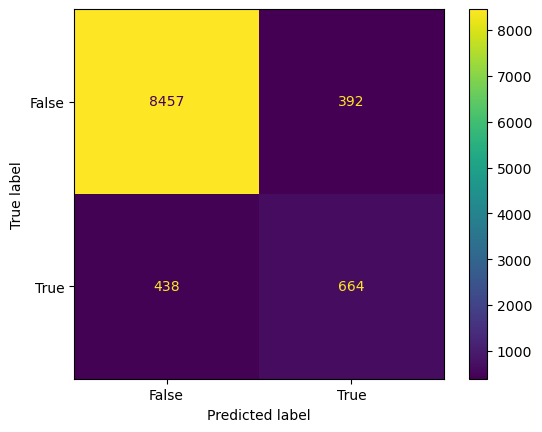

In [168]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
y_pred_class=final_model.predict(X_test)
y_pred_class=y_pred_class>0.5
y_pred_class.astype(int)[:5]
cm=confusion_matrix(y_test,y_pred_class)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()

Using the confusion matrix, we can calculate the following - 

Number of False Positives, FP = 438

Number of False Negatives, FN = 392

Number of True Positives, TP = 664

Number of True Negatives, TN = 8457

1. False Positive Rate (FPR) = FP / (FP + TN) =  438 / (438 + 8457) = 0.0492
------------------------------------------------------------------------------------
2. False Negative Rate (Type2 Error)= FN / (FN + TP) =  392 / (392 + 664) = 0.3712 
------------------------------------------------------------------------------------
3. True Positive Rate (TPR) = TP / (TP + FN) =  664 / (664 + 392) = 0.6287
------------------------------------------------------------------------------------
4. True Negative Rate (Type1 Error) = TN / (TN + FP) = 8457 / (8457 + 438) = 0.9507 
------------------------------------------------------------------------------------
5. Accuracy = (TP + TN) / (TP + TN + FP + FN) = 0.9165

We can also calculate the same metrics using code as well. Below is how you can do it.

In [169]:
from sklearn.metrics import classification_report
 
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      8849
           1       0.63      0.60      0.62      1102

    accuracy                           0.92      9951
   macro avg       0.79      0.78      0.78      9951
weighted avg       0.92      0.92      0.92      9951



In [170]:
!pip install shap

In [171]:
import shap
# Feature Importance 
explainer = shap.KernelExplainer(final_model, X_train[:1000])

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [172]:
shap_values = explainer.shap_values(X_test[:300])

  0%|          | 0/300 [00:00<?, ?it/s]

SHAP values overcome one of the limitations of Artificial Neural Network where it is hard to interpret the individual contribution of input features on the final model. Unlike other parametric methods such as linear regression or logistic regression, Neural Networks pose a challenge in determining feature importance because of time complexity in computing permutation based importance metrics for attributes over large datasets. SHAP overcomes that limitation in a more sophisticated way.  

SHAP values measure feature importance at row level. It represents how a feature influences the prediction of a single row relative to the other features in that row and to the average outcome in the dataset. Features are ranked in the diminishing order of influence. The size of the bar plot shows the magnitude of the influence that feature has on the final outcome. 

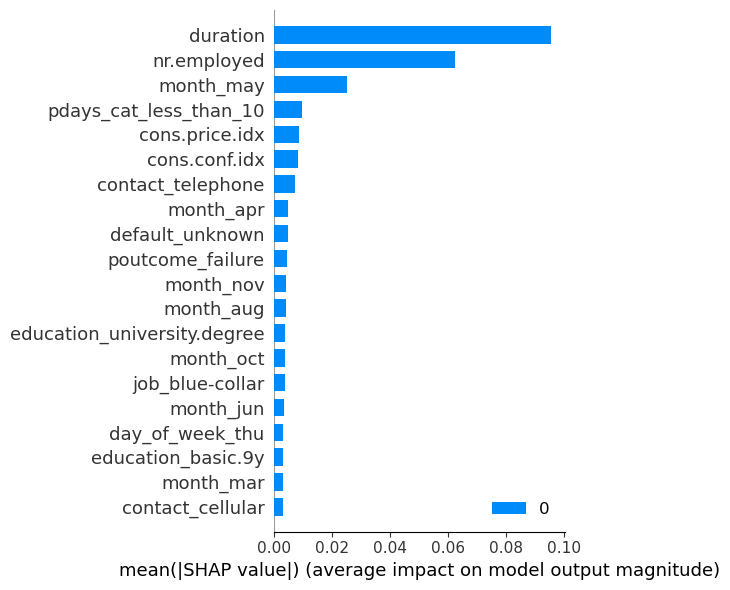

In [173]:
# visualize the first prediction's explanation
#shap.summary_plot(shap_values, X_val[:20])
shap.summary_plot(shap_values=shap_values, features=X_test,
class_names = [0,1],plot_size=(6,6))

**Explanation of SHAP Value Plot** - 

The horizontal bar plot shows the average impact of a feature on model output. Here, duration of last contact, number of employees, and whether last contact month of the year was May or not contribute the most in estimating customer subscribription rate for a term deposit.

**Summary**
1. Optimal Set of Hyperparameters for our Neural Network is given by - 
   * neurons = 31
   * learning_rate = 0.1
   * batch_size = 2048
   * optimizer = adam
   * epochs = 100
2. Accuracy = 91.65%
3. Precision for (y=0) = 95%
4. Precision for (y=1) = 63%
5. Duration of last contact is the most influencing factor in determining whether a customer will subscribe to a term deposit.